In [1]:
#    Usefull link(s):
#    with a diagram of how to procede with a time series forecasting
#    https://stats.stackexchange.com/questions/380599/is-it-possible-to-automate-time-series-forecasting/380689#380689

In [2]:
# import requests        # for making http requests to binance
# import json            # for parsing what binance sends back to us
import pandas as pd    # for storing and manipulating the data we get back
import numpy as np     # numerical python, i usually need this somewhere 
                       # and so i import by habit nowadays

import matplotlib.pyplot as plt # for charts and such
import matplotlib.ticker as ticker

import itertools
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import pearsonr


from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.stattools import kpss
# from arch import arch_model
from statsmodels.tsa.ar_model import AutoReg
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# import seaborn as sns

# from plotly.offline import init_notebook_mode, iplot
# from plotly import graph_objs as go

from pylab import rcParams
# import pmdarima as pm

# from keras.models import Sequential
# from keras.layers import Dropout
# from keras.layers import Dense
# from keras.layers import LSTM
# import keras

from sklearn.preprocessing import MinMaxScaler

# Initialize plotly
# init_notebook_mode(connected=True)

# from fbprophet import Prophet
import logging
logging.getLogger().setLevel(logging.ERROR)

import datetime as dt  # for dealing with times
%matplotlib inline 

import warnings
warnings.simplefilter('ignore')

In [3]:
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 100)

In [10]:
df_gemini_price_d = pd.read_csv('datasets/kaggle/BTCUSD_day.csv')
df_gemini_price_1h = pd.read_csv('datasets/kaggle/BTCUSD_1hr.csv')

In [11]:
df_gemini_price_d['Date'] = pd.to_datetime(df_gemini_price_d['Date'])
df_gemini_price_1h['Date'] = pd.to_datetime(df_gemini_price_1h['Date'])

In [12]:
print('------------', 'df_gemini_price_d', '------------')
print(df_gemini_price_d['Date'].max())
print(df_gemini_price_d['Date'].min())
print('------------', 'df_gemini_price_1h', '------------')
print(df_gemini_price_1h['Date'].max())
print(df_gemini_price_1h['Date'].min())

------------ df_gemini_price_d ------------
2020-04-09 00:00:00
2015-10-08 00:00:00
------------ df_gemini_price_1h ------------
2020-04-09 00:00:00
2015-10-08 13:00:00


In [13]:
print('------------', 'df_coinmarket_price_d', '------------')
print(df_gemini_price_d.shape[0])
print('------------', 'df_coinmarket_price_1h', '------------')
print(df_gemini_price_1h.shape[0])

------------ df_coinmarket_price_d ------------
1646
------------ df_coinmarket_price_1h ------------
39468


In [8]:
# def perform_metrics(y_truth, y_forecasted): 
    
#     mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
#     mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
#     mse = round(mean_squared_error(y_truth, y_forecasted), 4)
#     rmse = round(mse**(0.5), 4)
#     rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
#     r2 = round(r2_score(y_truth, y_forecasted), 4)
#     corr, _ = pearsonr(y_truth, y_forecasted)
#     pearson = round(corr, 4)
    
# #     print('mae', mae)
# #     print('mape', mape)
# #     print('mse', mse)
# #     print('rmse', rmse)
# #     print('rmspe', rmspe)
# #     print('r2', r2)
# #     print('pearson', pearson)
    
#     return mae, mape, mse, rmse, rmspe, r2, pearson

In [14]:
class ExponentialSmoothingForecast(object):
    
    def __init__(self, df, percentage_train_size, list_alpha, list_beta):
        
        self.df = df
        self.percentage_train_size = percentage_train_size
        self.list_alpha = list_alpha
        self.list_beta = list_beta
            
    def perform(self):
        
        best_params, last_index = self.create_model()
        
        array_pred = np.array([])
        
        for row in self.df.iloc[-last_index:].itertuples():
            
            pred = self.prediction(best_params = best_params, last_index = row[0])
            array_pred = np.append(array_pred, pred)
            print('last_index', row[0])
            print('pred', pred)
        
        print('---')
        print('list_pred', array_pred)
        print('df close', self.df.iloc[-last_index:]['Close'].values)

            
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df.index[:-last_index], self.df['Close'].values[:-last_index], color="gray")
        ax.plot(self.df.index[-last_index:], self.df['Close'].values[-last_index:], label = 'Close', color="gray")
        ax.plot(self.df.index[-last_index:], self.df.iloc[-last_index:]['Close'].values, color = 'r')
        ax.plot(self.df.index[-last_index:], array_pred.reshape(-1, 1), label="alpha="+str(best_params), color = 'r')
        ax.legend()
        plt.show()
        
        y_true = self.df.iloc[-last_index:]['Close'].values
        y_pred = array_pred.reshape(-1, 1)
        print('len', len(y_true), len(y_pred)) #somente para checar
        
        data = {
            'y_true': self.df.iloc[-last_index:]['Close'].values,
            'y_pred': array_pred
        }
        
        df_aux = pd.DataFrame(data)
        
        mae, mape, mse, rmse, rmspe, r2, pearson = self.perform_metrics(df_aux['y_true'], df_aux['y_pred'])
        print('mae', mae,
              'mape', mape,
              'mse', mse,
              'rmse', rmse,
              'rmspe', rmspe,
              'r2', r2,
              'pearson', pearson)
        
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df.iloc[-last_index:].index, y_true, color="b", label = "true")
        ax.plot(self.df.iloc[-last_index:].index, y_pred, color="r", linestyle = '--', label = "pred")
        ax.legend()
        plt.show()
        
        return True
    
    def prediction(self, best_params, last_index):
        
        train_index = (last_index - pd.Timedelta(days = 1)).strftime('%Y-%m-%d')
        
        model = ExponentialSmoothing(self.df[:train_index])
                
        fit_model = model.fit(smoothing_level = best_params)
        
#         pred = fit_model.forecast( steps = 1)
#         print('last_index', last_index)
#         print('df tail - >\n', self.df[:last_index].tail(1))
        
        pred = fit_model.predict( start = last_index, end = last_index)

        return pred
    
    def create_model(self):
        
        last_index = int(len(self.df)*(1 - self.percentage_train_size))
        
        model = ExponentialSmoothing(np.asarray(self.df.iloc[:-last_index]))
        best_aic = np.inf
        best_fit = 0
        
#         fit_model = model.fit(optimized = True)
        
#         best_params = (fit_model.params['smoothing_level'],
#             fit_model.params['smoothing_slope'],
#             fit_model.params['smoothing_seasonal']
#         )
#         best_aic = fit_model.aic
        
        for alpha in self.list_alpha:
                
            fit_model = model.fit(smoothing_level = alpha)

            if fit_model.aic < best_aic:
                best_aic = fit_model.aic
                best_fit = fit_model
                best_params = alpha
        
        print('AIC', best_aic, 'best_params', best_params)
        
        return best_params, last_index
    
    def perform_metrics(self, y_truth, y_forecasted): 

        mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
        mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
        mse = round(mean_squared_error(y_truth, y_forecasted), 4)
        rmse = round(mse**(0.5), 4)
        rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
        r2 = round(r2_score(y_truth, y_forecasted), 4)
        corr, _ = pearsonr(y_truth, y_forecasted)
        pearson = round(corr, 4)

#         print('mae', mae)
#         print('mape', mape)
#         print('mse', mse)
#         print('rmse', rmse)
#         print('rmspe', rmspe)
#         print('r2', r2)
#         print('pearson', pearson)
    
        return mae, mape, mse, rmse, rmspe, r2, pearson
    



In [15]:
df = df_gemini_price_d.copy()
df = df.set_index('Date')
df = df.sort_values(by = ['Date'])
df = df.loc[:, ['Close']]

df.head()

,Close
Date,
2015-10-08,243.95
2015-10-09,245.39
2015-10-10,246.30
2015-10-11,249.50
2015-10-12,247.60


AIC 14968.180404816416 best_params 0.9
last_index 2019-05-17 00:00:00
pred 2019-05-17    7910.803288
Freq: D, dtype: float64
last_index 2019-05-18 00:00:00
pred 2019-05-18    7416.808329
Freq: D, dtype: float64
last_index 2019-05-19 00:00:00
pred 2019-05-19    7277.948833
Freq: D, dtype: float64
last_index 2019-05-20 00:00:00
pred 2019-05-20    8100.990883
Freq: D, dtype: float64
last_index 2019-05-21 00:00:00
pred 2019-05-21    8013.672088
Freq: D, dtype: float64
last_index 2019-05-22 00:00:00
pred 2019-05-22    7960.408209
Freq: D, dtype: float64
last_index 2019-05-23 00:00:00
pred 2019-05-23    7654.040821
Freq: D, dtype: float64
last_index 2019-05-24 00:00:00
pred 2019-05-24    7857.332082
Freq: D, dtype: float64
last_index 2019-05-25 00:00:00
pred 2019-05-25    7989.657208
Freq: D, dtype: float64
last_index 2019-05-26 00:00:00
pred 2019-05-26    8066.348721
Freq: D, dtype: float64
last_index 2019-05-27 00:00:00
pred 2019-05-27    8681.643872
Freq: D, dtype: float64
last_index 2019

last_index 2019-09-07 00:00:00
pred 2019-09-07    10375.752715
Freq: D, dtype: float64
last_index 2019-09-08 00:00:00
pred 2019-09-08    10472.608271
Freq: D, dtype: float64
last_index 2019-09-09 00:00:00
pred 2019-09-09    10413.506827
Freq: D, dtype: float64
last_index 2019-09-10 00:00:00
pred 2019-09-10    10323.941683
Freq: D, dtype: float64
last_index 2019-09-11 00:00:00
pred 2019-09-11    10122.394168
Freq: D, dtype: float64
last_index 2019-09-12 00:00:00
pred 2019-09-12    10157.247417
Freq: D, dtype: float64
last_index 2019-09-13 00:00:00
pred 2019-09-13    10405.091742
Freq: D, dtype: float64
last_index 2019-09-14 00:00:00
pred 2019-09-14    10363.852174
Freq: D, dtype: float64
last_index 2019-09-15 00:00:00
pred 2019-09-15    10360.646217
Freq: D, dtype: float64
last_index 2019-09-16 00:00:00
pred 2019-09-16    10319.276622
Freq: D, dtype: float64
last_index 2019-09-17 00:00:00
pred 2019-09-17    10276.061662
Freq: D, dtype: float64
last_index 2019-09-18 00:00:00
pred 2019-09

last_index 2019-12-20 00:00:00
pred 2019-12-20    7162.275276
Freq: D, dtype: float64
last_index 2019-12-21 00:00:00
pred 2019-12-21    7184.410528
Freq: D, dtype: float64
last_index 2019-12-22 00:00:00
pred 2019-12-22    7144.747053
Freq: D, dtype: float64
last_index 2019-12-23 00:00:00
pred 2019-12-23    7476.282705
Freq: D, dtype: float64
last_index 2019-12-24 00:00:00
pred 2019-12-24    7332.541271
Freq: D, dtype: float64
last_index 2019-12-25 00:00:00
pred 2019-12-25    7267.929127
Freq: D, dtype: float64
last_index 2019-12-26 00:00:00
pred 2019-12-26    7200.132913
Freq: D, dtype: float64
last_index 2019-12-27 00:00:00
pred 2019-12-27    7196.260291
Freq: D, dtype: float64
last_index 2019-12-28 00:00:00
pred 2019-12-28    7237.120029
Freq: D, dtype: float64
last_index 2019-12-29 00:00:00
pred 2019-12-29    7294.342003
Freq: D, dtype: float64
last_index 2019-12-30 00:00:00
pred 2019-12-30    7380.8122
Freq: D, dtype: float64
last_index 2019-12-31 00:00:00
pred 2019-12-31    7232.7

last_index 2020-03-25 00:00:00
pred 2020-03-25    6741.77516
Freq: D, dtype: float64
last_index 2020-03-26 00:00:00
pred 2020-03-26    6699.434516
Freq: D, dtype: float64
last_index 2020-03-27 00:00:00
pred 2020-03-27    6725.539452
Freq: D, dtype: float64
last_index 2020-03-28 00:00:00
pred 2020-03-28    6413.113945
Freq: D, dtype: float64
last_index 2020-03-29 00:00:00
pred 2020-03-29    6273.520395
Freq: D, dtype: float64
last_index 2020-03-30 00:00:00
pred 2020-03-30    5921.782039
Freq: D, dtype: float64
last_index 2020-03-31 00:00:00
pred 2020-03-31    6358.397204
Freq: D, dtype: float64
last_index 2020-04-01 00:00:00
pred 2020-04-01    6421.52572
Freq: D, dtype: float64
last_index 2020-04-02 00:00:00
pred 2020-04-02    6641.696572
Freq: D, dtype: float64
last_index 2020-04-03 00:00:00
pred 2020-04-03    6785.069657
Freq: D, dtype: float64
last_index 2020-04-04 00:00:00
pred 2020-04-04    6745.298966
Freq: D, dtype: float64
last_index 2020-04-05 00:00:00
pred 2020-04-05    6857.7

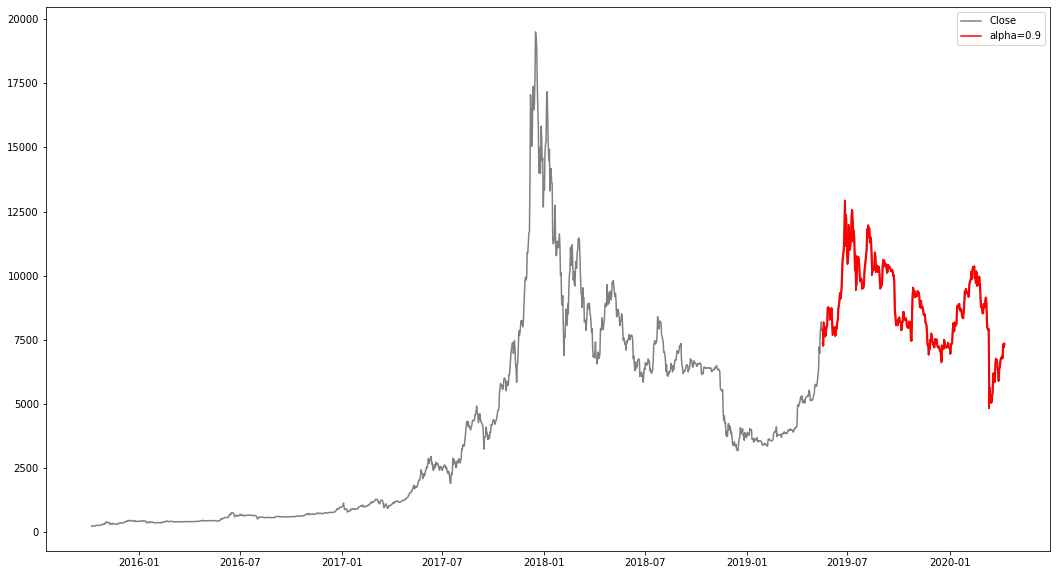

len 329 329
mae 254.9585 mape 2.9474 mse 158306.2908 rmse 397.8772 rmspe 5.2782 r2 0.9311 pearson 0.9654


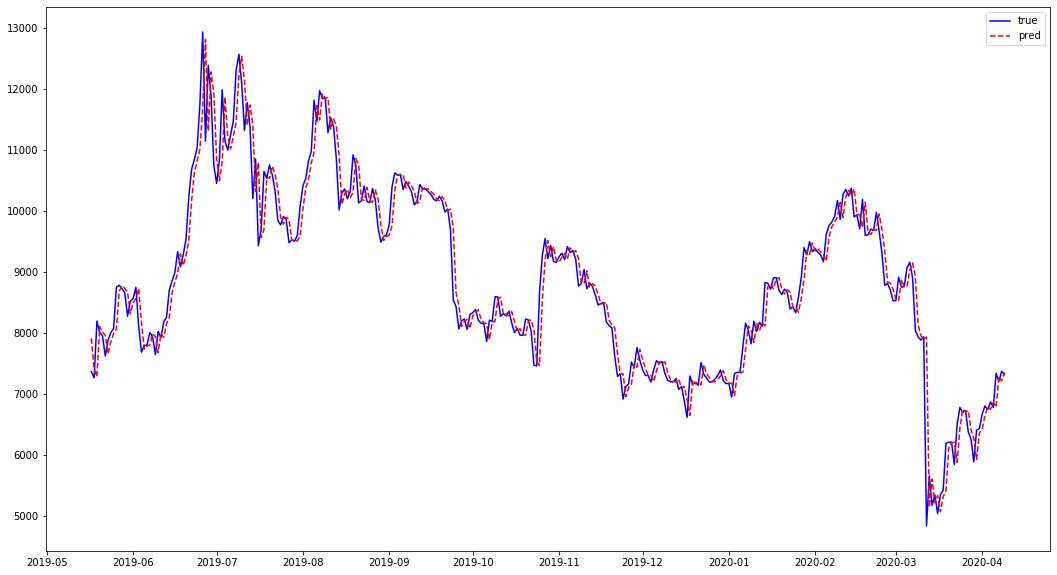

In [15]:
### MAIN

df = df_gemini_price_d.copy()
# df = df_gemini_price_1h.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

df = df.set_index('Date')
df = df.loc[:, ['Close']]
df = df.sort_values(by = ['Date'])
df = df.asfreq('D') # D or H

###
# percentage_train_size = 0.98
# last_index = int(len(df)*(1 - percentage_train_size))
# df_train = df.iloc[:-last_index]
# df_teste = df.iloc[-last_index:]

# model = ExponentialSmoothing(df_train, trend='add', damped=False)
# best_aic = np.inf
# best_fit = 0

# fit_model = model.fit(optimized=True, use_boxcox=False, remove_bias=False)

# best_params = ( fit_model.params['smoothing_level'],
#                 fit_model.params['smoothing_slope'],
#                 fit_model.params['smoothing_seasonal']
# )
# best_aic = fit_model.aic

# print('best_params', best_params)
# print('best_aic', best_aic)

# pred = fit_model.predict( start = '2020-03-09', end = '2020-03-09')
# print('df_train->\n', df_train.tail(1))
# print('pred->\n', pred)
# df_teste
###



days = 1
list_alpha = [a/100 for a in range(0, 100, 10)]
list_beta = [b/100 for b in range(0, 100, 10)]
exponential_smoothing_forecast = ExponentialSmoothingForecast(df = df,
                                             percentage_train_size = 0.80, 
                                             list_alpha = list_alpha, 
                                             list_beta = list_beta
                                            )
_ = exponential_smoothing_forecast.perform()

#exponentialsmoothing é um modelo para series nao estacionarias, não ha necessidade de fazer essa transformação.
#talvez o box_cox seja util, e falta definir os outros parametros q serao usados

In [49]:
#diario
# variando 1 ticket 
# mae 4.8521 mape 0.0597 mse 35.0715 rmse 5.9221 rmspe 0.0747 r2 1.0 pears
# AIC 17276.259290836486 best_params (0.99, 0.0)
# 80% treino

#diario
# variando 5 ticket
# mae 12.4462 mape 0.1511 mse 369.8041 rmse 19.2303 rmspe 0.2581 r2 0.9999 pearson 1.0
# AIC 17288.249021280662 best_params (0.95, 0.0)
# 80% treino

#por hora 
#variando 5 ticket
#mae 1.7675 mape 0.023 mse 10.7606 rmse 3.2803 rmspe 0.0485 r2 1.0 pearson 1.0
#AIC 174734.91212908336 best_params (0.95, 0.0)
#80% treino

In [49]:
class ARIMAForecast(object):
    
    def __init__(self, df, percentage_train_size):
        
        self.df = df
        self.percentage_train_size = percentage_train_size
    
    def perform(self):
        
        best_order, last_index, best_mdl = self.create_model()
        
        array_pred = np.array([])
                
        for row in self.df.iloc[-last_index:].itertuples():
            
            pred, best_mdl = self.prediction(best_order = best_order, last_index = row[0], model = best_mdl)
            array_pred = np.append(array_pred, pred)
            print('last_index', row[0])
            print('pred', pred)
        
        print('---')
        print('list_pred', array_pred)
        print('df close', self.df.iloc[-last_index:]['Close'].values)
        
        y_true = self.df.iloc[-last_index:]['Close'].values
        y_pred = array_pred.reshape(-1, 1)
        print('len', len(y_true), len(y_pred)) #somente para checar
        data = {
            'y_true': self.df.iloc[-last_index:]['Close'].values,
            'y_pred': array_pred
        }
        
        df_aux = pd.DataFrame(data)
        
        mae, mape, mse, rmse, rmspe, r2, pearson = self.perform_metrics(df_aux['y_true'], df_aux['y_pred'])
        print('mae', mae,
              'mape', mape,
              'mse', mse,
              'rmse', rmse,
              'rmspe', rmspe,
              'r2', r2,
              'pearson', pearson)
        
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df.iloc[-last_index:].index, y_true, color="b", label = "true")
        ax.plot(self.df.iloc[-last_index:].index, y_pred, color="r", linestyle = '--', label = "pred")
        ax.legend()
        plt.show()
        
    def perform_metrics(self, y_truth, y_forecasted): 

        mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
        mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
        mse = round(mean_squared_error(y_truth, y_forecasted), 4)
        rmse = round(mse**(0.5), 4)
        rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
        r2 = round(r2_score(y_truth, y_forecasted), 4)
        corr, _ = pearsonr(y_truth, y_forecasted)
        pearson = round(corr, 4)

#         print('mae', mae)
#         print('mape', mape)
#         print('mse', mse)
#         print('rmse', rmse)
#         print('rmspe', rmspe)
#         print('r2', r2)
#         print('pearson', pearson)
    
        return mae, mape, mse, rmse, rmspe, r2, pearson
    
    def prediction(self, best_order, last_index, model):
        
#         mod = sm.tsa.statespace.SARIMAX(self.df[:last_index],
#                                         order=(best_order[0], best_order[1], best_order[2]),
#                                         seasonal_order=(0, 0, 0, 0),
#                                         enforce_stationarity=False,
#                                         enforce_invertibility=False)
#         results = mod.fit()
#         pred = results.forecast(steps = 1)
        train_index = (last_index - pd.Timedelta(days = 1)).strftime('%Y-%m-%d')
    
        model = pm.ARIMA(order = best_order) #enforce_stationarity = False
        model = model.fit(self.df[:train_index])
        
#         model = model.update(self.df[last_index:last_index])
        
        print(self.df[train_index:train_index])
        pred = model.predict(n_periods = 1, alpha = 0.05)[-1]
            
        return pred, model
    
    def create_model(self):
        
        last_index = int(len(self.df)*(1 - self.percentage_train_size))
        
        best_aic = np.inf 
        best_order = None
        best_mdl = None

        pq_rng = range(5) # [0,1,2,3]
        d_rng = range(3) # [0,1]
        for p in pq_rng:
            for d in d_rng:
                for q in pq_rng:
                    try:
                        mod = pm.ARIMA(order=(p, d, q))

                        results = mod.fit(self.df.iloc[:last_index])

                        tmp_aic = results.aic()
                        
                        if tmp_aic < best_aic:
                            best_aic = tmp_aic
                            best_order = (p, d, q)
                            best_mdl = mod #não esta sendo utilizado
                            
                    except: continue
        
#         model = pm.auto_arima(self.df.iloc[:-last_index],
#                               start_p = 0,
#                               start_q = 0, 
#                               start_d = 0, 
#                               max_p = 5,
#                               max_d = 2,
#                               max_q = 5,
#                               seasonal=False)

#         best_aic = model.aic()
#         best_order = model.order #não esta sendo utilizado
#         best_mdl = model
        
        
        print('aic: %6.2f | order: %s'%(best_aic, best_order))

        return best_order, last_index, best_mdl
    




aic: 2738.86 | order: (2, 1, 2)
              Close
Date               
2019-05-16  7881.38
last_index 2019-05-17 00:00:00
pred 7851.470126669012
              Close
Date               
2019-05-17  7361.92
last_index 2019-05-18 00:00:00
pred 7392.6732374063595
              Close
Date               
2019-05-18  7262.52
last_index 2019-05-19 00:00:00
pred 7253.966808654334
              Close
Date               
2019-05-19  8192.44
last_index 2019-05-20 00:00:00
pred 8269.25485559243
              Close
Date               
2019-05-20  8003.97
last_index 2019-05-21 00:00:00
pred 7967.297283681496
              Close
Date               
2019-05-21  7954.49
last_index 2019-05-22 00:00:00
pred 8012.201157605251
             Close
Date              
2019-05-22  7620.0
last_index 2019-05-23 00:00:00
pred 7584.641880372591
              Close
Date               
2019-05-23  7879.92
last_index 2019-05-24 00:00:00
pred 7939.506131557146
              Close
Date               
2019-05-24  8004.36

             Close
Date              
2019-07-27  9478.3
last_index 2019-07-28 00:00:00
pred 9364.608502618372
              Close
Date               
2019-07-28  9523.42
last_index 2019-07-29 00:00:00
pred 9582.144283815142
              Close
Date               
2019-07-29  9504.23
last_index 2019-07-30 00:00:00
pred 9506.89842397409
              Close
Date               
2019-07-30  9599.07
last_index 2019-07-31 00:00:00
pred 9550.424741471026
               Close
Date                
2019-07-31  10079.54
last_index 2019-08-01 00:00:00
pred 10147.01734309049
               Close
Date                
2019-08-01  10409.99
last_index 2019-08-02 00:00:00
pred 10316.039506802712
               Close
Date                
2019-08-02  10528.81
last_index 2019-08-03 00:00:00
pred 10617.805035577885
               Close
Date                
2019-08-03  10817.34
last_index 2019-08-04 00:00:00
pred 10751.127705397708
              Close
Date               
2019-08-04  10975.0
last_index 2019-0

              Close
Date               
2019-10-06  7860.01
last_index 2019-10-07 00:00:00
pred 7904.1767313999635
              Close
Date               
2019-10-07  8208.67
last_index 2019-10-08 00:00:00
pred 8204.750893886565
              Close
Date               
2019-10-08  8188.17
last_index 2019-10-09 00:00:00
pred 8156.004894091614
              Close
Date               
2019-10-09  8592.01
last_index 2019-10-10 00:00:00
pred 8663.678214326565
              Close
Date               
2019-10-10  8589.51
last_index 2019-10-11 00:00:00
pred 8496.051364750718
              Close
Date               
2019-10-11  8272.76
last_index 2019-10-12 00:00:00
pred 8367.354219398223
              Close
Date               
2019-10-12  8314.22
last_index 2019-10-13 00:00:00
pred 8245.332382833813
              Close
Date               
2019-10-13  8275.99
last_index 2019-10-14 00:00:00
pred 8314.372639973242
              Close
Date               
2019-10-14  8355.87
last_index 2019-10-15 00:00

              Close
Date               
2019-12-18  7292.61
last_index 2019-12-19 00:00:00
pred 7282.051274280759
             Close
Date              
2019-12-19  7155.0
last_index 2019-12-20 00:00:00
pred 7133.722777726465
              Close
Date               
2019-12-20  7186.87
last_index 2019-12-21 00:00:00
pred 7238.930058531167
              Close
Date               
2019-12-21  7140.34
last_index 2019-12-22 00:00:00
pred 7074.240462704928
              Close
Date               
2019-12-22  7513.12
last_index 2019-12-23 00:00:00
pred 7591.785447967103
              Close
Date               
2019-12-23  7316.57
last_index 2019-12-24 00:00:00
pred 7236.859109098124
              Close
Date               
2019-12-24  7260.75
last_index 2019-12-25 00:00:00
pred 7333.350640848495
             Close
Date              
2019-12-25  7192.6
last_index 2019-12-26 00:00:00
pred 7143.278276444277
              Close
Date               
2019-12-26  7195.83
last_index 2019-12-27 00:00:00
pre

              Close
Date               
2020-02-29  8525.13
last_index 2020-03-01 00:00:00
pred 8619.897867565322
             Close
Date              
2020-03-01  8528.4
last_index 2020-03-02 00:00:00
pred 8458.762128033046
              Close
Date               
2020-03-02  8912.92
last_index 2020-03-03 00:00:00
pred 8967.15567565338
              Close
Date               
2020-03-03  8751.88
last_index 2020-03-04 00:00:00
pred 8725.39652101849
              Close
Date               
2020-03-04  8757.05
last_index 2020-03-05 00:00:00
pred 8757.463282881137
              Close
Date               
2020-03-05  9067.35
last_index 2020-03-06 00:00:00
pred 9108.639419990866
              Close
Date               
2020-03-06  9158.02
last_index 2020-03-07 00:00:00
pred 9097.059115151456
              Close
Date               
2020-03-07  8902.65
last_index 2020-03-08 00:00:00
pred 8970.980755814355
              Close
Date               
2020-03-08  8038.84
last_index 2020-03-09 00:00:00
pr

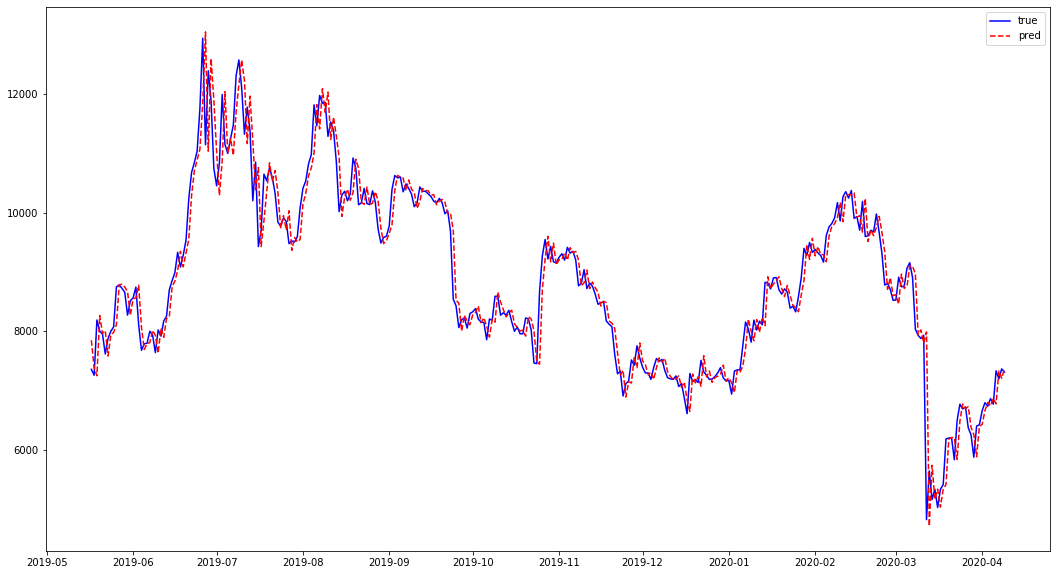

In [65]:
### MAIN

df = df_gemini_price_d.copy()
# df = df_gemini_price_1h.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

df = df.set_index('Date')
df = df.loc[:, ['Close']]
df = df.sort_values(by = ['Date'])
df = df.asfreq('D') # D or H

arima_forecast = ARIMAForecast(df = df, 
                               percentage_train_size = 0.80)
arima_forecast.perform()

In [22]:
# diario
# aic: 21644.13 | order: (1, 1, 1)
# mae 20.9351 mape 0.2591 mse 877.1319 rmse 29.6164 rmspe 0.3744 r2 0.9998 pearson 0.9999
# 80% treino (numero de previssoes: 387) 
# depois de colocar update
# mae 22.3735 mape 0.2792 mse 1009.2598 rmse 31.7688 rmspe 0.406 r2 0.9998 pearson 0.9999

# por hora
# aic: 229438.22 | order: (2, 1, 2)
# mae 2.5702 mape 0.0333 mse 21.1397 rmse 4.5978 rmspe 0.0663 r2 1.0 pearson 1.0
# 80% treino (numero de previssoes: 4824) 

In [59]:
class ProphetForecast(object):
    
    def __init__(self, df, percentage_train_size):
        
        self.df = df
        self.percentage_train_size = percentage_train_size
        self.fitted_lambda = 0
    
    def perform(self):
        
        
        best_order, last_index = self.create_model()
        print('self.df head', self.df.tail())
        
        array_pred = np.array([])
                
        for row in self.df.iloc[-last_index:].itertuples():
    
            pred = self.prediction(best_order = best_order, last_index = row[1])
            array_pred = np.append(array_pred, pred)
            print('last_index', row[1])
            print('pred', pred)
        
        print('---')
        print('list_pred', array_pred)
        print('df close', self.df.iloc[-last_index:]['Close'].values)
        
        y_true = self.df.iloc[-last_index:]['Close'].values
        y_pred = array_pred.reshape(-1, 1)
        print('len', len(y_true), len(y_pred)) #somente para checar
        mae, mape, mse, rmse, rmspe, r2, pearson = self.perform_metrics(y_truth = y_true, y_forecasted = y_pred)
        print('mae', mae,
              'mape', mape,
              'mse', mse,
              'rmse', rmse,
              'rmspe', rmspe,
              'r2', r2,
              'pearson', pearson)
        
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df.iloc[-last_index:]['Date'], y_true, color="b", label = "true")
        ax.plot(self.df.iloc[-last_index:]['Date'], y_pred, color="r", linestyle = '--', label = "pred")
        plt.legend()
        
    def perform_metrics(self, y_truth, y_forecasted): 

        mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
        mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
        mse = round(mean_squared_error(y_truth, y_forecasted), 4)
        rmse = round(mse**(0.5), 4)
        rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
        r2 = round(r2_score(y_truth, y_forecasted), 4)
        try:
            corr, _ = pearsonr(y_truth, y_forecasted)
            pearson = round(corr, 4)
        except:
            pearson = None

#         print('mae', mae)
#         print('mape', mape)
#         print('mse', mse)
#         print('rmse', rmse)
#         print('rmspe', rmspe)
#         print('r2', r2)
#         print('pearson', pearson)
    
        return mae, mape, mse, rmse, rmspe, r2, pearson
    
    def prediction(self, best_order, last_index):
        
        model = Prophet()
        #changepoint_prior_scale=0.5
        
        df_train = self.df[['Date', 'diff_2']]
        df_train.columns = ['ds', 'y']
        df_train = df_train[ df_train['ds'] < last_index]
        df_train[:2]
        
        model.fit(df_train)
        future = model.make_future_dataframe(periods=1, freq='D')
        
        print('df_fit->\n', df_train.tail(1))
        print('future->\n', future.tail(1))
        
        forecast = model.predict(future)
        
        print('forecast->\n', forecast.iloc[-1][['ds', 'yhat']])
#         print('yhat\n', forecast.iloc[-1]['yhat'])
        
        last_row = self.df[ self.df['Date'] == last_index]
        
        print('last_row->\n', last_row )
        print('self.fitted_lambda->', self.fitted_lambda)
#         pred = last_row['Close'].values[-1] + last_row['diff_1'].values[-1] + forecast.iloc[-1]['yhat']
#         pred = forecast.iloc[-1]['yhat']
#         pred = last_row['Close_transform'].values[-1] + forecast.iloc[-1]['yhat']
        pred = last_row['Close_transform'].values[-1] + last_row['diff_1'].values[-1] + forecast.iloc[-1]['yhat']
        print('pred raw->', pred)
        pred = inv_boxcox(pred, self.fitted_lambda)
        
        return pred
    
    def create_model(self):
        
        last_index = int(len(self.df)*(1 - self.percentage_train_size))
        
        best_aic = np.inf 
        best_order = None
        best_mdl = None
        #otimizar treino não implementado
        #yearly_seasonality = False, daily_seasonality = False, weekly_seasonality = False    
        
        self.df['Close_transform'], self.fitted_lambda = boxcox(self.df['Close'], lmbda = None)
        self.df['diff_1'] = self.df['Close_transform'].diff()
        self.df['diff_2'] = self.df['diff_1'].diff()
        
        df_train = self.df[['Date', 'diff_2']]
        df_train.columns = ['ds', 'y']
        
        
        m = Prophet()
        m.fit(df_train[:-last_index])

            
#             tmp_aic = results.aic
#             if tmp_aic < best_aic:
#                 best_aic = tmp_aic
#                 best_order = (i, d, j)
#                 best_mdl = mod #não esta sendo utilizado

#         print('aic: %6.2f | order: %s'%(best_aic, best_order))
        
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df[:-last_index]['Date'], self.df[:-last_index]['Close_transform'], color="b", label = "Close_transform")
        plt.legend()
        plt.show()
        
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df[:-last_index]['Date'], self.df[:-last_index]['diff_1'], color="b", label = "diff_1")
        plt.legend()
        plt.show()
        
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df[:-last_index]['Date'], self.df[:-last_index]['diff_2'], color="b", label = "diff_2")
        plt.legend()
        plt.show()
        
        return None, last_index
    




INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


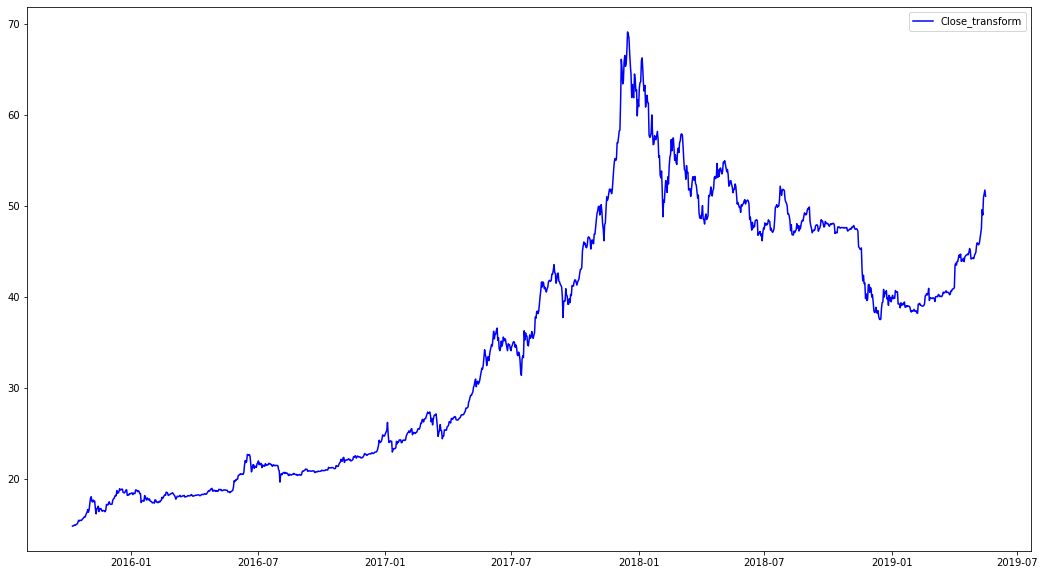

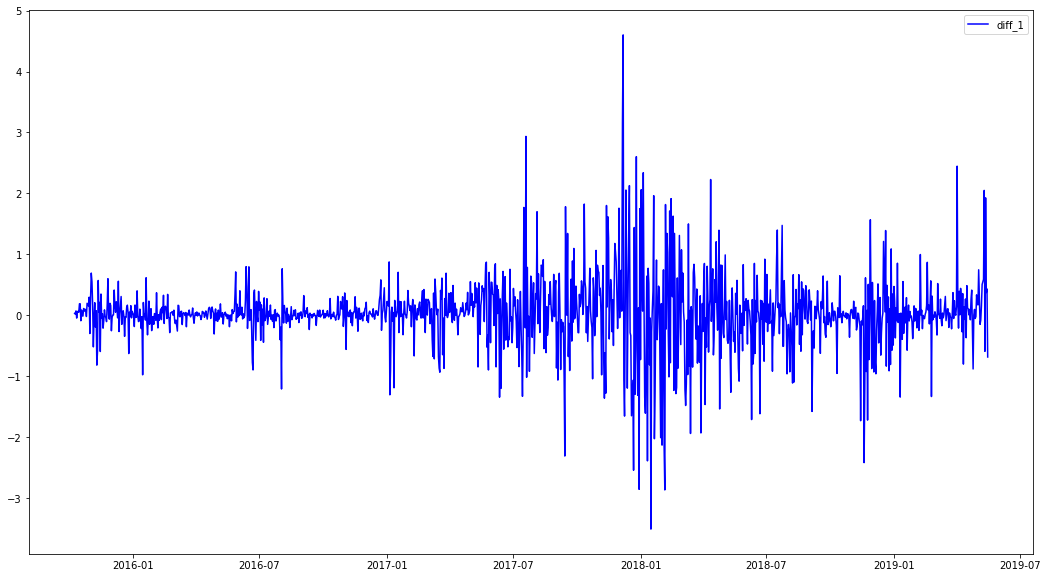

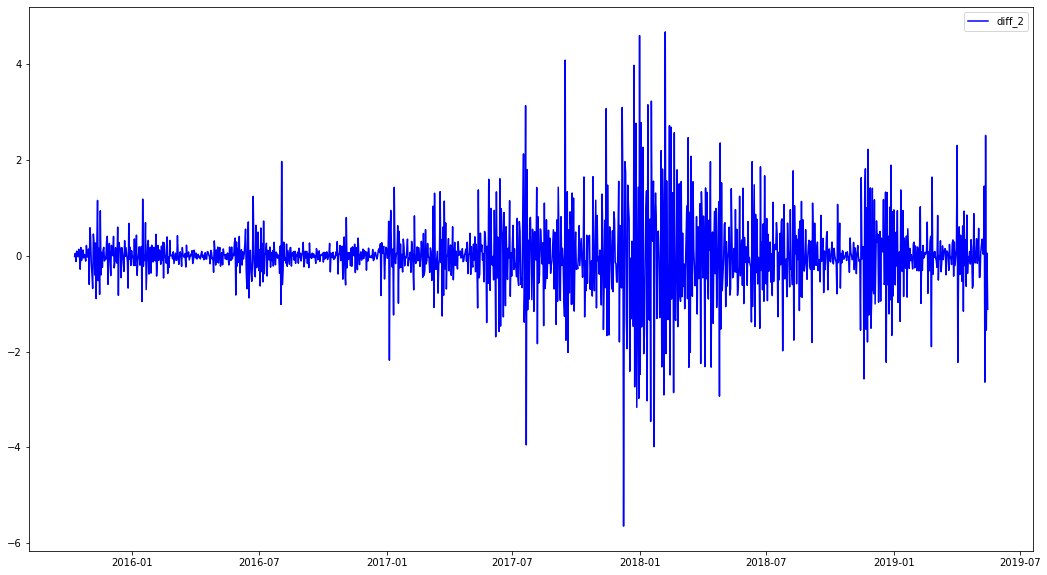

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


self.df head            Date    Close  Close_transform    diff_1    diff_2
1641 2020-04-05  6775.21        48.521537 -0.228565 -0.540272
1642 2020-04-06  7336.96        49.842909  1.321372  1.549937
1643 2020-04-07  7201.81        49.531494 -0.311415 -1.632787
1644 2020-04-08  7369.60        49.917531  0.386036  0.697451
1645 2020-04-09  7315.25        49.793150 -0.124380 -0.510416
df_fit->
              ds         y
1316 2019-05-16 -1.116628
future->
              ds
1317 2019-05-17


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-05-17 00:00:00
yhat              -0.017143
Name: 1317, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1317 2019-05-17  7361.92        49.899993 -1.159118 -0.477022
self.fitted_lambda-> 0.3169790026020426
pred raw-> 48.72373148264849
last_index 2019-05-17 00:00:00
pred 6859.194524659969
df_fit->
              ds         y
1317 2019-05-17 -0.477022
future->
              ds
1318 2019-05-18


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-05-18 00:00:00
yhat              0.0127874
Name: 1318, dtype: object
last_row->
            Date    Close  Close_transform   diff_1    diff_2
1318 2019-05-18  7262.52        49.671873 -0.22812  0.930998
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.45654024543231
last_index 2019-05-18 00:00:00
pred 7169.536670145982
df_fit->
              ds         y
1318 2019-05-18  0.930998
future->
              ds
1319 2019-05-19


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-05-19 00:00:00
yhat             -0.0962737
Name: 1319, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1319 2019-05-19  8192.44        51.728406  2.056533  2.284653
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.68866576565102
last_index 2019-05-19 00:00:00
pred 9151.569239413566
df_fit->
              ds         y
1319 2019-05-19  2.284653
future->
              ds
1320 2019-05-20


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-05-20 00:00:00
yhat               0.108442
Name: 1320, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1320 2019-05-20  8003.97        51.325001 -0.403406 -2.459939
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.03003735430522
last_index 2019-05-20 00:00:00
pred 7868.053543948876
df_fit->
              ds         y
1320 2019-05-20 -2.459939
future->
              ds
1321 2019-05-21


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-05-21 00:00:00
yhat             -0.0382837
Name: 1321, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1321 2019-05-21  7954.49        51.218019 -0.106982  0.296424
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.07275360611238
last_index 2019-05-21 00:00:00
pred 7887.638433958236
df_fit->
              ds         y
1321 2019-05-21  0.296424
future->
              ds
1322 2019-05-22


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-05-22 00:00:00
yhat             -0.0301065
Name: 1322, dtype: object
last_row->
            Date   Close  Close_transform    diff_1   diff_2
1322 2019-05-22  7620.0        50.482617 -0.735402 -0.62842
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.71710898255345
last_index 2019-05-22 00:00:00
pred 7282.157652780955
df_fit->
              ds        y
1322 2019-05-22 -0.62842
future->
              ds
1323 2019-05-23


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-05-23 00:00:00
yhat              0.0050326
Name: 1323, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1323 2019-05-23  7879.92        51.055928  0.573311  1.308712
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.634270839241445
last_index 2019-05-23 00:00:00
pred 8148.192030845449
df_fit->
              ds         y
1323 2019-05-23  1.308712
future->
              ds
1324 2019-05-24


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-05-24 00:00:00
yhat              0.0183074
Name: 1324, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1324 2019-05-24  8004.36        51.325842  0.269914 -0.303396
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.61406372742758
last_index 2019-05-24 00:00:00
pred 8138.71508010405
df_fit->
              ds         y
1324 2019-05-24 -0.303396
future->
              ds
1325 2019-05-25


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-05-25 00:00:00
yhat              0.0537823
Name: 1325, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1325 2019-05-25  8074.87         51.47751  0.151668 -0.118246
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.68296074840784
last_index 2019-05-25 00:00:00
pred 8171.058109074881
df_fit->
              ds         y
1325 2019-05-25 -0.118246
future->
              ds
1326 2019-05-26


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-05-26 00:00:00
yhat             -0.0766145
Name: 1326, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1326 2019-05-26  8750.01        52.885903  1.408393  1.256725
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.21768123517121
last_index 2019-05-26 00:00:00
pred 9422.96394205622
df_fit->
              ds         y
1326 2019-05-26  1.256725
future->
              ds
1327 2019-05-27


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-05-27 00:00:00
yhat              0.0929256
Name: 1327, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1327 2019-05-27  8781.16        52.949065  0.063162 -1.345231
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.105152667485164
last_index 2019-05-27 00:00:00
pred 8858.463367910688
df_fit->
              ds         y
1327 2019-05-27 -1.345231
future->
              ds
1328 2019-05-28


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-05-28 00:00:00
yhat             -0.0246202
Name: 1328, dtype: object
last_row->
            Date   Close  Close_transform    diff_1  diff_2
1328 2019-05-28  8726.4        52.837927 -0.111138 -0.1743
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.70216919589798
last_index 2019-05-28 00:00:00
pred 8659.826133320208
df_fit->
              ds       y
1328 2019-05-28 -0.1743
future->
              ds
1329 2019-05-29


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-05-29 00:00:00
yhat             -0.0348668
Name: 1329, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1329 2019-05-29  8659.18        52.700848 -0.137079 -0.025941
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.5289022242352
last_index 2019-05-29 00:00:00
pred 8575.363405368806
df_fit->
              ds         y
1329 2019-05-29 -0.025941
future->
              ds
1330 2019-05-30


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-05-30 00:00:00
yhat              0.0239153
Name: 1330, dtype: object
last_row->
            Date    Close  Close_transform    diff_1   diff_2
1330 2019-05-30  8273.76        51.900509 -0.800339 -0.66326
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.12408473359575
last_index 2019-05-30 00:00:00
pred 7911.217156690502
df_fit->
              ds        y
1330 2019-05-30 -0.66326
future->
              ds
1331 2019-05-31


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-05-31 00:00:00
yhat             -0.0155545
Name: 1331, dtype: object
last_row->
            Date   Close  Close_transform   diff_1   diff_2
1331 2019-05-31  8516.2        52.406839  0.50633  1.30667
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.897614610910544
last_index 2019-05-31 00:00:00
pred 8755.780173248664
df_fit->
              ds        y
1331 2019-05-31  1.30667
future->
              ds
1332 2019-06-01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-06-01 00:00:00
yhat              0.0580062
Name: 1332, dtype: object
last_row->
            Date   Close  Close_transform   diff_1    diff_2
1332 2019-06-01  8566.1        52.509828  0.10299 -0.403341
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.670824120459
last_index 2019-06-01 00:00:00
pred 8644.504390576212
df_fit->
              ds         y
1332 2019-06-01 -0.403341
future->
              ds
1333 2019-06-02


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-06-02 00:00:00
yhat             -0.0768695
Name: 1333, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1333 2019-06-02  8745.75        52.877253  0.367425  0.264435
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.16780842144086
last_index 2019-06-02 00:00:00
pred 8889.624314103177
df_fit->
              ds         y
1333 2019-06-02  0.264435
future->
              ds
1334 2019-06-03


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-06-03 00:00:00
yhat              0.0600239
Name: 1334, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1334 2019-06-03  8110.99        51.554855 -1.322398 -1.689823
self.fitted_lambda-> 0.3169790026020426
pred raw-> 50.29248039868238
last_index 2019-06-03 00:00:00
pred 7535.108653205952
df_fit->
              ds         y
1334 2019-06-03 -1.689823
future->
              ds
1335 2019-06-04


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-06-04 00:00:00
yhat              -0.058622
Name: 1335, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1335 2019-06-04  7682.81        50.622368 -0.932487  0.389911
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.63125859973064
last_index 2019-06-04 00:00:00
pred 7244.91959526809
df_fit->
              ds         y
1335 2019-06-04  0.389911
future->
              ds
1336 2019-06-05


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-06-05 00:00:00
yhat             -0.0548975
Name: 1336, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1336 2019-06-05  7791.42        50.862192  0.239824  1.172311
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.04711841708632
last_index 2019-06-05 00:00:00
pred 7875.881016555382
df_fit->
              ds         y
1336 2019-06-05  1.172311
future->
              ds
1337 2019-06-06


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-06-06 00:00:00
yhat              0.0217012
Name: 1337, dtype: object
last_row->
            Date   Close  Close_transform    diff_1   diff_2
1337 2019-06-06  7801.0        50.883236  0.021044 -0.21878
self.fitted_lambda-> 0.3169790026020426
pred raw-> 50.92598089460179
last_index 2019-06-06 00:00:00
pred 7820.48395599428
df_fit->
              ds        y
1337 2019-06-06 -0.21878
future->
              ds
1338 2019-06-07


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-06-07 00:00:00
yhat              0.0026394
Name: 1338, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1338 2019-06-07  8002.98        51.322865  0.439629  0.418585
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.765132692176934
last_index 2019-06-07 00:00:00
pred 8209.747577249856
df_fit->
              ds         y
1338 2019-06-07  0.418585
future->
              ds
1339 2019-06-08


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-06-08 00:00:00
yhat              0.0495155
Name: 1339, dtype: object
last_row->
            Date    Close  Close_transform   diff_1    diff_2
1339 2019-06-08  7936.35        51.178684 -0.14418 -0.583809
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.08401952924686
last_index 2019-06-08 00:00:00
pred 7892.809268154978
df_fit->
              ds         y
1339 2019-06-08 -0.583809
future->
              ds
1340 2019-06-09


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-06-09 00:00:00
yhat             -0.0834097
Name: 1340, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1340 2019-06-09  7643.46        50.534907 -0.643777 -0.499597
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.80771958845082
last_index 2019-06-09 00:00:00
pred 7321.602060380489
df_fit->
              ds         y
1340 2019-06-09 -0.499597
future->
              ds
1341 2019-06-10


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-06-10 00:00:00
yhat              0.0219046
Name: 1341, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1341 2019-06-10  8024.35        51.368933  0.834026  1.477804
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.22486421701376
last_index 2019-06-10 00:00:00
pred 8428.51643304836
df_fit->
              ds         y
1341 2019-06-10  1.477804
future->
              ds
1342 2019-06-11


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-06-11 00:00:00
yhat            -0.00993279
Name: 1342, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1342 2019-06-11  7920.63        51.144547 -0.224386 -1.058412
self.fitted_lambda-> 0.3169790026020426
pred raw-> 50.91022879647385
last_index 2019-06-11 00:00:00
pred 7813.300020361779
df_fit->
              ds         y
1342 2019-06-11 -1.058412
future->
              ds
1343 2019-06-12


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-06-12 00:00:00
yhat             -0.0428819
Name: 1343, dtype: object
last_row->
            Date    Close  Close_transform   diff_1    diff_2
1343 2019-06-12  8176.44        51.694407  0.54986  0.774246
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.20138495594269
last_index 2019-06-12 00:00:00
pred 8417.248182567537
df_fit->
              ds         y
1343 2019-06-12  0.774246
future->
              ds
1344 2019-06-13


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-06-13 00:00:00
yhat              0.0276077
Name: 1344, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1344 2019-06-13  8256.09        51.863211  0.168804 -0.381056
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.05962302199936
last_index 2019-06-13 00:00:00
pred 8349.431816371307
df_fit->
              ds         y
1344 2019-06-13 -0.381056
future->
              ds
1345 2019-06-14


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-06-14 00:00:00
yhat               0.004749
Name: 1345, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1345 2019-06-14  8699.71        52.783586  0.920375  0.751571
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.70870974384707
last_index 2019-06-14 00:00:00
pred 9161.753595120877
df_fit->
              ds         y
1345 2019-06-14  0.751571
future->
              ds
1346 2019-06-15


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-06-15 00:00:00
yhat              0.0441671
Name: 1346, dtype: object
last_row->
            Date   Close  Close_transform   diff_1    diff_2
1346 2019-06-15  8853.3        53.094756  0.31117 -0.609205
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.45009331760518
last_index 2019-06-15 00:00:00
pred 9030.94353203388
df_fit->
              ds         y
1346 2019-06-15 -0.609205
future->
              ds
1347 2019-06-16


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-06-16 00:00:00
yhat             -0.0787803
Name: 1347, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1347 2019-06-16  8989.89        53.368402  0.273646 -0.037524
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.563267156066516
last_index 2019-06-16 00:00:00
pred 9088.029590430615
df_fit->
              ds         y
1347 2019-06-16 -0.037524
future->
              ds
1348 2019-06-17


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-06-17 00:00:00
yhat              0.0430528
Name: 1348, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1348 2019-06-17  9331.03        54.039659  0.671257  0.397611
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.75396845600127
last_index 2019-06-17 00:00:00
pred 9703.648432292306
df_fit->
              ds         y
1348 2019-06-17  0.397611
future->
              ds
1349 2019-06-18


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-06-18 00:00:00
yhat             -0.0213227
Name: 1349, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1349 2019-06-18  9084.31        53.555908 -0.483751 -1.155008
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.05083421522181
last_index 2019-06-18 00:00:00
pred 8831.509305563492
df_fit->
              ds         y
1349 2019-06-18 -1.155008
future->
              ds
1350 2019-06-19


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-06-19 00:00:00
yhat             -0.0456684
Name: 1350, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1350 2019-06-19  9282.65        53.945493  0.389586  0.873336
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.28941048675836
last_index 2019-06-19 00:00:00
pred 9460.180371984372
df_fit->
              ds         y
1350 2019-06-19  0.873336
future->
              ds
1351 2019-06-20


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-06-20 00:00:00
yhat              0.0224012
Name: 1351, dtype: object
last_row->
            Date    Close  Close_transform   diff_1    diff_2
1351 2019-06-20  9534.88        54.432804  0.48731  0.097725
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.94251486393361
last_index 2019-06-20 00:00:00
pred 9803.671764768329
df_fit->
              ds         y
1351 2019-06-20  0.097725
future->
              ds
1352 2019-06-21


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-06-21 00:00:00
yhat              0.0208024
Name: 1352, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1352 2019-06-21  10233.92        55.738888  1.306084  0.818774
self.fitted_lambda-> 0.3169790026020426
pred raw-> 57.06577432569228
last_index 2019-06-21 00:00:00
pred 10979.135912695592
df_fit->
              ds         y
1352 2019-06-21  0.818774
future->
              ds
1353 2019-06-22


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-06-22 00:00:00
yhat              0.0537616
Name: 1353, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1353 2019-06-22  10676.48        56.534536  0.795648 -0.510436
self.fitted_lambda-> 0.3169790026020426
pred raw-> 57.38394563539471
last_index 2019-06-22 00:00:00
pred 11163.18092313681
df_fit->
              ds         y
1353 2019-06-22 -0.510436
future->
              ds
1354 2019-06-23


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-06-23 00:00:00
yhat             -0.0668178
Name: 1354, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1354 2019-06-23  10842.82        56.827759  0.293224 -0.502425
self.fitted_lambda-> 0.3169790026020426
pred raw-> 57.054165184412874
last_index 2019-06-23 00:00:00
pred 10972.46012083025
df_fit->
              ds         y
1354 2019-06-23 -0.502425
future->
              ds
1355 2019-06-24


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-06-24 00:00:00
yhat              0.0562999
Name: 1355, dtype: object
last_row->
            Date    Close  Close_transform    diff_1   diff_2
1355 2019-06-24  11035.0        57.162733  0.334974  0.04175
self.fitted_lambda-> 0.3169790026020426
pred raw-> 57.55400643699696
last_index 2019-06-24 00:00:00
pred 11262.410749132068
df_fit->
              ds        y
1355 2019-06-24  0.04175
future->
              ds
1356 2019-06-25


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-06-25 00:00:00
yhat             -0.0298205
Name: 1356, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1356 2019-06-25  11759.9        58.391522  1.228789  0.893816
self.fitted_lambda-> 0.3169790026020426
pred raw-> 59.59049125492998
last_index 2019-06-25 00:00:00
pred 12497.917853083296
df_fit->
              ds         y
1356 2019-06-25  0.893816
future->
              ds
1357 2019-06-26


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-06-26 00:00:00
yhat             0.00712517
Name: 1357, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1357 2019-06-26  12936.45        60.280161  1.888638  0.659849
self.fitted_lambda-> 0.3169790026020426
pred raw-> 62.17592417230769
last_index 2019-06-26 00:00:00
pred 14195.837074603078
df_fit->
              ds         y
1357 2019-06-26  0.659849
future->
              ds
1358 2019-06-27


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-06-27 00:00:00
yhat              0.0562908
Name: 1358, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1358 2019-06-27  11143.74        57.350507 -2.929654 -4.818292
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.47714375653385
last_index 2019-06-27 00:00:00
pred 9558.060025026849
df_fit->
              ds         y
1358 2019-06-27 -4.818292
future->
              ds
1359 2019-06-28


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-06-28 00:00:00
yhat             -0.0288343
Name: 1359, dtype: object
last_row->
            Date     Close  Close_transform   diff_1    diff_2
1359 2019-06-28  12388.24        59.415426  2.06492  4.994574
self.fitted_lambda-> 0.3169790026020426
pred raw-> 61.451511802351476
last_index 2019-06-28 00:00:00
pred 13705.153120535439
df_fit->
              ds         y
1359 2019-06-28  4.994574
future->
              ds
1360 2019-06-29


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-06-29 00:00:00
yhat              0.0706242
Name: 1360, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1360 2019-06-29  11885.94        58.599854 -0.815573 -2.880493
self.fitted_lambda-> 0.3169790026020426
pred raw-> 57.85490476233721
last_index 2019-06-29 00:00:00
pred 11439.456876602148
df_fit->
              ds         y
1360 2019-06-29 -2.880493
future->
              ds
1361 2019-06-30


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-06-30 00:00:00
yhat             -0.0858118
Name: 1361, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1361 2019-06-30  10746.0        56.657462 -1.942391 -1.126818
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.629259433741076
last_index 2019-06-30 00:00:00
pred 9637.875039725956
df_fit->
              ds         y
1361 2019-06-30 -1.126818
future->
              ds
1362 2019-07-01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-07-01 00:00:00
yhat              0.0225297
Name: 1362, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1362 2019-07-01  10451.1        56.132216 -0.525246  1.417145
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.629499388357125
last_index 2019-07-01 00:00:00
pred 10174.072693935777
df_fit->
              ds         y
1362 2019-07-01  1.417145
future->
              ds
1363 2019-07-02


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-07-02 00:00:00
yhat             -0.0331553
Name: 1363, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1363 2019-07-02  10833.82        56.811973  0.679757  1.205004
self.fitted_lambda-> 0.3169790026020426
pred raw-> 57.458575024426764
last_index 2019-07-02 00:00:00
pred 11206.653037256003
df_fit->
              ds         y
1363 2019-07-02  1.205004
future->
              ds
1364 2019-07-03


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-07-03 00:00:00
yhat             0.00395654
Name: 1364, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1364 2019-07-03  11987.32        58.766332  1.954359  1.274602
self.fitted_lambda-> 0.3169790026020426
pred raw-> 60.72464722698785
last_index 2019-07-03 00:00:00
pred 13224.58084021589
df_fit->
              ds         y
1364 2019-07-03  1.274602
future->
              ds
1365 2019-07-04


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-07-04 00:00:00
yhat               0.039843
Name: 1365, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1365 2019-07-04  11144.85        57.352417 -1.413915 -3.368274
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.978345199685684
last_index 2019-07-04 00:00:00
pred 10365.767702887686
df_fit->
              ds         y
1365 2019-07-04 -3.368274
future->
              ds
1366 2019-07-05


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-07-05 00:00:00
yhat              0.0323941
Name: 1366, dtype: object
last_row->
            Date    Close  Close_transform   diff_1    diff_2
1366 2019-07-05  10997.3        57.097337 -0.25508  1.158835
self.fitted_lambda-> 0.3169790026020426
pred raw-> 56.874651236700515
last_index 2019-07-05 00:00:00
pred 10869.583908348897
df_fit->
              ds         y
1366 2019-07-05  1.158835
future->
              ds
1367 2019-07-06


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-07-06 00:00:00
yhat               0.021264
Name: 1367, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1367 2019-07-06  11242.22        57.519487  0.422149  0.677229
self.fitted_lambda-> 0.3169790026020426
pred raw-> 57.96289999026274
last_index 2019-07-06 00:00:00
pred 11503.461110257
df_fit->
              ds         y
1367 2019-07-06  0.677229
future->
              ds
1368 2019-07-07


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-07-07 00:00:00
yhat             -0.0617737
Name: 1368, dtype: object
last_row->
            Date     Close  Close_transform    diff_1   diff_2
1368 2019-07-07  11475.07        57.915046  0.395559 -0.02659
self.fitted_lambda-> 0.3169790026020426
pred raw-> 58.248831825245155
last_index 2019-07-07 00:00:00
pred 11674.101222029696
df_fit->
              ds        y
1368 2019-07-07 -0.02659
future->
              ds
1369 2019-07-08


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-07-08 00:00:00
yhat              0.0707485
Name: 1369, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1369 2019-07-08  12307.13        59.285279  1.370233  0.974673
self.fitted_lambda-> 0.3169790026020426
pred raw-> 60.72625996739507
last_index 2019-07-08 00:00:00
pred 13225.634175584524
df_fit->
              ds         y
1369 2019-07-08  0.974673
future->
              ds
1370 2019-07-09


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-07-09 00:00:00
yhat              0.0123842
Name: 1370, dtype: object
last_row->
            Date     Close  Close_transform    diff_1   diff_2
1370 2019-07-09  12570.42        59.705642  0.420363 -0.94987
self.fitted_lambda-> 0.3169790026020426
pred raw-> 60.13838918863258
last_index 2019-07-09 00:00:00
pred 12845.458908550048
df_fit->
              ds        y
1370 2019-07-09 -0.94987
future->
              ds
1371 2019-07-10


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-07-10 00:00:00
yhat           -8.32345e-05
Name: 1371, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1371 2019-07-10  12097.34        58.945914 -0.759728 -1.180091
self.fitted_lambda-> 0.3169790026020426
pred raw-> 58.186102449876564
last_index 2019-07-10 00:00:00
pred 11636.518182491891
df_fit->
              ds         y
1371 2019-07-10 -1.180091
future->
              ds
1372 2019-07-11


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-07-11 00:00:00
yhat             -0.0331758
Name: 1372, dtype: object
last_row->
            Date     Close  Close_transform    diff_1   diff_2
1372 2019-07-11  11320.13        57.652456 -1.293458 -0.53373
self.fitted_lambda-> 0.3169790026020426
pred raw-> 56.32582195435774
last_index 2019-07-11 00:00:00
pred 10559.14829591955
df_fit->
              ds        y
1372 2019-07-11 -0.53373
future->
              ds
1373 2019-07-12


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-07-12 00:00:00
yhat              0.0264568
Name: 1373, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1373 2019-07-12  11776.4        58.418882  0.766426  2.059884
self.fitted_lambda-> 0.3169790026020426
pred raw-> 59.211764294591944
last_index 2019-07-12 00:00:00
pred 12261.475375572973
df_fit->
              ds         y
1373 2019-07-12  2.059884
future->
              ds
1374 2019-07-13


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-07-13 00:00:00
yhat              0.0366658
Name: 1374, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1374 2019-07-13  11374.76        57.745321 -0.673561 -1.439987
self.fitted_lambda-> 0.3169790026020426
pred raw-> 57.10842531895492
last_index 2019-07-13 00:00:00
pred 11003.686020369252
df_fit->
              ds         y
1374 2019-07-13 -1.439987
future->
              ds
1375 2019-07-14


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-07-14 00:00:00
yhat              -0.101632
Name: 1375, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1375 2019-07-14  10200.8        55.678405 -2.066915 -1.393354
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.509858355063464
last_index 2019-07-14 00:00:00
pred 9061.059021706862
df_fit->
              ds         y
1375 2019-07-14 -1.393354
future->
              ds
1376 2019-07-15


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-07-15 00:00:00
yhat              0.0269578
Name: 1376, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1376 2019-07-15  10850.0        56.840347  1.161941  3.228857
self.fitted_lambda-> 0.3169790026020426
pred raw-> 58.02924618172535
last_index 2019-07-15 00:00:00
pred 11542.902753309907
df_fit->
              ds         y
1376 2019-07-15  3.228857
future->
              ds
1377 2019-07-16


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-07-16 00:00:00
yhat            -0.00986992
Name: 1377, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1377 2019-07-16  9429.05        54.229424 -2.610922 -3.772864
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.60863203345354
last_index 2019-07-16 00:00:00
pred 8136.168949706023
df_fit->
              ds         y
1377 2019-07-16 -3.772864
future->
              ds
1378 2019-07-17


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-07-17 00:00:00
yhat              -0.065962
Name: 1378, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1378 2019-07-17  9703.58        54.753839  0.524415  3.135337
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.212291552870106
last_index 2019-07-17 00:00:00
pred 9948.008851236202
df_fit->
              ds         y
1378 2019-07-17  3.135337
future->
              ds
1379 2019-07-18


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-07-18 00:00:00
yhat             -0.0108339
Name: 1379, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1379 2019-07-18  10647.85        56.483753  1.729914  1.205499
self.fitted_lambda-> 0.3169790026020426
pred raw-> 58.202832814665435
last_index 2019-07-18 00:00:00
pred 11646.533749478847
df_fit->
              ds         y
1379 2019-07-18  1.205499
future->
              ds
1380 2019-07-19


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-07-19 00:00:00
yhat              0.0923045
Name: 1380, dtype: object
last_row->
            Date     Close  Close_transform   diff_1    diff_2
1380 2019-07-19  10535.46        56.283492 -0.20026 -1.930174
self.fitted_lambda-> 0.3169790026020426
pred raw-> 56.175536437556595
last_index 2019-07-19 00:00:00
pred 10475.210518881375
df_fit->
              ds         y
1380 2019-07-19 -1.930174
future->
              ds
1381 2019-07-20


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-07-20 00:00:00
yhat             0.00660723
Name: 1381, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1381 2019-07-20  10753.17         56.67011  0.386617  0.586878
self.fitted_lambda-> 0.3169790026020426
pred raw-> 57.0633339215864
last_index 2019-07-20 00:00:00
pred 10977.732337512076
df_fit->
              ds         y
1381 2019-07-20  0.586878
future->
              ds
1382 2019-07-21


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-07-21 00:00:00
yhat             -0.0814999
Name: 1382, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1382 2019-07-21  10590.0        56.380855 -0.289255 -0.675872
self.fitted_lambda-> 0.3169790026020426
pred raw-> 56.0101004641378
last_index 2019-07-21 00:00:00
pred 10383.339132894049
df_fit->
              ds         y
1382 2019-07-21 -0.675872
future->
              ds
1383 2019-07-22


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-07-22 00:00:00
yhat              0.0729036
Name: 1383, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1383 2019-07-22  10326.64        55.907501 -0.473354 -0.184099
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.50705046945196
last_index 2019-07-22 00:00:00
pred 10107.363897275507
df_fit->
              ds         y
1383 2019-07-22 -0.184099
future->
              ds
1384 2019-07-23


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-07-23 00:00:00
yhat             -0.0596078
Name: 1384, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1384 2019-07-23  9842.72        55.015765 -0.891736 -0.418382
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.06442155124955
last_index 2019-07-23 00:00:00
pred 9343.78111156827
df_fit->
              ds         y
1384 2019-07-23 -0.418382
future->
              ds
1385 2019-07-24


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-07-24 00:00:00
yhat             -0.0198698
Name: 1385, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1385 2019-07-24  9770.17         54.87951 -0.136255  0.755481
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.72338542473465
last_index 2019-07-24 00:00:00
pred 9687.490203500292
df_fit->
              ds         y
1385 2019-07-24  0.755481
future->
              ds
1386 2019-07-25


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-07-25 00:00:00
yhat             -0.0194203
Name: 1386, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1386 2019-07-25  9910.54        55.142518  0.263008  0.399263
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.38610508017502
last_index 2019-07-25 00:00:00
pred 10041.768089199359
df_fit->
              ds         y
1386 2019-07-25  0.399263
future->
              ds
1387 2019-07-26


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-07-26 00:00:00
yhat              0.0578252
Name: 1387, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1387 2019-07-26  9851.02        55.031309 -0.111208 -0.374216
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.977926294473
last_index 2019-07-26 00:00:00
pred 9822.535642619476
df_fit->
              ds         y
1387 2019-07-26 -0.374216
future->
              ds
1388 2019-07-27


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-07-27 00:00:00
yhat              0.0110655
Name: 1388, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1388 2019-07-27  9478.3        54.324264 -0.707046 -0.595837
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.62828339151344
last_index 2019-07-27 00:00:00
pred 9120.935661567488
df_fit->
              ds         y
1388 2019-07-27 -0.595837
future->
              ds
1389 2019-07-28


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-07-28 00:00:00
yhat              -0.107379
Name: 1389, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1389 2019-07-28  9523.42        54.410855  0.086591  0.793637
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.390067515302746
last_index 2019-07-28 00:00:00
pred 9512.574975763144
df_fit->
              ds         y
1389 2019-07-28  0.793637
future->
              ds
1390 2019-07-29


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-07-29 00:00:00
yhat              0.0868854
Name: 1390, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1390 2019-07-29  9504.23        54.374061 -0.036794 -0.123385
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.42415272064843
last_index 2019-07-29 00:00:00
pred 9530.362035857157
df_fit->
              ds         y
1390 2019-07-29 -0.123385
future->
              ds
1391 2019-07-30


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-07-30 00:00:00
yhat             -0.0515612
Name: 1391, dtype: object
last_row->
            Date    Close  Close_transform   diff_1    diff_2
1391 2019-07-30  9599.07        54.555411  0.18135  0.218143
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.685199039238505
last_index 2019-07-30 00:00:00
pred 9667.34063212003
df_fit->
              ds         y
1391 2019-07-30  0.218143
future->
              ds
1392 2019-07-31


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-07-31 00:00:00
yhat              0.0139181
Name: 1392, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1392 2019-07-31  10079.54        55.455815  0.900404  0.719054
self.fitted_lambda-> 0.3169790026020426
pred raw-> 56.370136425577854
last_index 2019-07-31 00:00:00
pred 10583.986326028828
df_fit->
              ds         y
1392 2019-07-31  0.719054
future->
              ds
1393 2019-08-01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-08-01 00:00:00
yhat             0.00825804
Name: 1393, dtype: object
last_row->
            Date     Close  Close_transform   diff_1    diff_2
1393 2019-08-01  10409.99        56.058194  0.60238 -0.298024
self.fitted_lambda-> 0.3169790026020426
pred raw-> 56.668831933281794
last_index 2019-08-01 00:00:00
pred 10752.44554439052
df_fit->
              ds         y
1393 2019-08-01 -0.298024
future->
              ds
1394 2019-08-02


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-08-02 00:00:00
yhat              0.0620961
Name: 1394, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1394 2019-08-02  10528.81        56.271598  0.213403 -0.388976
self.fitted_lambda-> 0.3169790026020426
pred raw-> 56.54709702993534
last_index 2019-08-02 00:00:00
pred 10683.569724364994
df_fit->
              ds         y
1394 2019-08-02 -0.388976
future->
              ds
1395 2019-08-03


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-08-03 00:00:00
yhat              0.0146789
Name: 1395, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1395 2019-08-03  10817.34        56.783044  0.511446  0.298043
self.fitted_lambda-> 0.3169790026020426
pred raw-> 57.309168587988324
last_index 2019-08-03 00:00:00
pred 11119.73846195531
df_fit->
              ds         y
1395 2019-08-03  0.298043
future->
              ds
1396 2019-08-04


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-08-04 00:00:00
yhat             -0.0669084
Name: 1396, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1396 2019-08-04  10975.0        57.058583  0.275539 -0.235907
self.fitted_lambda-> 0.3169790026020426
pred raw-> 57.26721318801203
last_index 2019-08-04 00:00:00
pred 11095.414702134269
df_fit->
              ds         y
1396 2019-08-04 -0.235907
future->
              ds
1397 2019-08-05


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-08-05 00:00:00
yhat              0.0872632
Name: 1397, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1397 2019-08-05  11815.28        58.483247  1.424664  1.149125
self.fitted_lambda-> 0.3169790026020426
pred raw-> 59.995173986277344
last_index 2019-08-05 00:00:00
pred 12753.986044533758
df_fit->
              ds         y
1397 2019-08-05  1.149125
future->
              ds
1398 2019-08-06


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-08-06 00:00:00
yhat             -0.0129297
Name: 1398, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1398 2019-08-06  11464.34        57.896939 -0.586307 -2.010972
self.fitted_lambda-> 0.3169790026020426
pred raw-> 57.297702219354385
last_index 2019-08-06 00:00:00
pred 11113.08718986299
df_fit->
              ds         y
1398 2019-08-06 -2.010972
future->
              ds
1399 2019-08-07


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-08-07 00:00:00
yhat            -0.00138884
Name: 1399, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1399 2019-08-07  11972.53        58.742105  0.845166  1.431473
self.fitted_lambda-> 0.3169790026020426
pred raw-> 59.58588186785579
last_index 2019-08-07 00:00:00
pred 12495.021610366393
df_fit->
              ds         y
1399 2019-08-07  1.431473
future->
              ds
1400 2019-08-08


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-08-08 00:00:00
yhat             0.00753639
Name: 1400, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1400 2019-08-08  11841.61        58.526753 -0.215352 -1.060517
self.fitted_lambda-> 0.3169790026020426
pred raw-> 58.31893812820666
last_index 2019-08-08 00:00:00
pred 11716.202008921737
df_fit->
              ds         y
1400 2019-08-08 -1.060517
future->
              ds
1401 2019-08-09


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-08-09 00:00:00
yhat              0.0455701
Name: 1401, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1401 2019-08-09  11857.08        58.552285  0.025531  0.240883
self.fitted_lambda-> 0.3169790026020426
pred raw-> 58.62338594045579
last_index 2019-08-09 00:00:00
pred 11900.234811496348
df_fit->
              ds         y
1401 2019-08-09  0.240883
future->
              ds
1402 2019-08-10


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-08-10 00:00:00
yhat              0.0209023
Name: 1402, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1402 2019-08-10  11284.24         57.59128 -0.961004 -0.986536
self.fitted_lambda-> 0.3169790026020426
pred raw-> 56.651177908151226
last_index 2019-08-10 00:00:00
pred 10742.438409384233
df_fit->
              ds         y
1402 2019-08-10 -0.986536
future->
              ds
1403 2019-08-11


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-08-11 00:00:00
yhat             -0.0977667
Name: 1403, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1403 2019-08-11  11527.27        58.002968  0.411688  1.372693
self.fitted_lambda-> 0.3169790026020426
pred raw-> 58.31688983802586
last_index 2019-08-11 00:00:00
pred 11714.970485301921
df_fit->
              ds         y
1403 2019-08-11  1.372693
future->
              ds
1404 2019-08-12


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-08-12 00:00:00
yhat               0.095811
Name: 1404, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1404 2019-08-12  11381.51        57.756774 -0.246195 -0.657883
self.fitted_lambda-> 0.3169790026020426
pred raw-> 57.60638997322493
last_index 2019-08-12 00:00:00
pred 11293.097279918933
df_fit->
              ds         y
1404 2019-08-12 -0.657883
future->
              ds
1405 2019-08-13


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-08-13 00:00:00
yhat             -0.0642949
Name: 1405, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1405 2019-08-13  10857.49        56.853472 -0.903302 -0.657107
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.88587511732026
last_index 2019-08-13 00:00:00
pred 10314.716086262586
df_fit->
              ds         y
1405 2019-08-13 -0.657107
future->
              ds
1406 2019-08-14


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-08-14 00:00:00
yhat            -0.00328008
Name: 1406, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1406 2019-08-14  10016.88        55.340075 -1.513397 -0.610095
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.82339863144199
last_index 2019-08-14 00:00:00
pred 9220.17598964242
df_fit->
              ds         y
1406 2019-08-14 -0.610095
future->
              ds
1407 2019-08-15


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-08-15 00:00:00
yhat             -0.0496792
Name: 1407, dtype: object
last_row->
            Date     Close  Close_transform  diff_1    diff_2
1407 2019-08-15  10297.86        55.855275  0.5152  2.028596
self.fitted_lambda-> 0.3169790026020426
pred raw-> 56.32079547822797
last_index 2019-08-15 00:00:00
pred 10556.333498785174
df_fit->
              ds         y
1407 2019-08-15  2.028596
future->
              ds
1408 2019-08-16


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-08-16 00:00:00
yhat               0.060198
Name: 1408, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1408 2019-08-16  10360.22        55.968312  0.113037 -0.402163
self.fitted_lambda-> 0.3169790026020426
pred raw-> 56.14154648851187
last_index 2019-08-16 00:00:00
pred 10456.289783671982
df_fit->
              ds         y
1408 2019-08-16 -0.402163
future->
              ds
1409 2019-08-17


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-08-17 00:00:00
yhat             0.00613671
Name: 1409, dtype: object
last_row->
            Date     Close  Close_transform   diff_1    diff_2
1409 2019-08-17  10198.84        55.674822 -0.29349 -0.406526
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.38746901645028
last_index 2019-08-17 00:00:00
pred 10042.506206470012
df_fit->
              ds         y
1409 2019-08-17 -0.406526
future->
              ds
1410 2019-08-18


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-08-18 00:00:00
yhat             -0.0906252
Name: 1410, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1410 2019-08-18  10317.97        55.891778  0.216956  0.510446
self.fitted_lambda-> 0.3169790026020426
pred raw-> 56.018109280688705
last_index 2019-08-18 00:00:00
pred 10387.773934666237
df_fit->
              ds         y
1410 2019-08-18  0.510446
future->
              ds
1411 2019-08-19


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-08-19 00:00:00
yhat              0.0862701
Name: 1411, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1411 2019-08-19  10919.99        56.962752  1.070973  0.854017
self.fitted_lambda-> 0.3169790026020426
pred raw-> 58.11999525365297
last_index 2019-08-19 00:00:00
pred 11597.000914828757
df_fit->
              ds         y
1411 2019-08-19  0.854017
future->
              ds
1412 2019-08-20


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-08-20 00:00:00
yhat             -0.0418338
Name: 1412, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1412 2019-08-20  10747.06        56.659332 -0.303419 -1.374393
self.fitted_lambda-> 0.3169790026020426
pred raw-> 56.314079409460355
last_index 2019-08-20 00:00:00
pred 10552.573339618095
df_fit->
              ds         y
1412 2019-08-20 -1.374393
future->
              ds
1413 2019-08-21


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-08-21 00:00:00
yhat            -0.00142114
Name: 1413, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1413 2019-08-21  10132.44        55.553144 -1.106188 -0.802769
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.44553454626077
last_index 2019-08-21 00:00:00
pred 9541.531537574518
df_fit->
              ds         y
1413 2019-08-21 -0.802769
future->
              ds
1414 2019-08-22


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-08-22 00:00:00
yhat             -0.0409469
Name: 1414, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1414 2019-08-22  10164.82        55.612548  0.059404  1.165593
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.63100542192712
last_index 2019-08-22 00:00:00
pred 10174.895030801388
df_fit->
              ds         y
1414 2019-08-22  1.165593
future->
              ds
1415 2019-08-23


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-08-23 00:00:00
yhat              0.0453797
Name: 1415, dtype: object
last_row->
            Date     Close  Close_transform   diff_1    diff_2
1415 2019-08-23  10408.14        56.054858  0.44231  0.382906
self.fitted_lambda-> 0.3169790026020426
pred raw-> 56.542548364624324
last_index 2019-08-23 00:00:00
pred 10681.002012908113
df_fit->
              ds         y
1415 2019-08-23  0.382906
future->
              ds
1416 2019-08-24


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-08-24 00:00:00
yhat             0.00955445
Name: 1416, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1416 2019-08-24  10151.83        55.588732 -0.466126 -0.908436
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.13216077741604
last_index 2019-08-24 00:00:00
pred 9904.986457021032
df_fit->
              ds         y
1416 2019-08-24 -0.908436
future->
              ds
1417 2019-08-25


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-08-25 00:00:00
yhat             -0.0948437
Name: 1417, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1417 2019-08-25  10135.59        55.558929 -0.029804  0.436322
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.43428141986378
last_index 2019-08-25 00:00:00
pred 10067.862001634743
df_fit->
              ds         y
1417 2019-08-25  0.436322
future->
              ds
1418 2019-08-26


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-08-26 00:00:00
yhat              0.0829601
Name: 1418, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1418 2019-08-26  10367.23        55.980989  0.422061  0.451864
self.fitted_lambda-> 0.3169790026020426
pred raw-> 56.486009930785144
last_index 2019-08-26 00:00:00
pred 10649.121364347247
df_fit->
              ds         y
1418 2019-08-26  0.451864
future->
              ds
1419 2019-08-27


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-08-27 00:00:00
yhat             -0.0599222
Name: 1419, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1419 2019-08-27  10175.8        55.632663 -0.348327 -0.770387
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.224413912062886
last_index 2019-08-27 00:00:00
pred 9954.52846798242
df_fit->
              ds         y
1419 2019-08-27 -0.770387
future->
              ds
1420 2019-08-28


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-08-28 00:00:00
yhat            -0.00610938
Name: 1420, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1420 2019-08-28  9726.85        54.797822 -0.834841 -0.486514
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.95687152049473
last_index 2019-08-28 00:00:00
pred 9288.486711781212
df_fit->
              ds         y
1420 2019-08-28 -0.486514
future->
              ds
1421 2019-08-29


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-08-29 00:00:00
yhat              -0.028978
Name: 1421, dtype: object
last_row->
            Date    Close  Close_transform    diff_1   diff_2
1421 2019-08-29  9488.28        54.343441 -0.454381  0.38046
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.86008189492273
last_index 2019-08-29 00:00:00
pred 9238.915977652157
df_fit->
              ds        y
1421 2019-08-29  0.38046
future->
              ds
1422 2019-08-30


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-08-30 00:00:00
yhat              0.0330577
Name: 1422, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1422 2019-08-30  9581.96        54.522784  0.179343  0.633724
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.73518543262598
last_index 2019-08-30 00:00:00
pred 9693.72243664212
df_fit->
              ds         y
1422 2019-08-30  0.633724
future->
              ds
1423 2019-08-31


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-08-31 00:00:00
yhat             0.00419613
Name: 1423, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1423 2019-08-31  9604.43        54.565623  0.042839 -0.136505
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.61265830294584
last_index 2019-08-31 00:00:00
pred 9629.14238854269
df_fit->
              ds         y
1423 2019-08-31 -0.136505
future->
              ds
1424 2019-09-01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-09-01 00:00:00
yhat             -0.0781067
Name: 1424, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1424 2019-09-01  9773.12        54.885064  0.319441  0.276602
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.12639800081124
last_index 2019-09-01 00:00:00
pred 9901.897316750368
df_fit->
              ds         y
1424 2019-09-01  0.276602
future->
              ds
1425 2019-09-02


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-09-02 00:00:00
yhat                0.09191
Name: 1425, dtype: object
last_row->
            Date     Close  Close_transform   diff_1   diff_2
1425 2019-09-02  10392.28        56.026244  1.14118  0.82174
self.fitted_lambda-> 0.3169790026020426
pred raw-> 57.259334790090094
last_index 2019-09-02 00:00:00
pred 11090.851235538765
df_fit->
              ds        y
1425 2019-09-02  0.82174
future->
              ds
1426 2019-09-03


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-09-03 00:00:00
yhat             -0.0518064
Name: 1426, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1426 2019-09-03  10625.2        56.443511  0.417266 -0.723914
self.fitted_lambda-> 0.3169790026020426
pred raw-> 56.808970903611836
last_index 2019-09-03 00:00:00
pred 10832.108922050567
df_fit->
              ds         y
1426 2019-09-03 -0.723914
future->
              ds
1427 2019-09-04


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-09-04 00:00:00
yhat             0.00687546
Name: 1427, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1427 2019-09-04  10584.13        56.370393 -0.073118 -0.490385
self.fitted_lambda-> 0.3169790026020426
pred raw-> 56.304149716666885
last_index 2019-09-04 00:00:00
pred 10547.015628923638
df_fit->
              ds         y
1427 2019-09-04 -0.490385
future->
              ds
1428 2019-09-05


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-09-05 00:00:00
yhat             -0.0109346
Name: 1428, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1428 2019-09-05  10600.0        56.398669  0.028277  0.101395
self.fitted_lambda-> 0.3169790026020426
pred raw-> 56.41601156844397
last_index 2019-09-05 00:00:00
pred 10609.741112561207
df_fit->
              ds         y
1428 2019-09-05  0.101395
future->
              ds
1429 2019-09-06


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-09-06 00:00:00
yhat              0.0493958
Name: 1429, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1429 2019-09-06  10351.0        55.951628 -0.447041 -0.475318
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.553983224392596
last_index 2019-09-06 00:00:00
pred 10132.896913799113
df_fit->
              ds         y
1429 2019-09-06 -0.475318
future->
              ds
1430 2019-09-07


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-09-07 00:00:00
yhat            -0.00857539
Name: 1430, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1430 2019-09-07  10483.37        56.190182  0.238553  0.685594
self.fitted_lambda-> 0.3169790026020426
pred raw-> 56.42015921596074
last_index 2019-09-07 00:00:00
pred 10612.071753215669
df_fit->
              ds         y
1430 2019-09-07  0.685594
future->
              ds
1431 2019-09-08


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-09-08 00:00:00
yhat             -0.0661055
Name: 1431, dtype: object
last_row->
            Date     Close  Close_transform    diff_1   diff_2
1431 2019-09-08  10406.94        56.052694 -0.137487 -0.37604
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.84910191283434
last_index 2019-09-08 00:00:00
pred 10294.461862222515
df_fit->
              ds        y
1431 2019-09-08 -0.37604
future->
              ds
1432 2019-09-09


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-09-09 00:00:00
yhat              0.0880958
Name: 1432, dtype: object
last_row->
            Date     Close  Close_transform    diff_1   diff_2
1432 2019-09-09  10313.99        55.884558 -0.168137 -0.03065
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.804516714935076
last_index 2019-09-09 00:00:00
pred 10269.941344240171
df_fit->
              ds        y
1432 2019-09-09 -0.03065
future->
              ds
1433 2019-09-10


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-09-10 00:00:00
yhat              -0.081222
Name: 1433, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1433 2019-09-10  10100.0          55.4935 -0.391058 -0.222921
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.02121973891715
last_index 2019-09-10 00:00:00
pred 9845.631980240507
df_fit->
              ds         y
1433 2019-09-10 -0.222921
future->
              ds
1434 2019-09-11


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-09-11 00:00:00
yhat            -0.00110603
Name: 1434, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1434 2019-09-11  10161.12        55.605767  0.112267  0.503325
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.71692778351053
last_index 2019-09-11 00:00:00
pred 10221.886285926128
df_fit->
              ds         y
1434 2019-09-11  0.503325
future->
              ds
1435 2019-09-12


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-09-12 00:00:00
yhat             0.00545018
Name: 1435, dtype: object
last_row->
            Date     Close  Close_transform    diff_1   diff_2
1435 2019-09-12  10432.63        56.098984  0.493217  0.38095
self.fitted_lambda-> 0.3169790026020426
pred raw-> 56.597651350969656
last_index 2019-09-12 00:00:00
pred 10712.135914922816
df_fit->
              ds        y
1435 2019-09-12  0.38095
future->
              ds
1436 2019-09-13


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-09-13 00:00:00
yhat              0.0621757
Name: 1436, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1436 2019-09-13  10359.27        55.966593 -0.132391 -0.625608
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.896378076318335
last_index 2019-09-13 00:00:00
pred 10320.50597873847
df_fit->
              ds         y
1436 2019-09-13 -0.625608
future->
              ds
1437 2019-09-14


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-09-14 00:00:00
yhat              0.0024341
Name: 1437, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1437 2019-09-14  10360.29        55.968438  0.001845  0.134236
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.9727175730796
last_index 2019-09-14 00:00:00
pred 10362.655837040824
df_fit->
              ds         y
1437 2019-09-14  0.134236
future->
              ds
1438 2019-09-15


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-09-15 00:00:00
yhat             -0.0681551
Name: 1438, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1438 2019-09-15  10314.68         55.88581 -0.082629 -0.084474
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.735025818286566
last_index 2019-09-15 00:00:00
pred 10231.803030933968
df_fit->
              ds         y
1438 2019-09-15 -0.084474
future->
              ds
1439 2019-09-16


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-09-16 00:00:00
yhat              0.0891865
Name: 1439, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1439 2019-09-16  10271.26        55.806916 -0.078893  0.003735
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.81720931909999
last_index 2019-09-16 00:00:00
pred 10276.917828418447
df_fit->
              ds         y
1439 2019-09-16  0.003735
future->
              ds
1440 2019-09-17


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-09-17 00:00:00
yhat             -0.0679258
Name: 1440, dtype: object
last_row->
            Date    Close  Close_transform    diff_1   diff_2
1440 2019-09-17  10192.0        55.662313 -0.144603 -0.06571
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.449783435302884
last_index 2019-09-17 00:00:00
pred 10076.268248861306
df_fit->
              ds        y
1440 2019-09-17 -0.06571
future->
              ds
1441 2019-09-18


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-09-18 00:00:00
yhat             0.00783273
Name: 1441, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1441 2019-09-18  10162.8        55.608846 -0.053467  0.091137
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.56321220170439
last_index 2019-09-18 00:00:00
pred 10137.922969604926
df_fit->
              ds         y
1441 2019-09-18  0.091137
future->
              ds
1442 2019-09-19


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-09-19 00:00:00
yhat             0.00483419
Name: 1442, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1442 2019-09-19  10239.97        55.749922  0.141075  0.194542
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.89583112462592
last_index 2019-09-19 00:00:00
pred 10320.204409742626
df_fit->
              ds         y
1442 2019-09-19  0.194542
future->
              ds
1443 2019-09-20


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-09-20 00:00:00
yhat              0.0528537
Name: 1443, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1443 2019-09-20  10168.86        55.619951 -0.129971 -0.271046
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.542833947653165
last_index 2019-09-20 00:00:00
pred 10126.827342615528
df_fit->
              ds         y
1443 2019-09-20 -0.271046
future->
              ds
1444 2019-09-21


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-09-21 00:00:00
yhat             0.00763999
Name: 1444, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1444 2019-09-21  9980.93        55.273449 -0.346502 -0.216532
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.934586453549954
last_index 2019-09-21 00:00:00
pred 9799.451646718278
df_fit->
              ds         y
1444 2019-09-21 -0.216532
future->
              ds
1445 2019-09-22


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-09-22 00:00:00
yhat             -0.0756685
Name: 1445, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1445 2019-09-22  10031.31        55.366773  0.093324  0.439826
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.38442811797362
last_index 2019-09-22 00:00:00
pred 10040.860623422332
df_fit->
              ds         y
1445 2019-09-22  0.439826
future->
              ds
1446 2019-09-23


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-09-23 00:00:00
yhat               0.100486
Name: 1446, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1446 2019-09-23  9693.28        54.734348 -0.632425 -0.725749
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.20240885020024
last_index 2019-09-23 00:00:00
pred 9415.05286102804
df_fit->
              ds         y
1446 2019-09-23 -0.725749
future->
              ds
1447 2019-09-24


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-09-24 00:00:00
yhat             -0.0839658
Name: 1447, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1447 2019-09-24  8543.36        52.462946 -2.271402 -1.638977
self.fitted_lambda-> 0.3169790026020426
pred raw-> 50.107578136908245
last_index 2019-09-24 00:00:00
pred 7453.176157808178
df_fit->
              ds         y
1447 2019-09-24 -1.638977
future->
              ds
1448 2019-09-25


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-09-25 00:00:00
yhat             -0.0287578
Name: 1448, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1448 2019-09-25  8431.9         52.23191 -0.231036  2.040366
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.97211682700991
last_index 2019-09-25 00:00:00
pred 8307.757250411063
df_fit->
              ds         y
1448 2019-09-25  2.040366
future->
              ds
1449 2019-09-26


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-09-26 00:00:00
yhat             0.00723162
Name: 1449, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1449 2019-09-26  8065.1        51.456549 -0.775361 -0.544326
self.fitted_lambda-> 0.3169790026020426
pred raw-> 50.68841925258981
last_index 2019-09-26 00:00:00
pred 7712.619124135294
df_fit->
              ds         y
1449 2019-09-26 -0.544326
future->
              ds
1450 2019-09-27


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-09-27 00:00:00
yhat              0.0303639
Name: 1450, dtype: object
last_row->
            Date   Close  Close_transform    diff_1  diff_2
1450 2019-09-27  8197.0        51.738088  0.281539  1.0569
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.049990166634764
last_index 2019-09-27 00:00:00
pred 8344.83721933674
df_fit->
              ds       y
1450 2019-09-27  1.0569
future->
              ds
1451 2019-09-28


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-09-28 00:00:00
yhat              0.0197309
Name: 1451, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1451 2019-09-28  8227.28        51.802282  0.064195 -0.217344
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.88620823852094
last_index 2019-09-28 00:00:00
pred 8266.981968876984
df_fit->
              ds         y
1451 2019-09-28 -0.217344
future->
              ds
1452 2019-09-29


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-09-29 00:00:00
yhat             -0.0635453
Name: 1452, dtype: object
last_row->
            Date    Close  Close_transform    diff_1   diff_2
1452 2019-09-29  8056.19        51.437418 -0.364865 -0.42906
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.00900744787436
last_index 2019-09-29 00:00:00
pred 7858.423796389678
df_fit->
              ds        y
1452 2019-09-29 -0.42906
future->
              ds
1453 2019-09-30


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-09-30 00:00:00
yhat              0.0855905
Name: 1453, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1453 2019-09-30  8301.76        51.959499  0.522082  0.886947
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.56717180081994
last_index 2019-09-30 00:00:00
pred 8593.97010160758
df_fit->
              ds         y
1453 2019-09-30  0.886947
future->
              ds
1454 2019-10-01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-10-01 00:00:00
yhat             -0.0615601
Name: 1454, dtype: object
last_row->
            Date    Close  Close_transform   diff_1    diff_2
1454 2019-10-01  8330.62         52.02016  0.06066 -0.461421
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.01926034880191
last_index 2019-10-01 00:00:00
pred 8330.191515497223
df_fit->
              ds         y
1454 2019-10-01 -0.461421
future->
              ds
1455 2019-10-02


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-10-02 00:00:00
yhat              0.0239477
Name: 1455, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1455 2019-10-02  8384.51        52.133048  0.112888  0.052227
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.269882778181675
last_index 2019-10-02 00:00:00
pred 8450.150709976231
df_fit->
              ds         y
1455 2019-10-02  0.052227
future->
              ds
1456 2019-10-03


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-10-03 00:00:00
yhat              0.0112883
Name: 1456, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1456 2019-10-03  8206.45        51.758139 -0.374908 -0.487796
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.39451948278553
last_index 2019-10-03 00:00:00
pred 8036.235572967994
df_fit->
              ds         y
1456 2019-10-03 -0.487796
future->
              ds
1457 2019-10-04


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-10-04 00:00:00
yhat              0.0460214
Name: 1457, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1457 2019-10-04  8157.3        51.653676 -0.104463  0.270445
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.59523421064756
last_index 2019-10-04 00:00:00
pred 8129.890987557349
df_fit->
              ds         y
1457 2019-10-04  0.270445
future->
              ds
1458 2019-10-05


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-10-05 00:00:00
yhat              0.0121128
Name: 1458, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1458 2019-10-05  8150.97        51.640191 -0.013485  0.090978
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.638818888801126
last_index 2019-10-05 00:00:00
pred 8150.326063146027
df_fit->
              ds         y
1458 2019-10-05  0.090978
future->
              ds
1459 2019-10-06


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-10-06 00:00:00
yhat             -0.0619027
Name: 1459, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1459 2019-10-06  7860.01        51.012473 -0.627718 -0.614233
self.fitted_lambda-> 0.3169790026020426
pred raw-> 50.322851620762975
last_index 2019-10-06 00:00:00
pred 7548.625073260495
df_fit->
              ds         y
1459 2019-10-06 -0.614233
future->
              ds
1460 2019-10-07


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-10-07 00:00:00
yhat              0.0854254
Name: 1460, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1460 2019-10-07  8208.67        51.762848  0.750375  1.378093
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.598647938169655
last_index 2019-10-07 00:00:00
pred 8609.294474733882
df_fit->
              ds         y
1460 2019-10-07  1.378093
future->
              ds
1461 2019-10-08


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-10-08 00:00:00
yhat             -0.0587158
Name: 1461, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1461 2019-10-08  8188.17        51.719337 -0.043511 -0.793885
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.61711081477953
last_index 2019-10-08 00:00:00
pred 8140.143653933855
df_fit->
              ds         y
1461 2019-10-08 -0.793885
future->
              ds
1462 2019-10-09


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-10-09 00:00:00
yhat              0.0198156
Name: 1462, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1462 2019-10-09  8592.01        52.563143  0.843806  0.887316
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.42676451708479
last_index 2019-10-09 00:00:00
pred 9019.206768808024
df_fit->
              ds         y
1462 2019-10-09  0.887316
future->
              ds
1463 2019-10-10


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-10-10 00:00:00
yhat                0.01852
Name: 1463, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1463 2019-10-10  8589.51        52.558004 -0.005139 -0.848945
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.57138412243031
last_index 2019-10-10 00:00:00
pred 8596.019818558374
df_fit->
              ds         y
1463 2019-10-10 -0.848945
future->
              ds
1464 2019-10-11


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-10-11 00:00:00
yhat              0.0514956
Name: 1464, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1464 2019-10-11  8272.76        51.898399 -0.659604 -0.654465
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.29029083134932
last_index 2019-10-11 00:00:00
pred 7987.893443121455
df_fit->
              ds         y
1464 2019-10-11 -0.654465
future->
              ds
1465 2019-10-12


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-10-12 00:00:00
yhat            -0.00108424
Name: 1465, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1465 2019-10-12  8314.22        51.985707  0.087307  0.746911
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.07192954224223
last_index 2019-10-12 00:00:00
pred 8355.304188638775
df_fit->
              ds         y
1465 2019-10-12  0.746911
future->
              ds
1466 2019-10-13


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-10-13 00:00:00
yhat             -0.0640572
Name: 1466, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1466 2019-10-13  8275.99        51.905212 -0.080495 -0.167802
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.76066008370365
last_index 2019-10-13 00:00:00
pred 8207.638501281703
df_fit->
              ds         y
1466 2019-10-13 -0.167802
future->
              ds
1467 2019-10-14


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-10-14 00:00:00
yhat               0.100911
Name: 1467, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1467 2019-10-14  8355.87        52.073115  0.167903  0.248398
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.34192937789999
last_index 2019-10-14 00:00:00
pred 8484.85254768733
df_fit->
              ds         y
1467 2019-10-14  0.248398
future->
              ds
1468 2019-10-15


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-10-15 00:00:00
yhat              -0.072594
Name: 1468, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1468 2019-10-15  8162.95        51.665706 -0.407409 -0.575312
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.18570378118222
last_index 2019-10-15 00:00:00
pred 7939.585116296456
df_fit->
              ds         y
1468 2019-10-15 -0.575312
future->
              ds
1469 2019-10-16


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-10-16 00:00:00
yhat              0.0181087
Name: 1469, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1469 2019-10-16  8002.22        51.321225 -0.344482  0.062927
self.fitted_lambda-> 0.3169790026020426
pred raw-> 50.994851481187716
last_index 2019-10-16 00:00:00
pred 7851.946211109358
df_fit->
              ds         y
1469 2019-10-16  0.062927
future->
              ds
1470 2019-10-17


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-10-17 00:00:00
yhat            -0.00564133
Name: 1470, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1470 2019-10-17  8074.43        51.476567  0.155342  0.499824
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.62626730682756
last_index 2019-10-17 00:00:00
pred 8144.43754635042
df_fit->
              ds         y
1470 2019-10-17  0.499824
future->
              ds
1471 2019-10-18


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-10-18 00:00:00
yhat              0.0558364
Name: 1471, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1471 2019-10-18  7960.68        51.231427 -0.245139 -0.400481
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.0421243618517
last_index 2019-10-18 00:00:00
pred 7873.591918702026
df_fit->
              ds         y
1471 2019-10-18 -0.400481
future->
              ds
1472 2019-10-19


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-10-19 00:00:00
yhat            -0.00021761
Name: 1472, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1472 2019-10-19  7960.0        51.229955 -0.001473  0.243667
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.22826445494608
last_index 2019-10-19 00:00:00
pred 7959.219565070294
df_fit->
              ds         y
1472 2019-10-19  0.243667
future->
              ds
1473 2019-10-20


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-10-20 00:00:00
yhat             -0.0695766
Name: 1473, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1473 2019-10-20  8227.0         51.80169  0.571735  0.573208
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.30384783570719
last_index 2019-10-20 00:00:00
pred 8466.498157172668
df_fit->
              ds         y
1473 2019-10-20  0.573208
future->
              ds
1474 2019-10-21


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-10-21 00:00:00
yhat               0.106014
Name: 1474, dtype: object
last_row->
            Date    Close  Close_transform   diff_1    diff_2
1474 2019-10-21  8212.76         51.77152 -0.03017 -0.601905
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.84736322098798
last_index 2019-10-21 00:00:00
pred 8248.589699808885
df_fit->
              ds         y
1474 2019-10-21 -0.601905
future->
              ds
1475 2019-10-22


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-10-22 00:00:00
yhat             -0.0941059
Name: 1475, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1475 2019-10-22  8023.14        51.366327 -0.405193 -0.375023
self.fitted_lambda-> 0.3169790026020426
pred raw-> 50.867028505128125
last_index 2019-10-22 00:00:00
pred 7793.621136766732
df_fit->
              ds         y
1475 2019-10-22 -0.375023
future->
              ds
1476 2019-10-23


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-10-23 00:00:00
yhat             0.00917971
Name: 1476, dtype: object
last_row->
            Date    Close  Close_transform   diff_1    diff_2
1476 2019-10-23  7468.81        50.142967 -1.22336 -0.818168
self.fitted_lambda-> 0.3169790026020426
pred raw-> 48.92878635507511
last_index 2019-10-23 00:00:00
pred 6945.090635797031
df_fit->
              ds         y
1476 2019-10-23 -0.818168
future->
              ds
1477 2019-10-24


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-10-24 00:00:00
yhat             -0.0374212
Name: 1477, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1477 2019-10-24  7458.57        50.119793 -0.023173  1.200187
self.fitted_lambda-> 0.3169790026020426
pred raw-> 50.05919868677686
last_index 2019-10-24 00:00:00
pred 7431.839502803546
df_fit->
              ds         y
1477 2019-10-24  1.200187
future->
              ds
1478 2019-10-25


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-10-25 00:00:00
yhat              0.0451719
Name: 1478, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1478 2019-10-25  8670.24        52.723452  2.603659  2.626832
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.37228294561032
last_index 2019-10-25 00:00:00
pred 10034.290096776725
df_fit->
              ds         y
1478 2019-10-25  2.626832
future->
              ds
1479 2019-10-26


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-10-26 00:00:00
yhat              0.0358713
Name: 1479, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1479 2019-10-26  9272.28        53.925266  1.201814 -1.401845
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.16295095258807
last_index 2019-10-26 00:00:00
pred 9921.50270588218
df_fit->
              ds         y
1479 2019-10-26 -1.401845
future->
              ds
1480 2019-10-27


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-10-27 00:00:00
yhat             -0.0672261
Name: 1480, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1480 2019-10-27  9547.18        54.456341  0.531075 -0.670739
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.920189806227796
last_index 2019-10-27 00:00:00
pred 9791.791801142783
df_fit->
              ds         y
1480 2019-10-27 -0.670739
future->
              ds
1481 2019-10-28


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-10-28 00:00:00
yhat              0.0934564
Name: 1481, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1481 2019-10-28  9219.51        53.822094 -0.634247 -1.165322
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.2813035419589
last_index 2019-10-28 00:00:00
pred 8946.259985480878
df_fit->
              ds         y
1481 2019-10-28 -1.165322
future->
              ds
1482 2019-10-29


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-10-29 00:00:00
yhat              -0.112249
Name: 1482, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1482 2019-10-29  9432.41        54.235905  0.413811  1.048058
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.5374673858501
last_index 2019-10-29 00:00:00
pred 9589.657564247855
df_fit->
              ds         y
1482 2019-10-29  1.048058
future->
              ds
1483 2019-10-30


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-10-30 00:00:00
yhat              0.0149781
Name: 1483, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1483 2019-10-30  9171.01        53.726914 -0.508991 -0.922803
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.232901111092204
last_index 2019-10-30 00:00:00
pred 8922.076441204283
df_fit->
              ds         y
1483 2019-10-30 -0.922803
future->
              ds
1484 2019-10-31


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-10-31 00:00:00
yhat              -0.028222
Name: 1484, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1484 2019-10-31  9154.0        53.693451 -0.033463  0.475528
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.631766106931366
last_index 2019-10-31 00:00:00
pred 9122.700629186675
df_fit->
              ds         y
1484 2019-10-31  0.475528
future->
              ds
1485 2019-11-01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-11-01 00:00:00
yhat               0.047151
Name: 1485, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1485 2019-11-01  9246.88        53.875656  0.182205  0.215668
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.105011801923034
last_index 2019-11-01 00:00:00
pred 9364.707966574344


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


df_fit->
              ds         y
1485 2019-11-01  0.215668
future->
              ds
1486 2019-11-02
forecast->
 ds      2019-11-02 00:00:00
yhat            -0.00247415
Name: 1486, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1486 2019-11-02  9307.58        53.994058  0.118402 -0.063803
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.109986106673965
last_index 2019-11-02 00:00:00
pred 9367.274736797594
df_fit->
              ds         y
1486 2019-11-02 -0.063803
future->
              ds
1487 2019-11-03


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-11-03 00:00:00
yhat             -0.0869731
Name: 1487, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1487 2019-11-03  9200.0        53.783847 -0.210211 -0.328613
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.48666362558618
last_index 2019-11-03 00:00:00
pred 9049.363109759162
df_fit->
              ds         y
1487 2019-11-03 -0.328613
future->
              ds
1488 2019-11-04


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-11-04 00:00:00
yhat              0.0666854
Name: 1488, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1488 2019-11-04  9415.61        54.203485  0.419637  0.629848
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.68980737725102
last_index 2019-11-04 00:00:00
pred 9669.7707647805
df_fit->
              ds         y
1488 2019-11-04  0.629848
future->
              ds
1489 2019-11-05


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-11-05 00:00:00
yhat             -0.0877462
Name: 1489, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1489 2019-11-05  9318.5        54.015303 -0.188182 -0.607819
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.73937467315114
last_index 2019-11-05 00:00:00
pred 9177.349438149033
df_fit->
              ds         y
1489 2019-11-05 -0.607819
future->
              ds
1490 2019-11-06


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-11-06 00:00:00
yhat            -0.00139746
Name: 1490, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1490 2019-11-06  9350.07        54.076626  0.061323  0.249505
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.13655207636829
last_index 2019-11-06 00:00:00
pred 9380.991068347108
df_fit->
              ds         y
1490 2019-11-06  0.249505
future->
              ds
1491 2019-11-07


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-11-07 00:00:00
yhat            -0.00504602
Name: 1491, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1491 2019-11-07  9202.17        53.788104 -0.288522 -0.349845
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.49453613302536
last_index 2019-11-07 00:00:00
pred 9053.331654625126
df_fit->
              ds         y
1491 2019-11-07 -0.349845
future->
              ds
1492 2019-11-08


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-11-08 00:00:00
yhat              0.0371827
Name: 1492, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1492 2019-11-08  8768.14        52.922683 -0.865421 -0.576899
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.09444526410555
last_index 2019-11-08 00:00:00
pred 8366.05544468468
df_fit->
              ds         y
1492 2019-11-08 -0.576899
future->
              ds
1493 2019-11-09


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-11-09 00:00:00
yhat             -0.0237426
Name: 1493, dtype: object
last_row->
            Date    Close  Close_transform   diff_1   diff_2
1493 2019-11-09  8809.33        53.006053  0.08337  0.94879
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.06568000326287
last_index 2019-11-09 00:00:00
pred 8838.870555343725
df_fit->
              ds        y
1493 2019-11-09  0.94879
future->
              ds
1494 2019-11-10


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-11-10 00:00:00
yhat             -0.0797929
Name: 1494, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1494 2019-11-10  9040.12        53.468319  0.462266  0.378896
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.85079151819796
last_index 2019-11-10 00:00:00
pred 9234.167444196113
df_fit->
              ds         y
1494 2019-11-10  0.378896
future->
              ds
1495 2019-11-11


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-11-11 00:00:00
yhat              0.0955689
Name: 1495, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1495 2019-11-11  8721.54        52.828041 -0.640278 -1.102544
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.2833315360794
last_index 2019-11-11 00:00:00
pred 8456.621042264542
df_fit->
              ds         y
1495 2019-11-11 -1.102544
future->
              ds
1496 2019-11-12


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-11-12 00:00:00
yhat             -0.0964395
Name: 1496, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1496 2019-11-12  8814.3        53.016094  0.188054  0.828332
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.10770853613569
last_index 2019-11-12 00:00:00
pred 8859.7330308845
df_fit->
              ds         y
1496 2019-11-12  0.828332
future->
              ds
1497 2019-11-13


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-11-13 00:00:00
yhat                0.02221
Name: 1497, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1497 2019-11-13  8761.75        52.909726 -0.106368 -0.294422
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.82556748042754
last_index 2019-11-13 00:00:00
pred 8720.324535132042
df_fit->
              ds         y
1497 2019-11-13 -0.294422
future->
              ds
1498 2019-11-14


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-11-14 00:00:00
yhat            -0.00679103
Name: 1498, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1498 2019-11-14  8626.66         52.63427 -0.275456 -0.169087
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.3520237981246
last_index 2019-11-14 00:00:00
pred 8489.722369088673
df_fit->
              ds         y
1498 2019-11-14 -0.169087
future->
              ds
1499 2019-11-15


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-11-15 00:00:00
yhat              0.0522179
Name: 1499, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1499 2019-11-15  8457.18        52.284493 -0.349777 -0.074322
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.98693361157643
last_index 2019-11-15 00:00:00
pred 8314.80368550489
df_fit->
              ds         y
1499 2019-11-15 -0.074322
future->
              ds
1500 2019-11-16


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-11-16 00:00:00
yhat           -0.000922603
Name: 1500, dtype: object
last_row->
            Date    Close  Close_transform   diff_1    diff_2
1500 2019-11-16  8479.81        52.331473  0.04698  0.396757
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.37752988308129
last_index 2019-11-16 00:00:00
pred 8502.035699805341
df_fit->
              ds         y
1500 2019-11-16  0.396757
future->
              ds
1501 2019-11-17


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-11-17 00:00:00
yhat             -0.0614096
Name: 1501, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1501 2019-11-17  8500.0        52.373315  0.041842 -0.005138
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.353747293677316
last_index 2019-11-17 00:00:00
pred 8490.55402072149
df_fit->
              ds         y
1501 2019-11-17 -0.005138
future->
              ds
1502 2019-11-18


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-11-18 00:00:00
yhat              0.0973707
Name: 1502, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1502 2019-11-18  8174.11        51.689452 -0.683863 -0.725705
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.10296038132397
last_index 2019-11-18 00:00:00
pred 7901.507959515488
df_fit->
              ds         y
1502 2019-11-18 -0.725705
future->
              ds
1503 2019-11-19


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-11-19 00:00:00
yhat              -0.088898
Name: 1503, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1503 2019-11-19  8120.8        51.575821 -0.113632  0.570231
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.37329087904501
last_index 2019-11-19 00:00:00
pred 8026.373407383967
df_fit->
              ds         y
1503 2019-11-19  0.570231
future->
              ds
1504 2019-11-20


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-11-20 00:00:00
yhat              0.0245232
Name: 1504, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1504 2019-11-20  8079.0        51.486366 -0.089455  0.024177
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.42143431934218
last_index 2019-11-20 00:00:00
pred 8048.751284872412
df_fit->
              ds         y
1504 2019-11-20  0.024177
future->
              ds
1505 2019-11-21


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-11-21 00:00:00
yhat              0.0109294
Name: 1505, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1505 2019-11-21  7615.0        50.471459 -1.014907 -0.925453
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.46748076620018
last_index 2019-11-21 00:00:00
pred 7174.241204699164
df_fit->
              ds         y
1505 2019-11-21 -0.925453
future->
              ds
1506 2019-11-22


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-11-22 00:00:00
yhat              0.0498152
Name: 1506, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1506 2019-11-22  7286.95        49.728136 -0.743323  0.271584
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.03462799952115
last_index 2019-11-22 00:00:00
pred 6989.713127602092
df_fit->
              ds         y
1506 2019-11-22  0.271584
future->
              ds
1507 2019-11-23


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-11-23 00:00:00
yhat              0.0114016
Name: 1507, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1507 2019-11-23  7329.11        49.824929  0.096793  0.840116
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.933123535613156
last_index 2019-11-23 00:00:00
pred 7376.433017896899
df_fit->
              ds         y
1507 2019-11-23  0.840116
future->
              ds
1508 2019-11-24


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-11-24 00:00:00
yhat             -0.0520926
Name: 1508, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1508 2019-11-24  6912.89         48.85212 -0.972809 -1.069602
self.fitted_lambda-> 0.3169790026020426
pred raw-> 47.82721796770704
last_index 2019-11-24 00:00:00
pred 6492.161957269783
df_fit->
              ds         y
1508 2019-11-24 -1.069602
future->
              ds
1509 2019-11-25


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-11-25 00:00:00
yhat              0.0780421
Name: 1509, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1509 2019-11-25  7121.7        49.345015  0.492896  1.465705
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.91595318470693
last_index 2019-11-25 00:00:00
pred 7368.90902917963
df_fit->
              ds         y
1509 2019-11-25  1.465705
future->
              ds
1510 2019-11-26


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-11-26 00:00:00
yhat             -0.0521438
Name: 1510, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1510 2019-11-26  7162.9        49.441098  0.096083 -0.396813
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.48503711443435
last_index 2019-11-26 00:00:00
pred 7181.795017834228
df_fit->
              ds         y
1510 2019-11-26 -0.396813
future->
              ds
1511 2019-11-27


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-11-27 00:00:00
yhat              0.0276161
Name: 1511, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1511 2019-11-27  7520.11        50.258735  0.817637  0.721554
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.10398804628057
last_index 2019-11-27 00:00:00
pred 7901.980107531435
df_fit->
              ds         y
1511 2019-11-27  0.721554
future->
              ds
1512 2019-11-28


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-11-28 00:00:00
yhat              0.0239455
Name: 1512, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1512 2019-11-28  7430.53        50.056226 -0.202509 -1.020146
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.87766320047335
last_index 2019-11-28 00:00:00
pred 7352.149371300183
df_fit->
              ds         y
1512 2019-11-28 -1.020146
future->
              ds
1513 2019-11-29


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-11-29 00:00:00
yhat              0.0656535
Name: 1513, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1513 2019-11-29  7758.35        50.789412  0.733186  0.935695
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.58825177593346
last_index 2019-11-29 00:00:00
pred 8126.62046479503
df_fit->
              ds         y
1513 2019-11-29  0.935695
future->
              ds
1514 2019-11-30


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-11-30 00:00:00
yhat                0.03981
Name: 1514, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1514 2019-11-30  7554.19        50.335345 -0.454067 -1.187253
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.92108794052975
last_index 2019-11-30 00:00:00
pred 7371.158511863075
df_fit->
              ds         y
1514 2019-11-30 -1.187253
future->
              ds
1515 2019-12-01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-12-01 00:00:00
yhat             -0.0739483
Name: 1515, dtype: object
last_row->
            Date    Close  Close_transform    diff_1   diff_2
1515 2019-12-01  7400.18        49.987238 -0.348107  0.10596
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.565182004673964
last_index 2019-12-01 00:00:00
pred 7216.347255446756
df_fit->
              ds        y
1515 2019-12-01  0.10596
future->
              ds
1516 2019-12-02


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-12-02 00:00:00
yhat              0.0963028
Name: 1516, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1516 2019-12-02  7301.55        49.761698 -0.225539  0.122568
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.63246175266561
last_index 2019-12-02 00:00:00
pred 7245.4405685831225
df_fit->
              ds         y
1516 2019-12-02  0.122568
future->
              ds
1517 2019-12-03


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-12-03 00:00:00
yhat             -0.0756117
Name: 1517, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1517 2019-12-03  7301.37        49.761285 -0.000414  0.225126
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.68525965212624
last_index 2019-12-03 00:00:00
pred 7268.327621882709
df_fit->
              ds         y
1517 2019-12-03  0.225126
future->
              ds
1518 2019-12-04


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-12-04 00:00:00
yhat              0.0272406
Name: 1518, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1518 2019-12-04  7192.73         49.51043 -0.250855 -0.250442
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.28681486553985
last_index 2019-12-04 00:00:00
pred 7096.8226866086325
df_fit->
              ds         y
1518 2019-12-04 -0.250442
future->
              ds
1519 2019-12-05


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-12-05 00:00:00
yhat             -0.0119933
Name: 1519, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1519 2019-12-05  7393.19        49.971321  0.460892  0.711747
self.fitted_lambda-> 0.3169790026020426
pred raw-> 50.42021993502094
last_index 2019-12-05 00:00:00
pred 7592.069544090371
df_fit->
              ds         y
1519 2019-12-05  0.711747
future->
              ds
1520 2019-12-06


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-12-06 00:00:00
yhat              0.0703535
Name: 1520, dtype: object
last_row->
            Date    Close  Close_transform   diff_1    diff_2
1520 2019-12-06  7543.71        50.311812  0.34049 -0.120401
self.fitted_lambda-> 0.3169790026020426
pred raw-> 50.722655755872104
last_index 2019-12-06 00:00:00
pred 7728.101136199767
df_fit->
              ds         y
1520 2019-12-06 -0.120401
future->
              ds
1521 2019-12-07


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-12-07 00:00:00
yhat              0.0124009
Name: 1521, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1521 2019-12-07  7500.0        50.213417 -0.098394 -0.438885
self.fitted_lambda-> 0.3169790026020426
pred raw-> 50.12742400753069
last_index 2019-12-07 00:00:00
pred 7461.940815634062
df_fit->
              ds         y
1521 2019-12-07 -0.438885
future->
              ds
1522 2019-12-08


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-12-08 00:00:00
yhat             -0.0857374
Name: 1522, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1522 2019-12-08  7528.05        50.276605  0.063187  0.161582
self.fitted_lambda-> 0.3169790026020426
pred raw-> 50.25405490738717
last_index 2019-12-08 00:00:00
pred 7518.031457901706
df_fit->
              ds         y
1522 2019-12-08  0.161582
future->
              ds
1523 2019-12-09


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-12-09 00:00:00
yhat               0.087611
Name: 1523, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1523 2019-12-09  7340.21         49.85035 -0.426255 -0.489443
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.51170513585057
last_index 2019-12-09 00:00:00
pred 7193.279619514378
df_fit->
              ds         y
1523 2019-12-09 -0.489443
future->
              ds
1524 2019-12-10


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-12-10 00:00:00
yhat             -0.0973671
Name: 1524, dtype: object
last_row->
            Date   Close  Close_transform   diff_1    diff_2
1524 2019-12-10  7221.4         49.57688 -0.27347  0.152786
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.206043417939235
last_index 2019-12-10 00:00:00
pred 7062.3960525274
df_fit->
              ds         y
1524 2019-12-10  0.152786
future->
              ds
1525 2019-12-11


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-12-11 00:00:00
yhat             0.00546123
Name: 1525, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1525 2019-12-11  7200.5        49.528456 -0.048424  0.225046
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.48549415041066
last_index 2019-12-11 00:00:00
pred 7181.991735138153
df_fit->
              ds         y
1525 2019-12-11  0.225046
future->
              ds
1526 2019-12-12


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-12-12 00:00:00
yhat             -0.0145574
Name: 1526, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1526 2019-12-12  7193.42        49.512031 -0.016426  0.031998
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.481047983771916
last_index 2019-12-12 00:00:00
pred 7180.07817351344
df_fit->
              ds         y
1526 2019-12-12  0.031998
future->
              ds
1527 2019-12-13


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-12-13 00:00:00
yhat              0.0457046
Name: 1527, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1527 2019-12-13  7250.14        49.643312  0.131281  0.147707
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.820297859294996
last_index 2019-12-13 00:00:00
pred 7327.089113817217
df_fit->
              ds         y
1527 2019-12-13  0.147707
future->
              ds
1528 2019-12-14


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-12-14 00:00:00
yhat            -0.00440655
Name: 1528, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1528 2019-12-14  7072.7        49.230247 -0.413066 -0.544347
self.fitted_lambda-> 0.3169790026020426
pred raw-> 48.812774527664224
last_index 2019-12-14 00:00:00
pred 6896.4043802814585
df_fit->
              ds         y
1528 2019-12-14 -0.544347
future->
              ds
1529 2019-12-15


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-12-15 00:00:00
yhat             -0.0997808
Name: 1529, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1529 2019-12-15  7120.14         49.34137  0.111123  0.524189
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.352712238923885
last_index 2019-12-15 00:00:00
pred 7124.994415288014
df_fit->
              ds         y
1529 2019-12-15  0.524189
future->
              ds
1530 2019-12-16


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-12-16 00:00:00
yhat              0.0743612
Name: 1530, dtype: object
last_row->
            Date    Close  Close_transform   diff_1    diff_2
1530 2019-12-16  6881.25         48.77655 -0.56482 -0.675943
self.fitted_lambda-> 0.3169790026020426
pred raw-> 48.286091085130764
last_index 2019-12-16 00:00:00
pred 6678.302178177919
df_fit->
              ds         y
1530 2019-12-16 -0.675943
future->
              ds
1531 2019-12-17


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-12-17 00:00:00
yhat              -0.104091
Name: 1531, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1531 2019-12-17  6615.06        48.131178 -0.645372 -0.080552
self.fitted_lambda-> 0.3169790026020426
pred raw-> 47.381714382195504
last_index 2019-12-17 00:00:00
pred 6314.865963825414
df_fit->
              ds         y
1531 2019-12-17 -0.080552
future->
              ds
1532 2019-12-18


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-12-18 00:00:00
yhat             -0.0137166
Name: 1532, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1532 2019-12-18  7292.61        49.741152  1.609975  2.255347
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.33741069427256
last_index 2019-12-18 00:00:00
pred 8009.72336053447
df_fit->
              ds         y
1532 2019-12-18  2.255347
future->
              ds
1533 2019-12-19


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-12-19 00:00:00
yhat             0.00220751
Name: 1533, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1533 2019-12-19  7155.0        49.422704 -0.318449 -1.928423
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.10646273073182
last_index 2019-12-19 00:00:00
pred 7020.109715204576
df_fit->
              ds         y
1533 2019-12-19 -1.928423
future->
              ds
1534 2019-12-20


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-12-20 00:00:00
yhat               0.041249
Name: 1534, dtype: object
last_row->
            Date    Close  Close_transform    diff_1   diff_2
1534 2019-12-20  7186.87        49.496825  0.074121  0.39257
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.61219551846842
last_index 2019-12-20 00:00:00
pred 7236.668566713218
df_fit->
              ds        y
1534 2019-12-20  0.39257
future->
              ds
1535 2019-12-21


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-12-21 00:00:00
yhat            -0.00948884
Name: 1535, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1535 2019-12-21  7140.34        49.388533 -0.108292 -0.182414
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.27075146689658
last_index 2019-12-21 00:00:00
pred 7089.966989059333
df_fit->
              ds         y
1535 2019-12-21 -0.182414
future->
              ds
1536 2019-12-22


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-12-22 00:00:00
yhat             -0.0887857
Name: 1536, dtype: object
last_row->
            Date    Close  Close_transform   diff_1    diff_2
1536 2019-12-22  7513.12        50.242993  0.85446  0.962752
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.0086667220219
last_index 2019-12-22 00:00:00
pred 7858.267841841439
df_fit->
              ds         y
1536 2019-12-22  0.962752
future->
              ds
1537 2019-12-23


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-12-23 00:00:00
yhat              0.0857022
Name: 1537, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1537 2019-12-23  7316.57        49.796179 -0.446814 -1.301274
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.43506693301952
last_index 2019-12-23 00:00:00
pred 7160.309056020886
df_fit->
              ds         y
1537 2019-12-23 -1.301274
future->
              ds
1538 2019-12-24


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-12-24 00:00:00
yhat             -0.0995954
Name: 1538, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1538 2019-12-24  7260.75        49.667792 -0.128387  0.318427
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.43980893324985
last_index 2019-12-24 00:00:00
pred 7162.346112648171
df_fit->
              ds         y
1538 2019-12-24  0.318427
future->
              ds
1539 2019-12-25


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-12-25 00:00:00
yhat              0.0205467
Name: 1539, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1539 2019-12-25  7192.6        49.510128 -0.157664 -0.029277
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.373010868012976
last_index 2019-12-25 00:00:00
pred 7133.687628146529
df_fit->
              ds         y
1539 2019-12-25 -0.029277
future->
              ds
1540 2019-12-26


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-12-26 00:00:00
yhat             -0.0317415
Name: 1540, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1540 2019-12-26  7195.83        49.517623  0.007496  0.165159
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.49337737913919
last_index 2019-12-26 00:00:00
pred 7185.385411601249
df_fit->
              ds         y
1540 2019-12-26  0.165159
future->
              ds
1541 2019-12-27


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-12-27 00:00:00
yhat              0.0562782
Name: 1541, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1541 2019-12-27  7241.66        49.623729  0.106106  0.098611
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.78611368744859
last_index 2019-12-27 00:00:00
pred 7312.183411298387
df_fit->
              ds         y
1541 2019-12-27  0.098611
future->
              ds
1542 2019-12-28


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-12-28 00:00:00
yhat           -0.000763803
Name: 1542, dtype: object
last_row->
            Date   Close  Close_transform    diff_1   diff_2
1542 2019-12-28  7300.7        49.759746  0.136016  0.02991
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.89499794718283
last_index 2019-12-28 00:00:00
pred 7359.733620658655
df_fit->
              ds        y
1542 2019-12-28  0.02991
future->
              ds
1543 2019-12-29


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-12-29 00:00:00
yhat              -0.071856
Name: 1543, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1543 2019-12-29  7390.42        49.965011  0.205266  0.069249
self.fitted_lambda-> 0.3169790026020426
pred raw-> 50.09842077815558
last_index 2019-12-29 00:00:00
pred 7449.134307216445
df_fit->
              ds         y
1543 2019-12-29  0.069249
future->
              ds
1544 2019-12-30


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-12-30 00:00:00
yhat              0.0755891
Name: 1544, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1544 2019-12-30  7216.27        49.565003 -0.400008 -0.605274
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.24058406020829
last_index 2019-12-30 00:00:00
pred 7077.104069402189
df_fit->
              ds         y
1544 2019-12-30 -0.605274
future->
              ds
1545 2019-12-31


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2019-12-31 00:00:00
yhat             -0.0903788
Name: 1545, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1545 2019-12-31  7165.9         49.44808 -0.116923  0.283085
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.24077749945607
last_index 2019-12-31 00:00:00
pred 7077.186498115669
df_fit->
              ds         y
1545 2019-12-31  0.283085
future->
              ds
1546 2020-01-01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-01-01 00:00:00
yhat               0.023291
Name: 1546, dtype: object
last_row->
            Date   Close  Close_transform   diff_1    diff_2
1546 2020-01-01  7175.2         49.46971  0.02163  0.138554
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.51463106567149
last_index 2020-01-01 00:00:00
pred 7194.540436314793
df_fit->
              ds         y
1546 2020-01-01  0.138554
future->
              ds
1547 2020-01-02


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-01-02 00:00:00
yhat             -0.0112744
Name: 1547, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1547 2020-01-02  6944.9        48.928333 -0.541377 -0.563007
self.fitted_lambda-> 0.3169790026020426
pred raw-> 48.375682139660775
last_index 2020-01-02 00:00:00
pred 6715.064808734036
df_fit->
              ds         y
1547 2020-01-02 -0.563007
future->
              ds
1548 2020-01-03


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-01-03 00:00:00
yhat               0.047927
Name: 1548, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1548 2020-01-03  7333.0        49.833841  0.905507  1.446884
self.fitted_lambda-> 0.3169790026020426
pred raw-> 50.78727486040429
last_index 2020-01-03 00:00:00
pred 7757.3802133596955
df_fit->
              ds         y
1548 2020-01-03  1.446884
future->
              ds
1549 2020-01-04


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-01-04 00:00:00
yhat              0.0162627
Name: 1549, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1549 2020-01-04  7352.82        49.879196  0.045356 -0.860151
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.94081514275764
last_index 2020-01-04 00:00:00
pred 7379.805154760491
df_fit->
              ds         y
1549 2020-01-04 -0.860151
future->
              ds
1550 2020-01-05


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-01-05 00:00:00
yhat             -0.0733961
Name: 1550, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1550 2020-01-05  7351.77        49.876796 -0.002401 -0.047757
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.800998965783876
last_index 2020-01-05 00:00:00
pred 7318.671455530864
df_fit->
              ds         y
1550 2020-01-05 -0.047757
future->
              ds
1551 2020-01-06


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-01-06 00:00:00
yhat              0.0711612
Name: 1551, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1551 2020-01-06  7762.72        50.799042  0.922246  0.924647
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.79244911326939
last_index 2020-01-06 00:00:00
pred 8222.636777106816
df_fit->
              ds         y
1551 2020-01-06  0.924647
future->
              ds
1552 2020-01-07


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-01-07 00:00:00
yhat             -0.0623637
Name: 1552, dtype: object
last_row->
            Date   Close  Close_transform   diff_1    diff_2
1552 2020-01-07  8158.5        51.656232  0.85719 -0.065056
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.45105783412227
last_index 2020-01-07 00:00:00
pred 8537.600349715161
df_fit->
              ds         y
1552 2020-01-07 -0.065056
future->
              ds
1553 2020-01-08


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-01-08 00:00:00
yhat              0.0338031
Name: 1553, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1553 2020-01-08  8042.02        51.406962 -0.249269 -1.106459
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.19149612163667
last_index 2020-01-08 00:00:00
pred 7942.255340599014
df_fit->
              ds         y
1553 2020-01-08 -1.106459
future->
              ds
1554 2020-01-09


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-01-09 00:00:00
yhat             -0.0263964
Name: 1554, dtype: object
last_row->
            Date    Close  Close_transform   diff_1    diff_2
1554 2020-01-09  7820.01        50.924942 -0.48202 -0.232751
self.fitted_lambda-> 0.3169790026020426
pred raw-> 50.41652517354189
last_index 2020-01-09 00:00:00
pred 7590.417880417946
df_fit->
              ds         y
1554 2020-01-09 -0.232751
future->
              ds
1555 2020-01-10


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-01-10 00:00:00
yhat              0.0514886
Name: 1555, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1555 2020-01-10  8190.89        51.725115  0.800173  1.282193
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.57677563384009
last_index 2020-01-10 00:00:00
pred 8598.64381678722
df_fit->
              ds         y
1555 2020-01-10  1.282193
future->
              ds
1556 2020-01-11


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-01-11 00:00:00
yhat             0.00432484
Name: 1556, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1556 2020-01-11  8023.48        51.367059 -0.358055 -1.158228
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.01332904565314
last_index 2020-01-11 00:00:00
pred 7860.402030006969
df_fit->
              ds         y
1556 2020-01-11 -1.158228
future->
              ds
1557 2020-01-12


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-01-12 00:00:00
yhat             -0.0799092
Name: 1557, dtype: object
last_row->
            Date    Close  Close_transform   diff_1    diff_2
1557 2020-01-12  8173.14        51.687389  0.32033  0.678385
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.927809848456356
last_index 2020-01-12 00:00:00
pred 8286.71046594749
df_fit->
              ds         y
1557 2020-01-12  0.678385
future->
              ds
1558 2020-01-13


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-01-13 00:00:00
yhat              0.0830698
Name: 1558, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1558 2020-01-13  8110.0        51.552738 -0.134651 -0.454981
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.50115671872559
last_index 2020-01-13 00:00:00
pred 8085.901239047535
df_fit->
              ds         y
1558 2020-01-13 -0.454981
future->
              ds
1559 2020-01-14


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-01-14 00:00:00
yhat             -0.0870808
Name: 1559, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1559 2020-01-14  8827.01        53.041756  1.489018  1.623669
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.443693267079645
last_index 2020-01-14 00:00:00
pred 9540.569333032696
df_fit->
              ds         y
1559 2020-01-14  1.623669
future->
              ds
1560 2020-01-15


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-01-15 00:00:00
yhat              0.0285844
Name: 1560, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1560 2020-01-15  8813.5        53.014478 -0.027278 -1.516296
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.015784977781664
last_index 2020-01-15 00:00:00
pred 8814.146836736332
df_fit->
              ds         y
1560 2020-01-15 -1.516296
future->
              ds
1561 2020-01-16


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-01-16 00:00:00
yhat              -0.028451
Name: 1561, dtype: object
last_row->
            Date    Close  Close_transform    diff_1   diff_2
1561 2020-01-16  8715.01        52.814751 -0.199727 -0.17245
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.58657251115648
last_index 2020-01-16 00:00:00
pred 8603.41326562031
df_fit->
              ds        y
1561 2020-01-16 -0.17245
future->
              ds
1562 2020-01-17


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-01-17 00:00:00
yhat              0.0578154
Name: 1562, dtype: object
last_row->
            Date    Close  Close_transform   diff_1    diff_2
1562 2020-01-17  8900.45        53.189541  0.37479  0.574517
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.622145860879144
last_index 2020-01-17 00:00:00
pred 9117.825856601092
df_fit->
              ds         y
1562 2020-01-17  0.574517
future->
              ds
1563 2020-01-18


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-01-18 00:00:00
yhat            -0.00859347
Name: 1563, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1563 2020-01-18  8907.78        53.204245  0.014705 -0.360085
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.21035621530502
last_index 2020-01-18 00:00:00
pred 8910.82748232
df_fit->
              ds         y
1563 2020-01-18 -0.360085
future->
              ds
1564 2020-01-19


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-01-19 00:00:00
yhat             -0.0744492
Name: 1564, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1564 2020-01-19  8700.66        52.785522 -0.418723 -0.433428
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.29234992439769
last_index 2020-01-19 00:00:00
pred 8460.961774221563
df_fit->
              ds         y
1564 2020-01-19 -0.433428
future->
              ds
1565 2020-01-20


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-01-20 00:00:00
yhat              0.0583932
Name: 1565, dtype: object
last_row->
            Date    Close  Close_transform    diff_1   diff_2
1565 2020-01-20  8627.64        52.636279 -0.149243  0.26948
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.5454295080523
last_index 2020-01-20 00:00:00
pred 8583.395603720257
df_fit->
              ds        y
1565 2020-01-20  0.26948
future->
              ds
1566 2020-01-21


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-01-21 00:00:00
yhat             -0.0741142
Name: 1566, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1566 2020-01-21  8716.76        52.818313  0.182034  0.331277
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.926232887406094
last_index 2020-01-21 00:00:00
pred 8769.891001687603
df_fit->
              ds         y
1566 2020-01-21  0.331277
future->
              ds
1567 2020-01-22


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-01-22 00:00:00
yhat              0.0139071
Name: 1567, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1567 2020-01-22  8664.08        52.710865 -0.107448 -0.289482
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.61732390221699
last_index 2020-01-22 00:00:00
pred 8618.395812389648
df_fit->
              ds         y
1567 2020-01-22 -0.289482
future->
              ds
1568 2020-01-23


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-01-23 00:00:00
yhat             -0.0286473
Name: 1568, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1568 2020-01-23  8391.37        52.147382 -0.563483 -0.456035
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.55525189795341
last_index 2020-01-23 00:00:00
pred 8111.175715588815
df_fit->
              ds         y
1568 2020-01-23 -0.456035
future->
              ds
1569 2020-01-24


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-01-24 00:00:00
yhat              0.0573437
Name: 1569, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1569 2020-01-24  8425.18        52.217914  0.070532  0.634015
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.34579045109704
last_index 2020-01-24 00:00:00
pred 8486.715008466846
df_fit->
              ds         y
1569 2020-01-24  0.634015
future->
              ds
1570 2020-01-25


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-01-25 00:00:00
yhat             -0.0034098
Name: 1570, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1570 2020-01-25  8330.01        52.018879 -0.199035 -0.269568
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.81643427494051
last_index 2020-01-25 00:00:00
pred 8233.965518777168
df_fit->
              ds         y
1570 2020-01-25 -0.269568
future->
              ds
1571 2020-01-26


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-01-26 00:00:00
yhat             -0.0728677
Name: 1571, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1571 2020-01-26  8583.74        52.546138  0.527259  0.726294
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.00052888644514
last_index 2020-01-26 00:00:00
pred 8806.596659249468
df_fit->
              ds         y
1571 2020-01-26  0.726294
future->
              ds
1572 2020-01-27


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-01-27 00:00:00
yhat              0.0865986
Name: 1572, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1572 2020-01-27  8901.8        53.192249  0.646112  0.118853
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.92495962257353
last_index 2020-01-27 00:00:00
pred 9272.123035084795
df_fit->
              ds         y
1572 2020-01-27  0.118853
future->
              ds
1573 2020-01-28


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-01-28 00:00:00
yhat              -0.051922
Name: 1573, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1573 2020-01-28  9399.0        54.171392  0.979142  0.333031
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.09861202477009
last_index 2020-01-28 00:00:00
pred 9887.011860769462
df_fit->
              ds         y
1573 2020-01-28  0.333031
future->
              ds
1574 2020-01-29


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-01-29 00:00:00
yhat              0.0327375
Name: 1574, dtype: object
last_row->
            Date    Close  Close_transform    diff_1   diff_2
1574 2020-01-29  9280.04        53.940404 -0.230988 -1.21013
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.74215339959112
last_index 2020-01-29 00:00:00
pred 9178.763562975697
df_fit->
              ds        y
1574 2020-01-29 -1.21013
future->
              ds
1575 2020-01-30


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-01-30 00:00:00
yhat             -0.0216959
Name: 1575, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1575 2020-01-30  9497.68        54.361491  0.421087  0.652075
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.76088203222939
last_index 2020-01-30 00:00:00
pred 9707.30369817964
df_fit->
              ds         y
1575 2020-01-30  0.652075
future->
              ds
1576 2020-01-31


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-01-31 00:00:00
yhat               0.093733
Name: 1576, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1576 2020-01-31  9330.55        54.038726 -0.322765 -0.743852
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.80969435658378
last_index 2020-01-31 00:00:00
pred 9213.181699456405
df_fit->
              ds         y
1576 2020-01-31 -0.743852
future->
              ds
1577 2020-02-01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-02-01 00:00:00
yhat            -0.00403993
Name: 1577, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1577 2020-02-01  9380.6        54.135795  0.097069  0.419834
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.22882399363773
last_index 2020-02-01 00:00:00
pred 9428.738744341314
df_fit->
              ds         y
1577 2020-02-01  0.419834
future->
              ds
1578 2020-02-02


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-02-02 00:00:00
yhat             -0.0457114
Name: 1578, dtype: object
last_row->
            Date   Close  Close_transform    diff_1  diff_2
1578 2020-02-02  9321.0        54.020164 -0.115631 -0.2127
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.85882175452747
last_index 2020-02-02 00:00:00
pred 9238.271792048967
df_fit->
              ds       y
1578 2020-02-02 -0.2127
future->
              ds
1579 2020-02-03


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-02-03 00:00:00
yhat              0.0830621
Name: 1579, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1579 2020-02-03  9278.51         53.93742 -0.082744  0.032887
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.93773769761781
last_index 2020-02-03 00:00:00
pred 9278.67296815218
df_fit->
              ds         y
1579 2020-02-03  0.032887
future->
              ds
1580 2020-02-04


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-02-04 00:00:00
yhat             -0.0530311
Name: 1580, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1580 2020-02-04  9167.01        53.719049 -0.218371 -0.135627
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.44764702836568
last_index 2020-02-04 00:00:00
pred 9029.712310028051
df_fit->
              ds         y
1580 2020-02-04 -0.135627
future->
              ds
1581 2020-02-05


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-02-05 00:00:00
yhat              0.0171997
Name: 1581, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1581 2020-02-05  9615.04        54.585827  0.866778  1.085149
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.46980545268936
last_index 2020-02-05 00:00:00
pred 10087.132641480839
df_fit->
              ds         y
1581 2020-02-05  1.085149
future->
              ds
1582 2020-02-06


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-02-06 00:00:00
yhat              0.0104174
Name: 1582, dtype: object
last_row->
            Date    Close  Close_transform   diff_1    diff_2
1582 2020-02-06  9761.36        54.862917  0.27709 -0.589688
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.15042456300744
last_index 2020-02-06 00:00:00
pred 9914.781120390142
df_fit->
              ds         y
1582 2020-02-06 -0.589688
future->
              ds
1583 2020-02-07


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-02-07 00:00:00
yhat               0.087767
Name: 1583, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1583 2020-02-07  9816.97        54.967483  0.104566 -0.172524
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.15981629400923
last_index 2020-02-07 00:00:00
pred 9919.820375012396
df_fit->
              ds         y
1583 2020-02-07 -0.172524
future->
              ds
1584 2020-02-08


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-02-08 00:00:00
yhat             0.00511544
Name: 1584, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1584 2020-02-08  9912.53        55.146228  0.178745  0.074179
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.33008831557516
last_index 2020-02-08 00:00:00
pred 10011.485666966795
df_fit->
              ds         y
1584 2020-02-08  0.074179
future->
              ds
1585 2020-02-09


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-02-09 00:00:00
yhat             -0.0429947
Name: 1585, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1585 2020-02-09  10168.41        55.619126  0.472898  0.294154
self.fitted_lambda-> 0.3169790026020426
pred raw-> 56.04903011846459
last_index 2020-02-09 00:00:00
pred 10404.908178138396
df_fit->
              ds         y
1585 2020-02-09  0.294154
future->
              ds
1586 2020-02-10


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-02-10 00:00:00
yhat              0.0978259
Name: 1586, dtype: object
last_row->
            Date    Close  Close_transform   diff_1    diff_2
1586 2020-02-10  9860.08        55.048267 -0.57086 -1.043758
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.57523321634026
last_index 2020-02-10 00:00:00
pred 9609.47559179054
df_fit->
              ds         y
1586 2020-02-10 -1.043758
future->
              ds
1587 2020-02-11


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-02-11 00:00:00
yhat             -0.0610896
Name: 1587, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1587 2020-02-11  10269.46        55.803641  0.755374  1.326233
self.fitted_lambda-> 0.3169790026020426
pred raw-> 56.49792508872138
last_index 2020-02-11 00:00:00
pred 10655.834619471274
df_fit->
              ds         y
1587 2020-02-11  1.326233
future->
              ds
1588 2020-02-12


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-02-12 00:00:00
yhat              0.0327447
Name: 1588, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1588 2020-02-12  10352.74        55.954778  0.151137 -0.604237
self.fitted_lambda-> 0.3169790026020426
pred raw-> 56.13865929033212
last_index 2020-02-12 00:00:00
pred 10454.683681694278
df_fit->
              ds         y
1588 2020-02-12 -0.604237
future->
              ds
1589 2020-02-13


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-02-13 00:00:00
yhat             -0.0113649
Name: 1589, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1589 2020-02-13  10245.39        55.759803 -0.194975 -0.346112
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.55346260198666
last_index 2020-02-13 00:00:00
pred 10132.613436111818
df_fit->
              ds         y
1589 2020-02-13 -0.346112
future->
              ds
1590 2020-02-14


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-02-14 00:00:00
yhat              0.0731828
Name: 1590, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1590 2020-02-14  10372.74         55.99095  0.231147  0.426123
self.fitted_lambda-> 0.3169790026020426
pred raw-> 56.29528020298436
last_index 2020-02-14 00:00:00
pred 10542.05299781384
df_fit->
              ds         y
1590 2020-02-14  0.426123
future->
              ds
1591 2020-02-15


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-02-15 00:00:00
yhat             0.00410464
Name: 1591, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1591 2020-02-15  9903.34        55.129089 -0.861861 -1.093008
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.27133358300811
last_index 2020-02-15 00:00:00
pred 9450.791799135584
df_fit->
              ds         y
1591 2020-02-15 -1.093008
future->
              ds
1592 2020-02-16


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-02-16 00:00:00
yhat             -0.0768547
Name: 1592, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1592 2020-02-16  9933.8        55.185853  0.056764  0.918624
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.16576240669779
last_index 2020-02-16 00:00:00
pred 9923.011742838817
df_fit->
              ds         y
1592 2020-02-16  0.918624
future->
              ds
1593 2020-02-17


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-02-17 00:00:00
yhat              0.0748539
Name: 1593, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1593 2020-02-17  9705.1        54.756714 -0.429139 -0.485903
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.40242896940777
last_index 2020-02-17 00:00:00
pred 9519.023067409542
df_fit->
              ds         y
1593 2020-02-17 -0.485903
future->
              ds
1594 2020-02-18


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-02-18 00:00:00
yhat             -0.0669951
Name: 1594, dtype: object
last_row->
            Date     Close  Close_transform    diff_1    diff_2
1594 2020-02-18  10187.97         55.65494  0.898226  1.327365
self.fitted_lambda-> 0.3169790026020426
pred raw-> 56.486170444946076
last_index 2020-02-18 00:00:00
pred 10649.211782261544
df_fit->
              ds         y
1594 2020-02-18  1.327365
future->
              ds
1595 2020-02-19


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-02-19 00:00:00
yhat              0.0197912
Name: 1595, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1595 2020-02-19  9597.25        54.551942 -1.102998 -2.001223
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.46873548733495
last_index 2020-02-19 00:00:00
pred 9040.32993802481
df_fit->
              ds         y
1595 2020-02-19 -2.001223
future->
              ds
1596 2020-02-20


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-02-20 00:00:00
yhat             -0.0477743
Name: 1596, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1596 2020-02-20  9610.11        54.576441  0.024499  1.127497
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.55316619232655
last_index 2020-02-20 00:00:00
pred 9597.89228882027
df_fit->
              ds         y
1596 2020-02-20  1.127497
future->
              ds
1597 2020-02-21


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-02-21 00:00:00
yhat              0.0681893
Name: 1597, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1597 2020-02-21  9703.44        54.753574  0.177133  0.152634
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.998896386215
last_index 2020-02-21 00:00:00
pred 9833.718213556896
df_fit->
              ds         y
1597 2020-02-21  0.152634
future->
              ds
1598 2020-02-22


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-02-22 00:00:00
yhat             -0.0189313
Name: 1598, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1598 2020-02-22  9675.67        54.700991 -0.052583 -0.229716
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.62947656381309
last_index 2020-02-22 00:00:00
pred 9637.989291936026
df_fit->
              ds         y
1598 2020-02-22 -0.229716
future->
              ds
1599 2020-02-23


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-02-23 00:00:00
yhat             -0.0743873
Name: 1599, dtype: object
last_row->
            Date    Close  Close_transform   diff_1    diff_2
1599 2020-02-23  9977.24        55.266601  0.56561  0.618193
self.fitted_lambda-> 0.3169790026020426
pred raw-> 55.75782302225218
last_index 2020-02-23 00:00:00
pred 10244.30401608235
df_fit->
              ds         y
1599 2020-02-23  0.618193
future->
              ds
1600 2020-02-24


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-02-24 00:00:00
yhat              0.0630112
Name: 1600, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1600 2020-02-24  9665.85        54.682372 -0.584229 -1.149838
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.161154306404796
last_index 2020-02-24 00:00:00
pred 9393.70572612423
df_fit->
              ds         y
1600 2020-02-24 -1.149838
future->
              ds
1601 2020-02-25


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-02-25 00:00:00
yhat             -0.0767002
Name: 1601, dtype: object
last_row->
            Date   Close  Close_transform   diff_1    diff_2
1601 2020-02-25  9311.4        54.001492 -0.68088 -0.096651
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.24391147999354
last_index 2020-02-25 00:00:00
pred 8927.573677660237
df_fit->
              ds         y
1601 2020-02-25 -0.096651
future->
              ds
1602 2020-02-26


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-02-26 00:00:00
yhat             -0.0270744
Name: 1602, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1602 2020-02-26  8780.08        52.946878 -1.054614 -0.373734
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.86518927576499
last_index 2020-02-26 00:00:00
pred 8257.026474398659
df_fit->
              ds         y
1602 2020-02-26 -0.373734
future->
              ds
1603 2020-02-27


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-02-27 00:00:00
yhat             -0.0546083
Name: 1603, dtype: object
last_row->
            Date    Close  Close_transform    diff_1   diff_2
1603 2020-02-27  8809.86        53.007124  0.060246  1.11486
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.01276192053298
last_index 2020-02-27 00:00:00
pred 8812.65038691157
df_fit->
              ds        y
1603 2020-02-27  1.11486
future->
              ds
1604 2020-02-28


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-02-28 00:00:00
yhat              0.0606355
Name: 1604, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1604 2020-02-28  8704.88        52.794121 -0.213003 -0.273249
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.641753666449155
last_index 2020-02-28 00:00:00
pred 8630.311060964921
df_fit->
              ds         y
1604 2020-02-28 -0.273249
future->
              ds
1605 2020-02-29


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-02-29 00:00:00
yhat             -0.0326616
Name: 1605, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1605 2020-02-29  8525.13          52.4253 -0.368821 -0.155818
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.023817221350455
last_index 2020-02-29 00:00:00
pred 8332.362192500612
df_fit->
              ds         y
1605 2020-02-29 -0.155818
future->
              ds
1606 2020-03-01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-03-01 00:00:00
yhat             -0.0798526
Name: 1606, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1606 2020-03-01  8528.4        52.432057  0.006757  0.375578
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.35896092739018
last_index 2020-03-01 00:00:00
pred 8493.070134460524
df_fit->
              ds         y
1606 2020-03-01  0.375578
future->
              ds
1607 2020-03-02


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-03-02 00:00:00
yhat              0.0521579
Name: 1607, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1607 2020-03-02  8912.92        53.214551  0.782495  0.775738
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.04920406225784
last_index 2020-03-02 00:00:00
pred 9335.943767807412
df_fit->
              ds         y
1607 2020-03-02  0.775738
future->
              ds
1608 2020-03-03


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-03-03 00:00:00
yhat             -0.0511178
Name: 1608, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1608 2020-03-03  8751.88        52.889699 -0.324852 -1.107347
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.513728879651886
last_index 2020-03-03 00:00:00
pred 8567.993738048068
df_fit->
              ds         y
1608 2020-03-03 -1.107347
future->
              ds
1609 2020-03-04


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-03-04 00:00:00
yhat             -0.0218642
Name: 1609, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1609 2020-03-04  8757.05        52.900191  0.010492  0.335345
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.88881920727904
last_index 2020-03-04 00:00:00
pred 8751.44653643363
df_fit->
              ds         y
1609 2020-03-04  0.335345
future->
              ds
1610 2020-03-05


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-03-05 00:00:00
yhat              -0.017624
Name: 1610, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1610 2020-03-05  9067.35        53.522326  0.622135  0.611642
self.fitted_lambda-> 0.3169790026020426
pred raw-> 54.126836450310236
last_index 2020-03-05 00:00:00
pred 9375.973183108168
df_fit->
              ds         y
1610 2020-03-05  0.611642
future->
              ds
1611 2020-03-06


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-03-06 00:00:00
yhat              0.0720858
Name: 1611, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1611 2020-03-06  9158.02        53.701363  0.179038 -0.443097
self.fitted_lambda-> 0.3169790026020426
pred raw-> 53.95248671119829
last_index 2020-03-06 00:00:00
pred 9286.237115877713
df_fit->
              ds         y
1611 2020-03-06 -0.443097
future->
              ds
1612 2020-03-07


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-03-07 00:00:00
yhat             -0.0204926
Name: 1612, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1612 2020-03-07  8902.65        53.193955 -0.507408 -0.686446
self.fitted_lambda-> 0.3169790026020426
pred raw-> 52.66605386336965
last_index 2020-03-07 00:00:00
pred 8642.174272376407
df_fit->
              ds         y
1612 2020-03-07 -0.686446
future->
              ds
1613 2020-03-08


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-03-08 00:00:00
yhat              -0.067874
Name: 1613, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1613 2020-03-08  8038.84        51.400123 -1.793832 -1.286424
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.53841637121877
last_index 2020-03-08 00:00:00
pred 7204.7953993633155
df_fit->
              ds         y
1613 2020-03-08 -1.286424
future->
              ds
1614 2020-03-09


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-03-09 00:00:00
yhat              0.0372789
Name: 1614, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1614 2020-03-09  7932.95        51.171305 -0.228818  1.565015
self.fitted_lambda-> 0.3169790026020426
pred raw-> 50.97976605103415
last_index 2020-03-09 00:00:00
pred 7845.047330468081
df_fit->
              ds         y
1614 2020-03-09  1.565015
future->
              ds
1615 2020-03-10


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-03-10 00:00:00
yhat              -0.056237
Name: 1615, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1615 2020-03-10  7881.02        51.058326 -0.112979  0.115839
self.fitted_lambda-> 0.3169790026020426
pred raw-> 50.88911085657478
last_index 2020-03-10 00:00:00
pred 7803.676001242881
df_fit->
              ds         y
1615 2020-03-10  0.115839
future->
              ds
1616 2020-03-11


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-03-11 00:00:00
yhat             0.00150278
Name: 1616, dtype: object
last_row->
            Date    Close  Close_transform    diff_1   diff_2
1616 2020-03-11  7935.49        51.176818  0.118492  0.23147
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.296812272613025
last_index 2020-03-11 00:00:00
pred 7990.912301976237
df_fit->
              ds        y
1616 2020-03-11  0.23147
future->
              ds
1617 2020-03-12


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-03-12 00:00:00
yhat            -0.00295462
Name: 1617, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1617 2020-03-12  4830.45        43.266401 -7.910417 -8.028908
self.fitted_lambda-> 0.3169790026020426
pred raw-> 35.35303020604695
last_index 2020-03-12 00:00:00
pred 2678.688266047261
df_fit->
              ds         y
1617 2020-03-12 -8.028908
future->
              ds
1618 2020-03-13


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-03-13 00:00:00
yhat             -0.0361859
Name: 1618, dtype: object
last_row->
            Date    Close  Close_transform    diff_1     diff_2
1618 2020-03-13  5653.03        45.638932  2.372531  10.282947
self.fitted_lambda-> 0.3169790026020426
pred raw-> 47.97527673413587
last_index 2020-03-13 00:00:00
pred 6551.828978114307
df_fit->
              ds          y
1618 2020-03-13  10.282947
future->
              ds
1619 2020-03-14


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-03-14 00:00:00
yhat              0.0267572
Name: 1619, dtype: object
last_row->
            Date    Close  Close_transform   diff_1   diff_2
1619 2020-03-14  5169.05        44.274082 -1.36485 -3.73738
self.fitted_lambda-> 0.3169790026020426
pred raw-> 42.93598983507764
last_index 2020-03-14 00:00:00
pred 4722.8128853657245
df_fit->
              ds        y
1619 2020-03-14 -3.73738
future->
              ds
1620 2020-03-15


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-03-15 00:00:00
yhat              -0.066826
Name: 1620, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1620 2020-03-15  5343.45        44.775581  0.501498  1.866348
self.fitted_lambda-> 0.3169790026020426
pred raw-> 45.2102530799916
last_index 2020-03-15 00:00:00
pred 5497.826068093067
df_fit->
              ds         y
1620 2020-03-15  1.866348
future->
              ds
1621 2020-03-16


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-03-16 00:00:00
yhat              0.0917983
Name: 1621, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1621 2020-03-16  5035.56        43.882358 -0.893223 -1.394721
self.fitted_lambda-> 0.3169790026020426
pred raw-> 43.080933404806274
last_index 2020-03-16 00:00:00
pred 4769.826748213735
df_fit->
              ds         y
1621 2020-03-16 -1.394721
future->
              ds
1622 2020-03-17


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-03-17 00:00:00
yhat             -0.0535032
Name: 1622, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1622 2020-03-17  5343.07          44.7745  0.892142  1.785365
self.fitted_lambda-> 0.3169790026020426
pred raw-> 45.61313944760731
last_index 2020-03-17 00:00:00
pred 5643.608189535764
df_fit->
              ds         y
1622 2020-03-17  1.785365
future->
              ds
1623 2020-03-18


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-03-18 00:00:00
yhat              0.0346946
Name: 1623, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1623 2020-03-18  5420.45        44.993444  0.218944 -0.673198
self.fitted_lambda-> 0.3169790026020426
pred raw-> 45.247083193078005
last_index 2020-03-18 00:00:00
pred 5511.0447547040885
df_fit->
              ds         y
1623 2020-03-18 -0.673198
future->
              ds
1624 2020-03-19


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-03-19 00:00:00
yhat             -0.0238586
Name: 1624, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1624 2020-03-19  6191.02        47.065425  2.071981  1.853036
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.11354699664806
last_index 2020-03-19 00:00:00
pred 7023.112276809261
df_fit->
              ds         y
1624 2020-03-19  1.853036
future->
              ds
1625 2020-03-20


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-03-20 00:00:00
yhat               0.165716
Name: 1625, dtype: object
last_row->
            Date    Close  Close_transform    diff_1  diff_2
1625 2020-03-20  6205.18        47.101806  0.036381 -2.0356
self.fitted_lambda-> 0.3169790026020426
pred raw-> 47.303902149334235
last_index 2020-03-20 00:00:00
pred 6284.242397503459
df_fit->
              ds       y
1625 2020-03-20 -2.0356
future->
              ds
1626 2020-03-21


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-03-21 00:00:00
yhat             -0.0170497
Name: 1626, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1626 2020-03-21  6208.45        47.110199  0.008393 -0.027987
self.fitted_lambda-> 0.3169790026020426
pred raw-> 47.101542788822435
last_index 2020-03-21 00:00:00
pred 6205.077590120003
df_fit->
              ds         y
1626 2020-03-21 -0.027987
future->
              ds
1627 2020-03-22


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-03-22 00:00:00
yhat             -0.0349231
Name: 1627, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1627 2020-03-22  5839.44        46.143307 -0.966892 -0.975286
self.fitted_lambda-> 0.3169790026020426
pred raw-> 45.141491239001546
last_index 2020-03-22 00:00:00
pred 5473.204761176624
df_fit->
              ds         y
1627 2020-03-22 -0.975286
future->
              ds
1628 2020-03-23


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-03-23 00:00:00
yhat               0.069653
Name: 1628, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1628 2020-03-23  6500.0         47.84672  1.703414  2.670306
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.61978681125694
last_index 2020-03-23 00:00:00
pred 7239.9535186231415
df_fit->
              ds         y
1628 2020-03-23  2.670306
future->
              ds
1629 2020-03-24


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-03-24 00:00:00
yhat            -0.00602456
Name: 1629, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1629 2020-03-24  6775.57        48.522408  0.675687 -1.027726
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.19207019574184
last_index 2020-03-24 00:00:00
pred 7056.451943402285
df_fit->
              ds         y
1629 2020-03-24 -1.027726
future->
              ds
1630 2020-03-25


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-03-25 00:00:00
yhat              0.0220456
Name: 1630, dtype: object
last_row->
            Date    Close  Close_transform   diff_1    diff_2
1630 2020-03-25  6694.73        48.326167 -0.19624 -0.871927
self.fitted_lambda-> 0.3169790026020426
pred raw-> 48.15197296415178
last_index 2020-03-25 00:00:00
pred 6623.525679764255
df_fit->
              ds         y
1630 2020-03-25 -0.871927
future->
              ds
1631 2020-03-26


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-03-26 00:00:00
yhat             -0.0235387
Name: 1631, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1631 2020-03-26  6728.44        48.408195  0.082027  0.278267
self.fitted_lambda-> 0.3169790026020426
pred raw-> 48.466682965657135
last_index 2020-03-26 00:00:00
pred 6752.547180432825
df_fit->
              ds         y
1631 2020-03-26  0.278267
future->
              ds
1632 2020-03-27


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-03-27 00:00:00
yhat               0.121443
Name: 1632, dtype: object
last_row->
            Date   Close  Close_transform    diff_1   diff_2
1632 2020-03-27  6378.4        47.542331 -0.865863 -0.94789
self.fitted_lambda-> 0.3169790026020426
pred raw-> 46.79791120298077
last_index 2020-03-27 00:00:00
pred 6087.576096848153
df_fit->
              ds        y
1632 2020-03-27 -0.94789
future->
              ds
1633 2020-03-28


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-03-28 00:00:00
yhat             -0.0344031
Name: 1633, dtype: object
last_row->
            Date    Close  Close_transform   diff_1    diff_2
1633 2020-03-28  6258.01        47.237041 -0.30529  0.560573
self.fitted_lambda-> 0.3169790026020426
pred raw-> 46.897348215121184
last_index 2020-03-28 00:00:00
pred 6125.888041360507
df_fit->
              ds         y
1633 2020-03-28  0.560573
future->
              ds
1634 2020-03-29


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-03-29 00:00:00
yhat             -0.0478848
Name: 1634, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1634 2020-03-29  5882.7         46.25878 -0.978262 -0.672972
self.fitted_lambda-> 0.3169790026020426
pred raw-> 45.2326333055127
last_index 2020-03-29 00:00:00
pred 5505.85596453081
df_fit->
              ds         y
1634 2020-03-29 -0.672972
future->
              ds
1635 2020-03-30


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-03-30 00:00:00
yhat              0.0683935
Name: 1635, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1635 2020-03-30  6406.91        47.614051  1.355271  2.333533
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.037715670494414
last_index 2020-03-30 00:00:00
pred 6991.017811066892
df_fit->
              ds         y
1635 2020-03-30  2.333533
future->
              ds
1636 2020-03-31


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-03-31 00:00:00
yhat             -0.0256565
Name: 1636, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1636 2020-03-31  6428.54        47.668318  0.054267 -1.301004
self.fitted_lambda-> 0.3169790026020426
pred raw-> 47.69692839809383
last_index 2020-03-31 00:00:00
pred 6439.963775592128
df_fit->
              ds         y
1636 2020-03-31 -1.301004
future->
              ds
1637 2020-04-01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-04-01 00:00:00
yhat            -0.00337304
Name: 1637, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1637 2020-04-01  6666.16        48.256426  0.588109  0.533842
self.fitted_lambda-> 0.3169790026020426
pred raw-> 48.841161941241445
last_index 2020-04-01 00:00:00
pred 6908.296008316715
df_fit->
              ds         y
1637 2020-04-01  0.533842
future->
              ds
1638 2020-04-02


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-04-02 00:00:00
yhat              -0.023309
Name: 1638, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1638 2020-04-02  6801.0        48.583808  0.327382 -0.260727
self.fitted_lambda-> 0.3169790026020426
pred raw-> 48.88788125540556
last_index 2020-04-02 00:00:00
pred 6927.897439833605
df_fit->
              ds         y
1638 2020-04-02 -0.260727
future->
              ds
1639 2020-04-03


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-04-03 00:00:00
yhat               0.102819
Name: 1639, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1639 2020-04-03  6740.88        48.438394 -0.145414 -0.472796
self.fitted_lambda-> 0.3169790026020426
pred raw-> 48.39579840835618
last_index 2020-04-03 00:00:00
pred 6723.338241205953
df_fit->
              ds         y
1639 2020-04-03 -0.472796
future->
              ds
1640 2020-04-04


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-04-04 00:00:00
yhat             -0.0372326
Name: 1640, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1640 2020-04-04  6870.2        48.750102  0.311708  0.457122
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.02457692196992
last_index 2020-04-04 00:00:00
pred 6985.467235349079
df_fit->
              ds         y
1640 2020-04-04  0.457122
future->
              ds
1641 2020-04-05


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-04-05 00:00:00
yhat             -0.0548083
Name: 1641, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1641 2020-04-05  6775.21        48.521537 -0.228565 -0.540272
self.fitted_lambda-> 0.3169790026020426
pred raw-> 48.23816427200663
last_index 2020-04-05 00:00:00
pred 6658.692531035886
df_fit->
              ds         y
1641 2020-04-05 -0.540272
future->
              ds
1642 2020-04-06


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-04-06 00:00:00
yhat              0.0772723
Name: 1642, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1642 2020-04-06  7336.96        49.842909  1.321372  1.549937
self.fitted_lambda-> 0.3169790026020426
pred raw-> 51.24155360906817
last_index 2020-04-06 00:00:00
pred 7965.357017258039
df_fit->
              ds         y
1642 2020-04-06  1.549937
future->
              ds
1643 2020-04-07


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-04-07 00:00:00
yhat             -0.0440913
Name: 1643, dtype: object
last_row->
            Date    Close  Close_transform    diff_1    diff_2
1643 2020-04-07  7201.81        49.531494 -0.311415 -1.632787
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.17598830816873
last_index 2020-04-07 00:00:00
pred 7049.615053607081
df_fit->
              ds         y
1643 2020-04-07 -1.632787
future->
              ds
1644 2020-04-08


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecast->
 ds      2020-04-08 00:00:00
yhat             -0.0115074
Name: 1644, dtype: object
last_row->
            Date   Close  Close_transform    diff_1    diff_2
1644 2020-04-08  7369.6        49.917531  0.386036  0.697451
self.fitted_lambda-> 0.3169790026020426
pred raw-> 50.29205921287598
last_index 2020-04-08 00:00:00
pred 7534.921324820344
df_fit->
              ds         y
1644 2020-04-08  0.697451
future->
              ds
1645 2020-04-09
forecast->
 ds      2020-04-09 00:00:00
yhat             -0.0327375
Name: 1645, dtype: object
last_row->
            Date    Close  Close_transform   diff_1    diff_2
1645 2020-04-09  7315.25         49.79315 -0.12438 -0.510416
self.fitted_lambda-> 0.3169790026020426
pred raw-> 49.6360327267823
last_index 2020-04-09 00:00:00
pred 7246.986975073231
---
list_pred [ 6859.19452466  7169.53667015  9151.56923941  7868.05354395
  7887.63843396  7282.15765278  8148.19203085  8138.7150801
  8171.05810907  9422.96394206  8858.46336791  8659.82613332

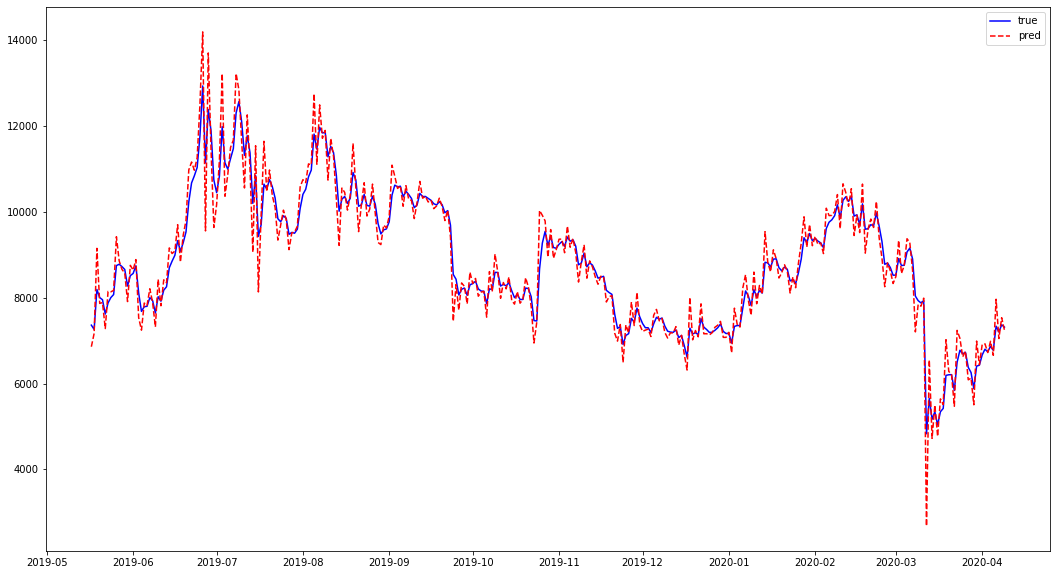

In [60]:
### MAIN

df = df_gemini_price_d.copy()
# df = df_gemini_price_1h.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

#df = df.set_index('Date')
df = df[['Date', 'Close']]
df = df.sort_values(by = ['Date']).reset_index(drop = True)

# df = df.asfreq('D') # D or H

prophet_forecast = ProphetForecast(df = df, 
                                    percentage_train_size = 0.80)
prophet_forecast.perform()

#variar os seguintes parametros:
#growth
#changepoints
#n_changepoints
#changepoint_prior_scale

In [22]:
df = df_gemini_price_d.copy()
# df = df_gemini_price_1h.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

#df = df.set_index('Date')
df = df[['Date', 'Close']]
df = df.sort_values(by = ['Date']).reset_index(drop = True)

# df['Close_transform'], fitted_lambda = boxcox(df['Close'], lmbda = None)
# df['diff_1'] = self.df['Close_transform'].diff()
# df['diff_2'] = self.df['diff_1'].diff()

df_train = df[['Date', 'Close']]
df_train.columns = ['ds', 'y']


m = Prophet(changepoint_prior_scale=30)
m.fit(df_train[:-100])
try:
    print('aic', m.aic())
except:
    print('n deu 1')
future = m.make_future_dataframe(periods=1, freq='D')

print('df_fit->\n', df_train[:-100].tail(1))
print('future->\n', future.tail(1))

forecast = m.predict(future)
print('forecast->\n', forecast.iloc[-1][['ds', 'yhat']])
print('real value->\n', df_train[:-99].tail(1))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


n deu 1
df_fit->
              ds       y
1545 2019-12-31  7165.9
future->
              ds
1546 2020-01-01
forecast->
 ds      2020-01-01 00:00:00
yhat                7775.29
Name: 1546, dtype: object
real value->
              ds       y
1546 2020-01-01  7175.2


In [36]:
# com box cox 80%
# mae 1336.6397 mape 21.7003 mse 2326690.9407 rmse 1525.3494 rmspe 28.6888 r2 -0.0128 pearson None
# com diff 2 e com box cox 80%
# mae 255.0632 mape 20.7275 mse 147270.5976 rmse 383.7585 rmspe 27.1897 r2 0.9359 pearson None
# com diff 1 e com box cox 80%
# mae 31.6397 mape 20.3164 mse 1476.5321 rmse 38.4257 rmspe 26.4608 r2 0.9994 pearson None
# https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3
# o link acima mostra como otimizar o prophet

In [61]:
class ARForecast(object):
    
    def __init__(self, df, percentage_train_size):
        
        self.df = df
        self.percentage_train_size = percentage_train_size
    
    def perform(self):
        
        best_order, last_index, best_mdl = self.create_model()
        
        array_pred = np.array([])
                
        for row in self.df.iloc[-last_index:].itertuples():
            
            pred, best_mdl = self.prediction(best_order = best_order, last_index = row[0], model = best_mdl)
            array_pred = np.append(array_pred, pred)
            print('last_index', row[0])
            print('pred', pred)
        
        print('---')
        
        y_true = self.df.iloc[-last_index:]['Close'].values
        y_pred = array_pred.reshape(-1, 1)
        print('len', len(y_true), len(y_pred)) #somente para checar
        data = {
            'y_true': self.df.iloc[-last_index:]['Close'].values,
            'y_pred': array_pred
        }
        
        df_aux = pd.DataFrame(data)
        
        mae, mape, mse, rmse, rmspe, r2, pearson = self.perform_metrics(df_aux['y_true'], df_aux['y_pred'])
        print('mae', mae,
              'mape', mape,
              'mse', mse,
              'rmse', rmse,
              'rmspe', rmspe,
              'r2', r2,
              'pearson', pearson)
        
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df.iloc[-last_index:].index, y_true, color="b", label = "true")
        ax.plot(self.df.iloc[-last_index:].index, y_pred, color="r", linestyle = '--', label = "pred")
        
    def perform_metrics(self, y_truth, y_forecasted): 

        mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
        mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
        mse = round(mean_squared_error(y_truth, y_forecasted), 4)
        rmse = round(mse**(0.5), 4)
        rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
        r2 = round(r2_score(y_truth, y_forecasted), 4)
        corr, _ = pearsonr(y_truth, y_forecasted)
        pearson = round(corr, 4)

#         print('mae', mae)
#         print('mape', mape)
#         print('mse', mse)
#         print('rmse', rmse)
#         print('rmspe', rmspe)
#         print('r2', r2)
#         print('pearson', pearson)
    
        return mae, mape, mse, rmse, rmspe, r2, pearson
    
    def prediction(self, best_order, last_index, model):
        
#         mod = sm.tsa.statespace.SARIMAX(self.df[:last_index],
#                                         order=(best_order[0], best_order[1], best_order[2]),
#                                         seasonal_order=(0, 0, 0, 0),
#                                         enforce_stationarity=False,
#                                         enforce_invertibility=False)
#         results = mod.fit()
#         pred = results.forecast(steps = 1)
        train_index = (last_index - pd.Timedelta(days = 1)).strftime('%Y-%m-%d')
    
        model = pm.ARIMA(order = best_order) #enforce_stationarity = False
        model = model.fit(self.df[:train_index])
        
#         model = model.update(self.df[last_index:last_index])
        
        print(self.df[last_index:last_index])
        pred = model.predict(n_periods = 1, alpha = 0.05)[-1]
            
        return pred, model
    
    def create_model(self):
        
        last_index = int(len(self.df)*(1 - self.percentage_train_size))
        
        best_aic = np.inf 
        best_order = None
        best_mdl = None

        p_rng = range(6)
        d_rng = range(3) # [0,1,2]
        for d in d_rng:
            for p in p_rng:
                try:
                    mod = pm.ARIMA(order=(p, d, 0))

                    results = mod.fit(self.df.iloc[:last_index])

                    tmp_aic = results.aic()
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (p, d, 0)
                        best_mdl = mod #não esta sendo utilizado
                except: continue
        
#         model = pm.auto_arima(self.df.iloc[:-last_index],
#                               start_p = 0,
#                               start_q = 0, 
#                               start_d = 0, 
#                               max_p = 5,
#                               max_d = 2,
#                               max_q = 0,
#                               seasonal=False)

#         best_aic = model.aic()
#         best_order = model.order #não esta sendo utilizado
#         best_mdl = model
        
        
        print('aic: %6.2f | order: %s'%(best_aic, best_order))

        return best_order, last_index, best_mdl
    




aic: 2741.47 | order: (0, 1, 0)
              Close
Date               
2019-05-17  7361.92
last_index 2019-05-17 00:00:00
pred 7887.183518237082
              Close
Date               
2019-05-18  7262.52
last_index 2019-05-18 00:00:00
pred 7367.324684889902
              Close
Date               
2019-05-19  8192.44
last_index 2019-05-19 00:00:00
pred 7267.845166919576
              Close
Date               
2019-05-20  8003.97
last_index 2019-05-20 00:00:00
pred 8198.466148597423
              Close
Date               
2019-05-21  7954.49
last_index 2019-05-21 00:00:00
pred 8009.848803030304
             Close
Date              
2019-05-22  7620.0
last_index 2019-05-22 00:00:00
pred 7960.326896290689
              Close
Date               
2019-05-23  7879.92
last_index 2019-05-23 00:00:00
pred 7625.5794629349475
              Close
Date               
2019-05-24  8004.36
last_index 2019-05-24 00:00:00
pred 7885.691708238851
              Close
Date               
2019-05-25  8074.8

              Close
Date               
2019-07-29  9504.23
last_index 2019-07-29 00:00:00
pred 9530.100683945284
              Close
Date               
2019-07-30  9599.07
last_index 2019-07-30 00:00:00
pred 9510.892071942446
               Close
Date                
2019-07-31  10079.54
last_index 2019-07-31 00:00:00
pred 9605.795463695184
               Close
Date                
2019-08-01  10409.99
last_index 2019-08-01 00:00:00
pred 10086.605797413795
               Close
Date                
2019-08-02  10528.81
last_index 2019-08-02 00:00:00
pred 10417.287946877243
               Close
Date                
2019-08-03  10817.34
last_index 2019-08-03 00:00:00
pred 10536.18794835007
              Close
Date               
2019-08-04  10975.0
last_index 2019-08-04 00:00:00
pred 10824.919491039427
               Close
Date                
2019-08-05  11815.28
last_index 2019-08-05 00:00:00
pred 10982.686998567335
               Close
Date                
2019-08-06  11464.34
last_i

              Close
Date               
2019-10-09  8592.01
last_index 2019-10-09 00:00:00
pred 8193.607522245038
              Close
Date               
2019-10-10  8589.51
last_index 2019-10-10 00:00:00
pred 8597.720027359781
              Close
Date               
2019-10-11  8272.76
last_index 2019-10-11 00:00:00
pred 8595.214415584416
              Close
Date               
2019-10-12  8314.22
last_index 2019-10-12 00:00:00
pred 8278.244159836066
              Close
Date               
2019-10-13  8275.99
last_index 2019-10-13 00:00:00
pred 8319.728716723548
              Close
Date               
2019-10-14  8355.87
last_index 2019-10-14 00:00:00
pred 8281.468881309685
              Close
Date               
2019-10-15  8162.95
last_index 2019-10-15 00:00:00
pred 8361.399597818678
              Close
Date               
2019-10-16  8002.22
last_index 2019-10-16 00:00:00
pred 8168.344414168937
              Close
Date               
2019-10-17  8074.43
last_index 2019-10-17 00:00:

              Close
Date               
2019-12-23  7316.57
last_index 2019-12-23 00:00:00
pred 7517.852532552083
              Close
Date               
2019-12-24  7260.75
last_index 2019-12-24 00:00:00
pred 7321.171574495771
             Close
Date              
2019-12-25  7192.6
last_index 2019-12-25 00:00:00
pred 7265.312288686606
              Close
Date               
2019-12-26  7195.83
last_index 2019-12-26 00:00:00
pred 7197.115042235218
              Close
Date               
2019-12-27  7241.66
last_index 2019-12-27 00:00:00
pred 7200.344207792207
             Close
Date              
2019-12-28  7300.7
last_index 2019-12-28 00:00:00
pred 7246.201018818949
              Close
Date               
2019-12-29  7390.42
last_index 2019-12-29 00:00:00
pred 7305.2763618677045
              Close
Date               
2019-12-30  7216.27
last_index 2019-12-30 00:00:00
pred 7395.0515424497735
             Close
Date              
2019-12-31  7165.9
last_index 2019-12-31 00:00:00
pred

              Close
Date               
2020-03-05  9067.35
last_index 2020-03-05 00:00:00
pred 8762.340926041019
              Close
Date               
2020-03-06  9158.02
last_index 2020-03-06 00:00:00
pred 9072.830372670807
              Close
Date               
2020-03-07  8902.65
last_index 2020-03-07 00:00:00
pred 9163.553252638114
              Close
Date               
2020-03-08  8038.84
last_index 2020-03-08 00:00:00
pred 8908.021401985112
              Close
Date               
2020-03-09  7932.95
last_index 2020-03-09 00:00:00
pred 8043.672541847489
              Close
Date               
2020-03-10  7881.02
last_index 2020-03-10 00:00:00
pred 7937.713940520446
              Close
Date               
2020-03-11  7935.49
last_index 2020-03-11 00:00:00
pred 7885.748835913313
              Close
Date               
2020-03-12  4830.45
last_index 2020-03-12 00:00:00
pred 7940.249616336633
              Close
Date               
2020-03-13  5653.03
last_index 2020-03-13 00:00:

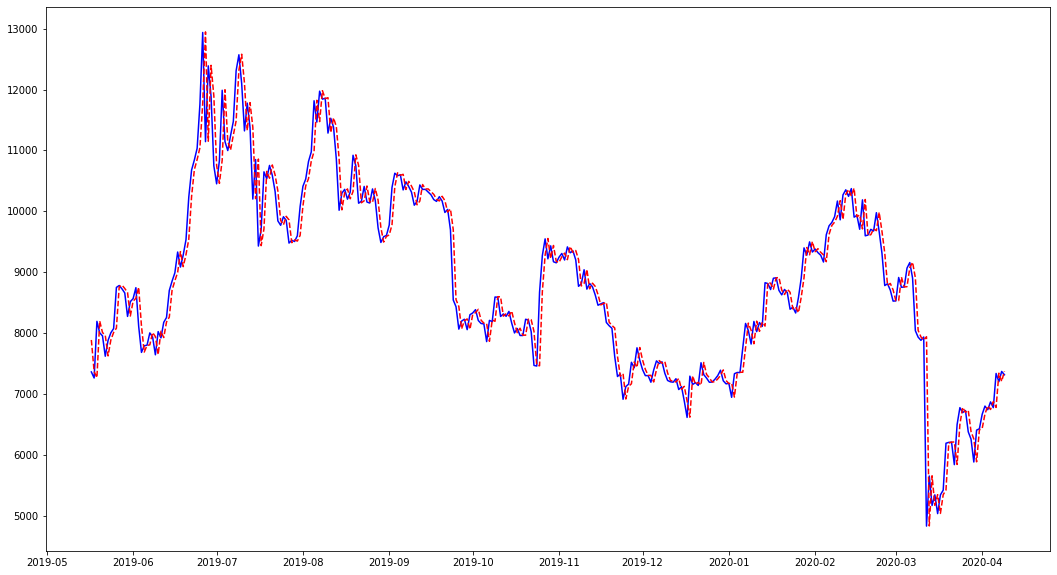

In [62]:
### MAIN

df = df_gemini_price_d.copy()
# df = df_gemini_price_1h.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

df = df.set_index('Date')
df = df.loc[:, ['Close']]
df = df.sort_values(by = ['Date'])
df = df.asfreq('D') # D or H

ar_forecast = ARForecast(df = df, 
                               percentage_train_size = 0.80)
ar_forecast.perform()

In [ ]:
# aic: 2741.47 | order: (0, 1, 0)
# mae 257.194 mape 2.977 mse 161037.766 rmse 401.2951 rmspe 5.3356 r2 0.9299 pearson 0.965

In [63]:
class MAForecast(object):
    
    def __init__(self, df, percentage_train_size):
        
        self.df = df
        self.percentage_train_size = percentage_train_size
    
    def perform(self):
        
        best_order, last_index, best_mdl = self.create_model()
        
        array_pred = np.array([])
                
        for row in self.df.iloc[-last_index:].itertuples():
            
            pred, best_mdl = self.prediction(best_order = best_order, last_index = row[0], model = best_mdl)
            array_pred = np.append(array_pred, pred)
            print('last_index', row[0])
            print('pred', pred)
        
        print('---')
        
        y_true = self.df.iloc[-last_index:]['Close'].values
        y_pred = array_pred.reshape(-1, 1)
        print('len', len(y_true), len(y_pred)) #somente para checar
        data = {
            'y_true': self.df.iloc[-last_index:]['Close'].values,
            'y_pred': array_pred
        }
        
        df_aux = pd.DataFrame(data)
        
        mae, mape, mse, rmse, rmspe, r2, pearson = self.perform_metrics(df_aux['y_true'], df_aux['y_pred'])
        print('mae', mae,
              'mape', mape,
              'mse', mse,
              'rmse', rmse,
              'rmspe', rmspe,
              'r2', r2,
              'pearson', pearson)
        
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df.iloc[-last_index:].index, y_true, color="b", label = "true")
        ax.plot(self.df.iloc[-last_index:].index, y_pred, color="r", linestyle = '--', label = "pred")
        
    def perform_metrics(self, y_truth, y_forecasted): 

        mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
        mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
        mse = round(mean_squared_error(y_truth, y_forecasted), 4)
        rmse = round(mse**(0.5), 4)
        rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
        r2 = round(r2_score(y_truth, y_forecasted), 4)
        corr, _ = pearsonr(y_truth, y_forecasted)
        pearson = round(corr, 4)

#         print('mae', mae)
#         print('mape', mape)
#         print('mse', mse)
#         print('rmse', rmse)
#         print('rmspe', rmspe)
#         print('r2', r2)
#         print('pearson', pearson)
    
        return mae, mape, mse, rmse, rmspe, r2, pearson
    
    def prediction(self, best_order, last_index, model):
        
#         mod = sm.tsa.statespace.SARIMAX(self.df[:last_index],
#                                         order=(best_order[0], best_order[1], best_order[2]),
#                                         seasonal_order=(0, 0, 0, 0),
#                                         enforce_stationarity=False,
#                                         enforce_invertibility=False)
#         results = mod.fit()
#         pred = results.forecast(steps = 1)
        train_index = (last_index - pd.Timedelta(days = 1)).strftime('%Y-%m-%d')
        model = pm.ARIMA(order = best_order) #enforce_stationarity = False
        model = model.fit(self.df[:train_index])
        
#         model = model.update(self.df[last_index:last_index])
        
        print(self.df[last_index:last_index])
        pred = model.predict(n_periods = 1, alpha = 0.05)[-1]
            
        return pred, model
    
    def create_model(self):
        
        last_index = int(len(self.df)*(1 - self.percentage_train_size))
        
        best_aic = np.inf 
        best_order = None
        best_mdl = None

        q_rng = range(6)
        d_rng = range(3) # [0,1,2]
        for d in d_rng:
            for q in q_rng:
                try:
                    mod = pm.ARIMA(order=(0, d, q))

                    results = mod.fit(self.df.iloc[:last_index])

                    tmp_aic = results.aic()
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (0, d, q)
                        best_mdl = mod #não esta sendo utilizado
                except: continue

#         model = pm.auto_arima(self.df.iloc[:-last_index],
#                               start_p = 0,
#                               start_d = 0, 
#                               start_q = 0, 
#                               max_p = 0,
#                               max_d = 2,
#                               max_q = 5,
#                               seasonal=False)

#         best_aic = model.aic()
#         best_order = model.order #não esta sendo utilizado
#         best_mdl = model
        
        
        print('aic: %6.2f | order: %s'%(best_aic, best_order))

        return best_order, last_index, best_mdl
    




aic: 2741.27 | order: (0, 2, 5)
              Close
Date               
2019-05-17  7361.92
last_index 2019-05-17 00:00:00
pred 7816.377098556441
              Close
Date               
2019-05-18  7262.52
last_index 2019-05-18 00:00:00
pred 7344.797826390846
              Close
Date               
2019-05-19  8192.44
last_index 2019-05-19 00:00:00
pred 7244.1224979269045
              Close
Date               
2019-05-20  8003.97
last_index 2019-05-20 00:00:00
pred 8272.240830904155
              Close
Date               
2019-05-21  7954.49
last_index 2019-05-21 00:00:00
pred 8002.394205644417
             Close
Date              
2019-05-22  7620.0
last_index 2019-05-22 00:00:00
pred 7989.483586214447
              Close
Date               
2019-05-23  7879.92
last_index 2019-05-23 00:00:00
pred 7547.314188957671
              Close
Date               
2019-05-24  8004.36
last_index 2019-05-24 00:00:00
pred 7924.546106970508
              Close
Date               
2019-05-25  8074.8

             Close
Date              
2019-07-27  9478.3
last_index 2019-07-27 00:00:00
pred 9884.219520277387
              Close
Date               
2019-07-28  9523.42
last_index 2019-07-28 00:00:00
pred 9489.134839603119
              Close
Date               
2019-07-29  9504.23
last_index 2019-07-29 00:00:00
pred 9537.617351776822
              Close
Date               
2019-07-30  9599.07
last_index 2019-07-30 00:00:00
pred 9498.530506689665
               Close
Date                
2019-07-31  10079.54
last_index 2019-07-31 00:00:00
pred 9637.628700761992
               Close
Date                
2019-08-01  10409.99
last_index 2019-08-01 00:00:00
pred 10094.995671196386
               Close
Date                
2019-08-02  10528.81
last_index 2019-08-02 00:00:00
pred 10422.654683555913
               Close
Date                
2019-08-03  10817.34
last_index 2019-08-03 00:00:00
pred 10547.168386891908
              Close
Date               
2019-08-04  10975.0
last_index 2019-

              Close
Date               
2019-10-06  7860.01
last_index 2019-10-06 00:00:00
pred 8144.640798645678
              Close
Date               
2019-10-07  8208.67
last_index 2019-10-07 00:00:00
pred 7864.813205671917
              Close
Date               
2019-10-08  8188.17
last_index 2019-10-08 00:00:00
pred 8229.65168761538
              Close
Date               
2019-10-09  8592.01
last_index 2019-10-09 00:00:00
pred 8171.202779557724
              Close
Date               
2019-10-10  8589.51
last_index 2019-10-10 00:00:00
pred 8636.130720683963
              Close
Date               
2019-10-11  8272.76
last_index 2019-10-11 00:00:00
pred 8566.36764756889
              Close
Date               
2019-10-12  8314.22
last_index 2019-10-12 00:00:00
pred 8291.982704002821
              Close
Date               
2019-10-13  8275.99
last_index 2019-10-13 00:00:00
pred 8305.453105231622
              Close
Date               
2019-10-14  8355.87
last_index 2019-10-14 00:00:00

              Close
Date               
2019-12-18  7292.61
last_index 2019-12-18 00:00:00
pred 6624.428695335279
             Close
Date              
2019-12-19  7155.0
last_index 2019-12-19 00:00:00
pred 7306.396071885772
              Close
Date               
2019-12-20  7186.87
last_index 2019-12-20 00:00:00
pred 7137.894960057059
              Close
Date               
2019-12-21  7140.34
last_index 2019-12-21 00:00:00
pred 7229.270136614627
              Close
Date               
2019-12-22  7513.12
last_index 2019-12-22 00:00:00
pred 7100.438741794296
              Close
Date               
2019-12-23  7316.57
last_index 2019-12-23 00:00:00
pred 7536.0651241243195
              Close
Date               
2019-12-24  7260.75
last_index 2019-12-24 00:00:00
pred 7297.26166444576
             Close
Date              
2019-12-25  7192.6
last_index 2019-12-25 00:00:00
pred 7285.138120456968
              Close
Date               
2019-12-26  7195.83
last_index 2019-12-26 00:00:00
pre

              Close
Date               
2020-02-29  8525.13
last_index 2020-02-29 00:00:00
pred 8702.774624767468
             Close
Date              
2020-03-01  8528.4
last_index 2020-03-01 00:00:00
pred 8552.154134875856
              Close
Date               
2020-03-02  8912.92
last_index 2020-03-02 00:00:00
pred 8528.829435641608
              Close
Date               
2020-03-03  8751.88
last_index 2020-03-03 00:00:00
pred 8924.248411638164
              Close
Date               
2020-03-04  8757.05
last_index 2020-03-04 00:00:00
pred 8752.08927351029
              Close
Date               
2020-03-05  9067.35
last_index 2020-03-05 00:00:00
pred 8778.297874809236
              Close
Date               
2020-03-06  9158.02
last_index 2020-03-06 00:00:00
pred 9055.738621774432
              Close
Date               
2020-03-07  8902.65
last_index 2020-03-07 00:00:00
pred 9166.540034247722
              Close
Date               
2020-03-08  8038.84
last_index 2020-03-08 00:00:00
p

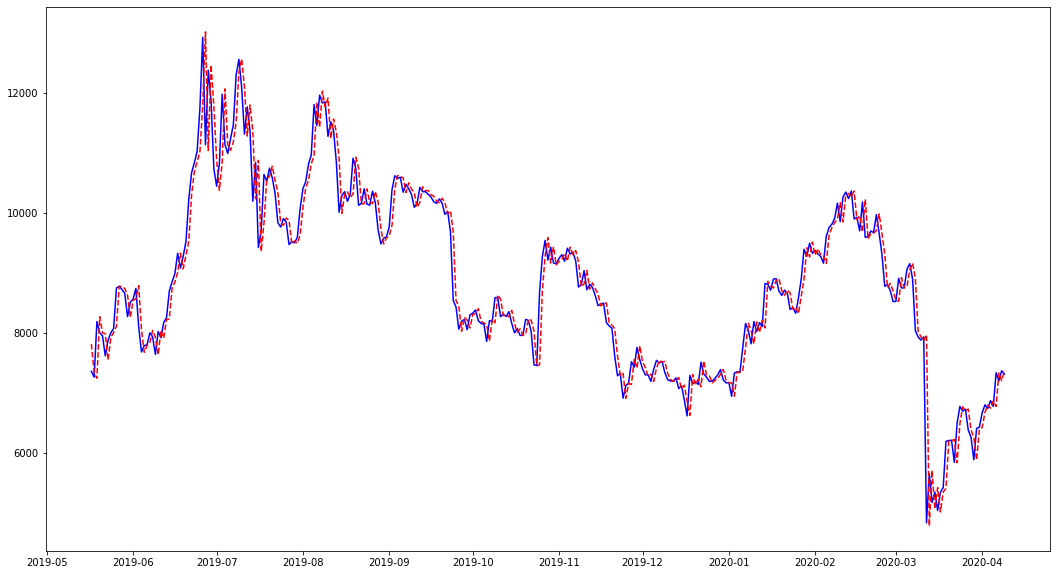

In [64]:
### MAIN

df = df_gemini_price_d.copy()
# df = df_gemini_price_1h.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

df = df.set_index('Date')
df = df.loc[:, ['Close']]
df = df.sort_values(by = ['Date'])
df = df.asfreq('D') # D or H

ma_forecast = MAForecast(df = df, 
                               percentage_train_size = 0.80)
ma_forecast.perform()

In [66]:
# aic: 2741.27 | order: (0, 2, 5)
# mae 260.6208 mape 3.0221 mse 165087.962 rmse 406.3102 rmspe 5.4113 r2 0.9281 pearson 0.9642

In [8]:
# class MSARForecast(object):
    
#     def __init__(self, df, percentage_train_size):
        
#         self.df = df
#         self.percentage_train_size = percentage_train_size
    
#     def perform(self):
        
#         best_order, last_index, best_mdl = self.create_model()
        
#         array_pred = np.array([])
                
#         for row in self.df.iloc[-last_index:].itertuples():
            
#             pred, best_mdl = self.prediction(best_order = best_order, last_index = row[0], model = best_mdl)
#             array_pred = np.append(array_pred, pred)
#             print('last_index', row[0])
#             print('pred', pred)
        
#         print('---')
        
#         y_true = self.df.iloc[-last_index:]['Close'].values
#         y_pred = array_pred.reshape(-1, 1)
#         print('len', len(y_true), len(y_pred)) #somente para checar
#         data = {
#             'y_true': self.df.iloc[-last_index:]['Close'].values,
#             'y_pred': array_pred
#         }
        
#         df_aux = pd.DataFrame(data)
        
#         mae, mape, mse, rmse, rmspe, r2, pearson = self.perform_metrics(df_aux['y_true'], df_aux['y_pred'])
#         print('mae', mae,
#               'mape', mape,
#               'mse', mse,
#               'rmse', rmse,
#               'rmspe', rmspe,
#               'r2', r2,
#               'pearson', pearson)
        
#         fig, ax = plt.subplots(figsize=(18, 10))
#         ax.plot(self.df.iloc[-last_index:].index, y_true, color="b", label = "true")
#         ax.plot(self.df.iloc[-last_index:].index, y_pred, color="r", linestyle = '--', label = "pred")
        
#     def perform_metrics(self, y_truth, y_forecasted): 

#         mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
#         mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
#         mse = round(mean_squared_error(y_truth, y_forecasted), 4)
#         rmse = round(mse**(0.5), 4)
#         rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
#         r2 = round(r2_score(y_truth, y_forecasted), 4)
#         corr, _ = pearsonr(y_truth, y_forecasted)
#         pearson = round(corr, 4)

# #         print('mae', mae)
# #         print('mape', mape)
# #         print('mse', mse)
# #         print('rmse', rmse)
# #         print('rmspe', rmspe)
# #         print('r2', r2)
# #         print('pearson', pearson)
    
#         return mae, mape, mse, rmse, rmspe, r2, pearson
    
#     def prediction(self, best_order, last_index, model):
        
#         if best_order[1] == 0:
#             df_train = self.df.loc[:, ['Close']]
# #             df_train = df_train.dropna()
# #             df_train = df_train.asfreq('d')
#         if best_order[1] == 1:
#             df_train = self.df.loc[:, ['diff_1']].dropna()
# #             df_train = df_train.dropna()
# #             df_train = df_train.asfreq('d')
#         if best_order[1] == 2:
#             df_train = self.df.loc[:, ['diff_2']].dropna()
# #             df_train = df_train.dropna()
# #             df_train = df_train.asfreq('d')
    
#         start = last_index.strftime('%Y-%m-%d')
#         end = (last_index + pd.Timedelta(days = 1)).strftime('%Y-%m-%d')
#         print('start', start)
#         print('end', end)

#         df_train = df_train[:last_index]
        
#         print('last_index', last_index)
#         print("df_train pred", df_train.index)
#         print("df_train info\n", df_train.info())
#         print("df_train na sum\n", df_train.isna().sum())
        
#         mod_hamilton = sm.tsa.MarkovAutoregression(df_train, k_regimes=2, order=best_order[0], switching_ar=True)
#         res_hamilton = mod_hamilton.fit()
#         print('pass 2')
# #         df_train = df_train.reset_index(drop=True)
# #         start = df_train.index[-1]
# #         end = start + 1
# #         print('start', start)
# #         print('end', end)
#         pred = res_hamilton.predict(start = start, end = end)[-1]
        
#         print(self.df[last_index:last_index])
        
#         print('last_row.values[0]', last_row.values[0])
#         print('pred 1', pred)
#         pred = last_row.values[0] + pred
    
#         return pred, model
    
#     def create_model(self):
        
#         last_index = int(len(self.df)*(1 - self.percentage_train_size))
        
#         best_aic = np.inf 
#         best_order = None
#         best_mdl = None

#         p_rng = range(1, 5)
#         d_rng = range(3) # [0,1,2]
        
#         for d in d_rng:
            
#             if d == 0:
#                 df_train = self.df.loc[:, ['Close']].dropna()
# #                 df_train = df_train.asfreq('d')
#             if d == 1:
#                 df_train = self.df.loc[:, ['diff_1']].dropna()
# #                 df_train = df_train.asfreq('d')
#             if d == 2:
#                 df_train = self.df.loc[:, ['diff_2']].dropna()
# #                 df_train = df_train.asfreq('d')
#             print('df_train', df_train.index)
#             for p in p_rng:
#                 try:
#                     mod = sm.tsa.MarkovAutoregression(df_train.iloc[:last_index], k_regimes=2, order=p, switching_ar=True)
#                     results = mod.fit()
#                     tmp_aic = results.aic
    
#                     if tmp_aic < best_aic:
#                         best_aic = tmp_aic
#                         best_order = (p, d)
#                         best_mdl = mod #não esta sendo utilizado
#                         print('best_order', best_order) #apagar dps
#                 except: continue        
        
#         print('aic: %6.2f | order: %s'%(best_aic, best_order))

#         return best_order, last_index, best_mdl

In [33]:
# ### MAIN

# df = df_gemini_price_d.copy()
# # df = df_gemini_price_1h.copy()

# df['Date'] = pd.to_datetime(df['Date'])
# #print('null\n', df.isnull().sum())

# df = df.set_index('Date')
# df = df.loc[:, ['Close']]
# df = df.sort_values(by = ['Date'])

# #fazendo a serie ser estacionaria 
# df['diff_1'] = df['Close'].diff()
# df['diff_2'] = df['diff_1'].diff()
# df = df.asfreq('d')

# msar_forecast = MSARForecast(df = df, 
#                              percentage_train_size = 0.98)
# msar_forecast.perform()

#NÂO POSSUI O PREDICT OUT OF SAMPLE IMPLEMENTADO

In [12]:
#fazer uma tabela com resultados 

In [47]:
class NaiveForecast(object):
    
    def __init__(self, df, percentage_train_size):
        
        self.df = df
        self.percentage_train_size = percentage_train_size
    
    def perform(self):
        
        last_index = self.find_valid_last_index()
        
        array_pred = np.array([])

        for row in self.df.iloc[-last_index:].itertuples():
            
            pred = self.prediction(last_index = row[0])
            array_pred = np.append(array_pred, pred)
            print('last_index->', row[0])
            print('pred->\n', pred)
        
        print('---')
        
        y_true = self.df.iloc[-last_index:]['Close'].values
        y_pred = array_pred.reshape(-1, 1)
        print('len', len(y_true), len(y_pred)) #somente para checar
        data = {
            'y_true': self.df.iloc[-last_index:]['Close'].values,
            'y_pred': array_pred
        }
        
        df_aux = pd.DataFrame(data)
        
        mae, mape, mse, rmse, rmspe, r2, pearson = self.perform_metrics(df_aux['y_true'], df_aux['y_pred'])
        print('mae', mae,
              'mape', mape,
              'mse', mse,
              'rmse', rmse,
              'rmspe', rmspe,
              'r2', r2,
              'pearson', pearson)
        
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df.iloc[-last_index:].index, y_true, color="b", label = "true")
        ax.plot(self.df.iloc[-last_index:].index, y_pred, color="r", linestyle = '--', label = "pred")
        ax.legend()
        
    def perform_metrics(self, y_truth, y_forecasted): 

        mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
        mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
        mse = round(mean_squared_error(y_truth, y_forecasted), 4)
        rmse = round(mse**(0.5), 4)
        rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
        r2 = round(r2_score(y_truth, y_forecasted), 4)
        try:
            corr, _ = pearsonr(y_truth, y_forecasted)
            pearson = round(corr, 4)
        except:
            pearson = None
    
        return mae, mape, mse, rmse, rmspe, r2, pearson
    
    def prediction(self, last_index):
        
        last_index -= pd.Timedelta(days = 1)
        pred = self.df[last_index:last_index]['Close']
        
        return pred
    
    def find_valid_last_index(self):
        
        last_index = int(len(self.df)*(1 - self.percentage_train_size))
        
        return last_index

last_index-> 2019-05-17 00:00:00
pred->
 Date
2019-05-16    7881.38
Freq: D, Name: Close, dtype: float64
last_index-> 2019-05-18 00:00:00
pred->
 Date
2019-05-17    7361.92
Freq: D, Name: Close, dtype: float64
last_index-> 2019-05-19 00:00:00
pred->
 Date
2019-05-18    7262.52
Freq: D, Name: Close, dtype: float64
last_index-> 2019-05-20 00:00:00
pred->
 Date
2019-05-19    8192.44
Freq: D, Name: Close, dtype: float64
last_index-> 2019-05-21 00:00:00
pred->
 Date
2019-05-20    8003.97
Freq: D, Name: Close, dtype: float64
last_index-> 2019-05-22 00:00:00
pred->
 Date
2019-05-21    7954.49
Freq: D, Name: Close, dtype: float64
last_index-> 2019-05-23 00:00:00
pred->
 Date
2019-05-22    7620.0
Freq: D, Name: Close, dtype: float64
last_index-> 2019-05-24 00:00:00
pred->
 Date
2019-05-23    7879.92
Freq: D, Name: Close, dtype: float64
last_index-> 2019-05-25 00:00:00
pred->
 Date
2019-05-24    8004.36
Freq: D, Name: Close, dtype: float64
last_index-> 2019-05-26 00:00:00
pred->
 Date
2019-05-25

Freq: D, Name: Close, dtype: float64
last_index-> 2019-10-02 00:00:00
pred->
 Date
2019-10-01    8330.62
Freq: D, Name: Close, dtype: float64
last_index-> 2019-10-03 00:00:00
pred->
 Date
2019-10-02    8384.51
Freq: D, Name: Close, dtype: float64
last_index-> 2019-10-04 00:00:00
pred->
 Date
2019-10-03    8206.45
Freq: D, Name: Close, dtype: float64
last_index-> 2019-10-05 00:00:00
pred->
 Date
2019-10-04    8157.3
Freq: D, Name: Close, dtype: float64
last_index-> 2019-10-06 00:00:00
pred->
 Date
2019-10-05    8150.97
Freq: D, Name: Close, dtype: float64
last_index-> 2019-10-07 00:00:00
pred->
 Date
2019-10-06    7860.01
Freq: D, Name: Close, dtype: float64
last_index-> 2019-10-08 00:00:00
pred->
 Date
2019-10-07    8208.67
Freq: D, Name: Close, dtype: float64
last_index-> 2019-10-09 00:00:00
pred->
 Date
2019-10-08    8188.17
Freq: D, Name: Close, dtype: float64
last_index-> 2019-10-10 00:00:00
pred->
 Date
2019-10-09    8592.01
Freq: D, Name: Close, dtype: float64
last_index-> 2019-1

last_index-> 2020-03-04 00:00:00
pred->
 Date
2020-03-03    8751.88
Freq: D, Name: Close, dtype: float64
last_index-> 2020-03-05 00:00:00
pred->
 Date
2020-03-04    8757.05
Freq: D, Name: Close, dtype: float64
last_index-> 2020-03-06 00:00:00
pred->
 Date
2020-03-05    9067.35
Freq: D, Name: Close, dtype: float64
last_index-> 2020-03-07 00:00:00
pred->
 Date
2020-03-06    9158.02
Freq: D, Name: Close, dtype: float64
last_index-> 2020-03-08 00:00:00
pred->
 Date
2020-03-07    8902.65
Freq: D, Name: Close, dtype: float64
last_index-> 2020-03-09 00:00:00
pred->
 Date
2020-03-08    8038.84
Freq: D, Name: Close, dtype: float64
last_index-> 2020-03-10 00:00:00
pred->
 Date
2020-03-09    7932.95
Freq: D, Name: Close, dtype: float64
last_index-> 2020-03-11 00:00:00
pred->
 Date
2020-03-10    7881.02
Freq: D, Name: Close, dtype: float64
last_index-> 2020-03-12 00:00:00
pred->
 Date
2020-03-11    7935.49
Freq: D, Name: Close, dtype: float64
last_index-> 2020-03-13 00:00:00
pred->
 Date
2020-03-1

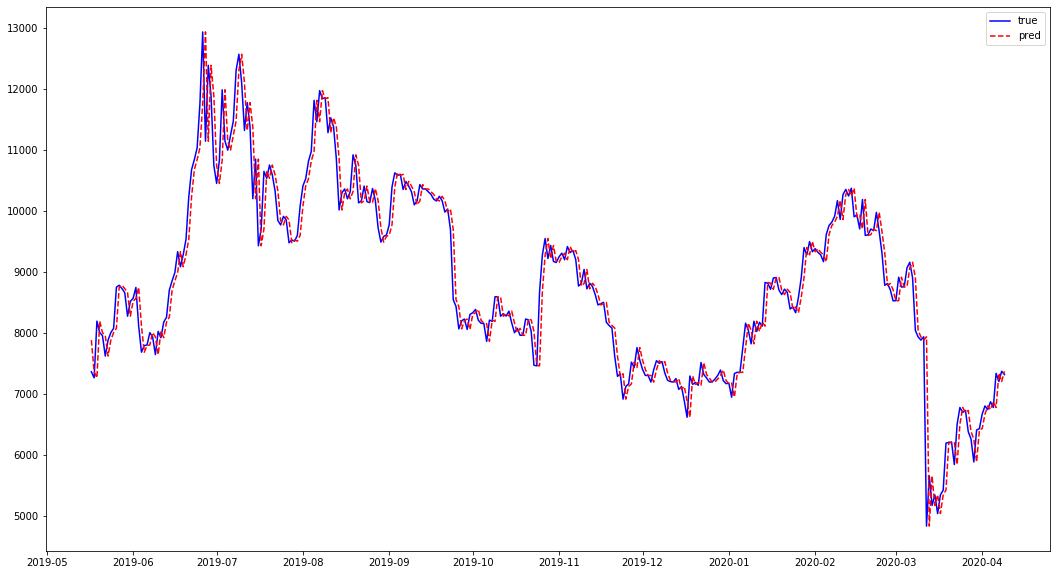

In [49]:
### MAIN

df = df_gemini_price_d.copy()
# df = df_gemini_price_1h.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

df = df.set_index('Date')
df = df.loc[:, ['Close']]
df = df.sort_values(by = ['Date'])

# #fazendo a serie ser estacionaria 
# df['diff_1'] = df['Close'].diff()
# df['diff_2'] = df['diff_1'].diff()
df = df.asfreq('d')

naive_forecast = NaiveForecast(df = df, 
                             percentage_train_size = 0.80)

naive_forecast.perform()

In [9]:
df = df_gemini_price_d.copy()
# df = df_gemini_price_1h.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

# df = df.set_index('Date')
df = df.sort_values(by = ['Date'])
df = df.loc[:, ['Close']]

In [10]:
prediction_days = 250

df_train= df[:len(df)-prediction_days]
df_test= df[len(df)-prediction_days:]

In [11]:
min_max_scaler = MinMaxScaler()
training_set = df_train.values
training_set = min_max_scaler.fit_transform(training_set)

x_train = training_set[0:len(training_set)-1]
# print('x_train 0', x_train[:10])
y_train = training_set[1:len(training_set)]
# print('y_train 0', y_train[:10])
x_train = np.reshape(x_train, (len(x_train), 1, 1)) #[samples, timesteps, features]
# print('x_train 1', x_train[:10])

In [13]:
num_units = 100
activation_function = 'sigmoid'
optimizer = 'adam'
loss_function = 'mean_squared_error'
batch_size = 1
num_epochs = 100 #100

# Initialize the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(
    LSTM(
        units = num_units, 
        activation = activation_function, 
        input_shape=(None, 1)
        )
    )

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(
    optimizer = optimizer, 
    loss = loss_function
    )

#early stop #opcional
# callbacks = [keras.callbacks.EarlyStopping(monitor='loss')]

# Using the training set to train the model
regressor.fit(x_train,
              y_train, 
              batch_size = batch_size, 
              epochs = num_epochs,
#               callbacks = callbacks
    )

Epoch 1/100
1395/1395 [==============================] - 11s 8ms/step - loss: 0.0118
Epoch 2/100
1395/1395 [==============================] - 9s 7ms/step - loss: 3.4902e-04
Epoch 3/100
1395/1395 [==============================] - 9s 6ms/step - loss: 3.8561e-04
Epoch 4/100
1395/1395 [==============================] - 8s 6ms/step - loss: 4.3119e-04
Epoch 5/100
1395/1395 [==============================] - 7s 5ms/step - loss: 4.9877e-04
Epoch 6/100
1395/1395 [==============================] - 8s 5ms/step - loss: 4.8191e-04
Epoch 7/100
1395/1395 [==============================] - 9s 6ms/step - loss: 4.8096e-04
Epoch 8/100
1395/1395 [==============================] - 9s 6ms/step - loss: 4.8558e-04
Epoch 9/100
1395/1395 [==============================] - 8s 6ms/step - loss: 4.2949e-04
Epoch 10/100
1395/1395 [==============================] - 7s 5ms/step - loss: 4.7916e-04
Epoch 11/100
1395/1395 [==============================] - 8s 6ms/step - loss: 4.4710e-04
Epoch 12/100
1395/1395 [=========

1395/1395 [==============================] - 6s 4ms/step - loss: 3.9958e-04
Epoch 94/100
1395/1395 [==============================] - 7s 5ms/step - loss: 4.3460e-04
Epoch 95/100
1395/1395 [==============================] - 10s 7ms/step - loss: 4.0314e-04
Epoch 96/100
1395/1395 [==============================] - 9s 7ms/step - loss: 3.9517e-04
Epoch 97/100
1395/1395 [==============================] - 10s 7ms/step - loss: 4.4705e-04
Epoch 98/100
1395/1395 [==============================] - 8s 6ms/step - loss: 3.8778e-04
Epoch 99/100
1395/1395 [==============================] - 9s 7ms/step - loss: 4.0596e-04
Epoch 100/100
1395/1395 [==============================] - 8s 6ms/step - loss: 4.4404e-04


In [14]:
test_set = df_test.values

inputs = np.reshape(test_set, (len(test_set), 1))
inputs = min_max_scaler.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))

predicted_price = regressor.predict(inputs)
predicted_price = min_max_scaler.inverse_transform(predicted_price)

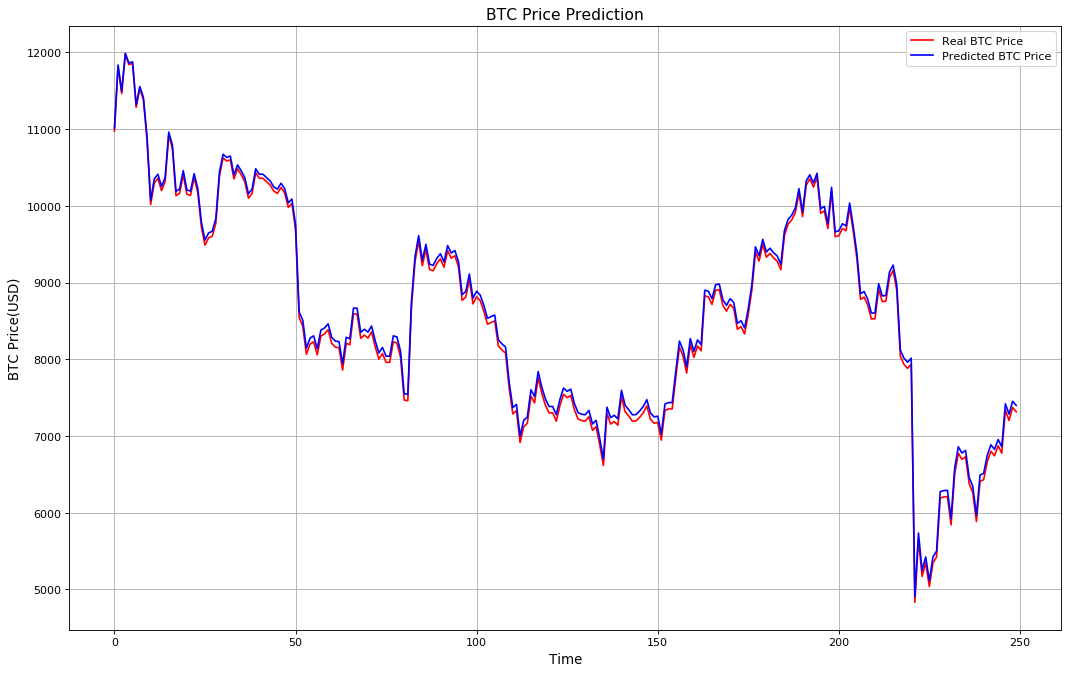

In [15]:
plt.figure(figsize=(16, 10), dpi=80, facecolor = 'w', edgecolor = 'k')

plt.plot(test_set[:, 0], color='red', label='Real BTC Price')
plt.plot(predicted_price[:, 0], color = 'blue', label = 'Predicted BTC Price')

plt.title('BTC Price Prediction', fontsize = 14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('BTC Price(USD)', fontsize = 12)
plt.legend(loc = 'best')
plt.grid(True)
plt.show()

Exemplo de LSTM com dados divididos em sequencia

In [16]:
def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test

In [21]:
df = df_gemini_price_d.copy()
# df = df_gemini_price_1h.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

# df = df.set_index('Date')
df = df.sort_values(by = ['Date'])
df = df.loc[:, ['Close']]

min_max_scaler = MinMaxScaler()
data_raw = df['Close'].values.reshape(-1, 1)
data_raw = min_max_scaler.fit_transform(data_raw)

seq_len = 50

X_train, y_train, X_test, y_test =\
preprocess(data_raw, seq_len, train_split = 0.80)

In [39]:
num_units = 50
activation_function = 'relu'
optimizer = 'adam'
loss_function = 'mean_squared_error'
batch_size = 20
num_epochs = 20 #100
dropout = 0.2
window_size = seq_len - 1

# Initialize the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(
    LSTM(
        units = num_units, 
        activation = activation_function, 
        input_shape=(window_size, 1)
        )
    )

# Adding the dropout layer
# regressor.add(Dropout(rate = dropout))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(
    optimizer = optimizer, 
    loss = loss_function
    )

#early stop #opcional
# callbacks = [keras.callbacks.EarlyStopping(monitor='loss')]

# Using the training set to train the model
history = regressor.fit(X_train,
                        y_train, 
                        batch_size = batch_size, 
                        epochs = num_epochs
#               callbacks = callbacks
)

Epoch 1/20
1276/1276 [==============================] - 8s 6ms/step - loss: 0.0138 - mean_squared_error: 0.0138
Epoch 2/20
1276/1276 [==============================] - 6s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 3/20
1276/1276 [==============================] - 5s 4ms/step - loss: 9.7043e-04 - mean_squared_error: 9.7043e-04
Epoch 4/20
1276/1276 [==============================] - 6s 5ms/step - loss: 8.4142e-04 - mean_squared_error: 8.4142e-04
Epoch 5/20
1276/1276 [==============================] - 6s 5ms/step - loss: 7.8070e-04 - mean_squared_error: 7.8070e-04
Epoch 6/20
1276/1276 [==============================] - 6s 4ms/step - loss: 7.2211e-04 - mean_squared_error: 7.2211e-04
Epoch 7/20
1276/1276 [==============================] - 6s 5ms/step - loss: 6.9535e-04 - mean_squared_error: 6.9535e-04
Epoch 8/20
1276/1276 [==============================] - 7s 6ms/step - loss: 6.4837e-04 - mean_squared_error: 6.4837e-04
Epoch 9/20
1276/1276 [==============================] - 

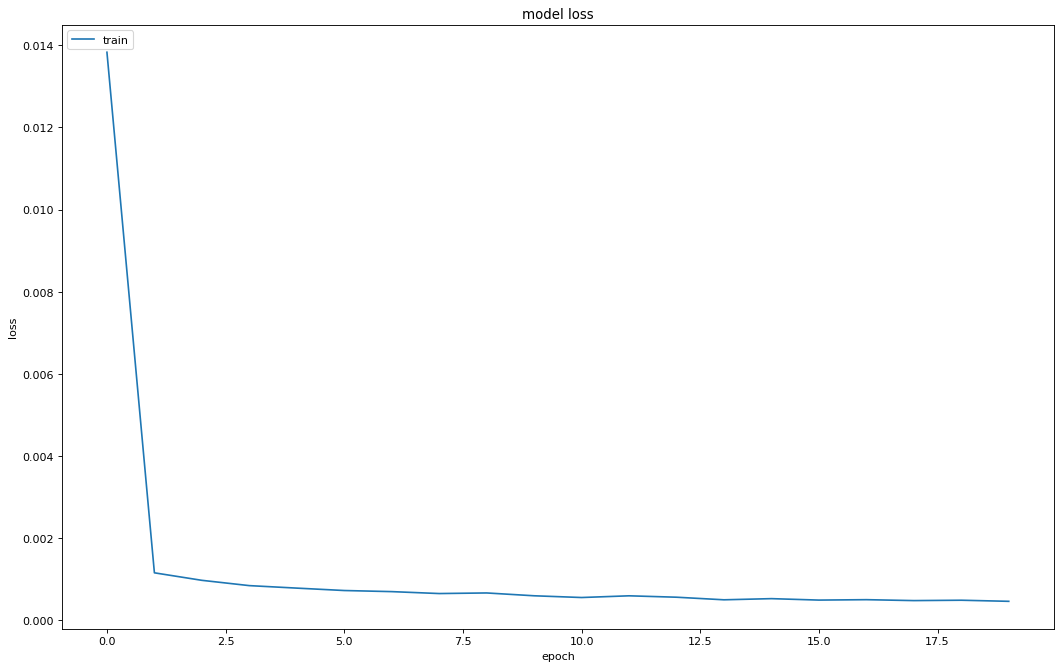

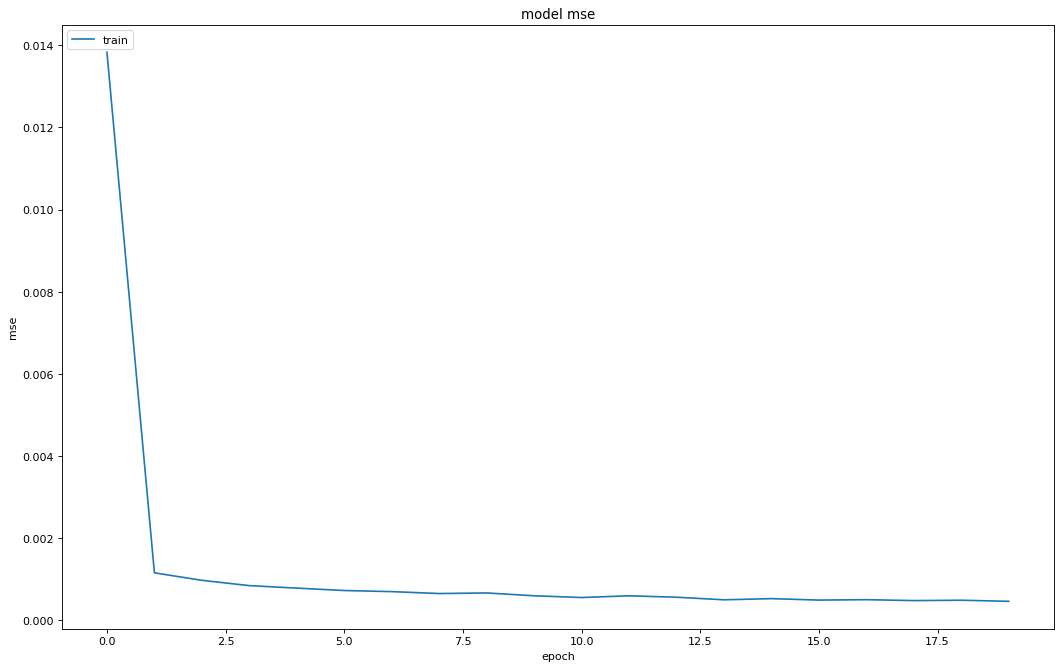

In [40]:
plt.figure(figsize=(16, 10), dpi=80, facecolor = 'w', edgecolor = 'k')

plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 10), dpi=80, facecolor = 'w', edgecolor = 'k')

plt.plot(history.history['mean_squared_error'])
# plt.plot(history.history['val_loss'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
regressor.evaluate(X_test, y_test)

320/320 [==============================] - 1s 4ms/step


[0.0006926000205567107, 0.0006926000351086259]

In [42]:
regressor.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [43]:
y_hat = regressor.predict(X_test)

y_test_inverse = min_max_scaler.inverse_transform(y_test)
y_hat_inverse = min_max_scaler.inverse_transform(y_hat)

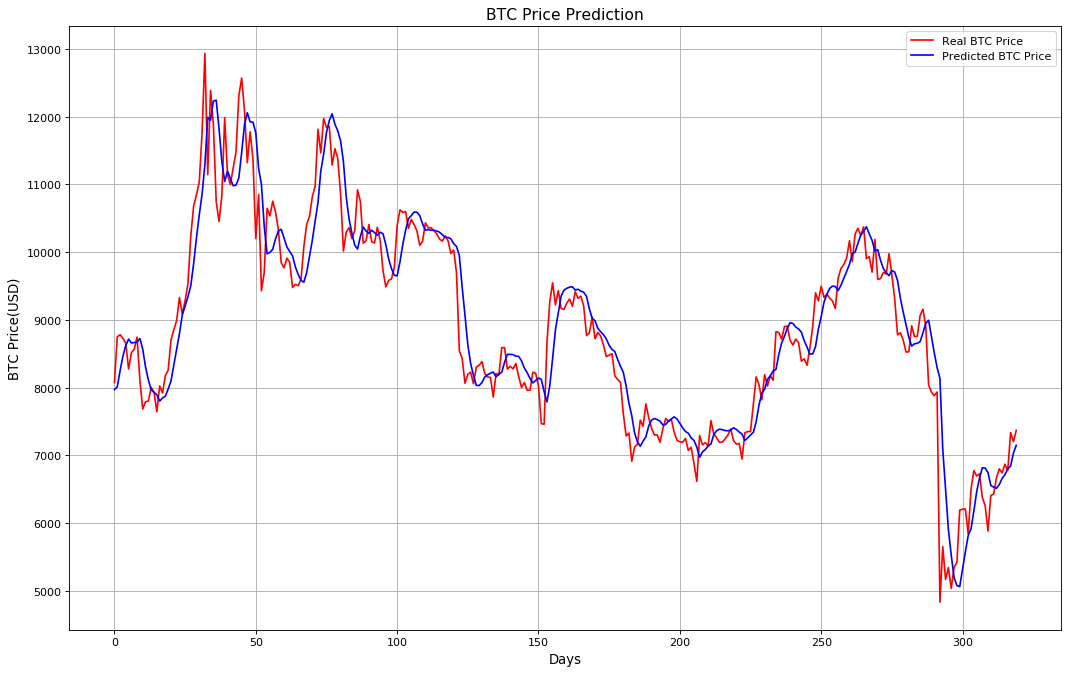

In [44]:
plt.figure(figsize=(16, 10), dpi=80, facecolor = 'w', edgecolor = 'k')

plt.plot(y_test_inverse[:, 0], color='red', label='Real BTC Price')
plt.plot(y_hat_inverse[:, 0], color = 'blue', label = 'Predicted BTC Price')

plt.title('BTC Price Prediction', fontsize = 14)
plt.xlabel('Days', fontsize=12)
plt.ylabel('BTC Price(USD)', fontsize = 12)
plt.legend(loc = 'best')
plt.grid(True)
plt.show()

In [ ]:
class LSTMForecast(object):
    
    def __init__(self, df, percentage_train_size):
        
        self.df = df
        self.percentage_train_size = percentage_train_size
    
    def perform(self):
        
        best_order, last_index, best_mdl = self.create_model()
        
        array_pred = np.array([])
                
        for row in self.df.iloc[-last_index:].itertuples():
            
            pred = self.prediction(best_order = best_order, last_index = row[0], model = best_mdl)
            array_pred = np.append(array_pred, pred)
            print('last_index', row[0])
            print('pred', pred)
        
        print('---')
        
        y_true = self.df.iloc[-last_index:]['Close'].values
        y_pred = array_pred.reshape(-1, 1)
        print('len', len(y_true), len(y_pred)) #somente para checar
        data = {
            'y_true': self.df.iloc[-last_index:]['Close'].values,
            'y_pred': array_pred
        }
        
        df_aux = pd.DataFrame(data)
        
        mae, mape, mse, rmse, rmspe, r2, pearson = self.perform_metrics(df_aux['y_true'], df_aux['y_pred'])
        print('mae', mae,
              'mape', mape,
              'mse', mse,
              'rmse', rmse,
              'rmspe', rmspe,
              'r2', r2,
              'pearson', pearson)
        
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df.iloc[-last_index:].index, y_true, color="b", label = "true")
        ax.plot(self.df.iloc[-last_index:].index, y_pred, color="r", linestyle = '--', label = "pred")
        
    def perform_metrics(self, y_truth, y_forecasted): 

        mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
        mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
        mse = round(mean_squared_error(y_truth, y_forecasted), 4)
        rmse = round(mse**(0.5), 4)
        rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
        r2 = round(r2_score(y_truth, y_forecasted), 4)
        try:
            corr, _ = pearsonr(y_truth, y_forecasted)
            pearson = round(corr, 4)
        except:
            pearson = None
    
        return mae, mape, mse, rmse, rmspe, r2, pearson
    
    def prediction(self, best_order, last_index, model):
                
#         model = pm.ARIMA(order = best_order)
#         model = model.fit(self.df[:last_index])
        
#         model = model.update(self.df[last_index:last_index])
        
#         print(self.df[last_index:last_index])
#         pred = model.predict(n_periods = 1, alpha = 0.05)[-1]
            
        return pred, model
    
    def create_model(self):
        
        last_index = int(len(self.df)*(1 - self.percentage_train_size))
        
        training_set = self.df.iloc[:last_index].values
        training_set = MinMaxScaler().fit_transform(training_set)

        x_train = training_set[0:len(training_set)-1]
        y_train = training_set[1:len(training_set)]
        x_train = np.reshape(x_train, (len(x_train), 1, 1))
        
        best_order = {
            "num_units": 4,
            "activation_function": 'sigmoid',
            "optimizer": 'adam',
            "loss_function": 'mean_squared_error',
            "batch_size": 5,
            "num_epochs": 20
        }

        # Initialize the RNN
        regressor = Sequential()

        # Adding the input layer and the LSTM layer
        regressor.add(LSTM(units = best_order["num_units"], activation = best_order["activation_function"], input_shape=(None, 1)))

        # Adding the output layer
        regressor.add(Dense(units = 1))

        # Compiling the RNN
        regressor.compile(optimizer = best_order["optimizer"], loss = best_order["loss_function"])

        # Using the training set to train the model
        regressor.fit(x_train, y_train, batch_size = best_order["batch_size"], epochs = best_order["num_epochs"])
                
        return best_order, last_index, regressor

In [ ]:
### MAIN

df = df_gemini_price_d.copy()
# df = df_gemini_price_1h.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

df = df.set_index('Date')
df = df.loc[:, ['Close']]
df = df.sort_values(by = ['Date'])

# #fazendo a serie ser estacionaria 
# df['diff_1'] = df['Close'].diff()
# df['diff_2'] = df['diff_1'].diff()
df = df.asfreq('d')

lstm_forecast = LSTMForecast(df = df, 
                             percentage_train_size = 0.80)

lstm_forecast.perform()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


df head
         Date  Symbol    Open    High    Low   Close  Volume BTC  Volume USD  \
0 2015-10-08  BTCUSD  242.50  245.00  242.5  243.95       18.80     4595.84   
1 2015-10-09  BTCUSD  243.95  249.97  243.6  245.39       30.99     7651.63   
2 2015-10-10  BTCUSD  245.39  246.30  244.6  246.30       12.17     2984.44   
3 2015-10-11  BTCUSD  246.30  249.50  246.3  249.50       12.22     3021.12   
4 2015-10-12  BTCUSD  249.50  249.50  247.6  247.60       38.28     9493.89   

   diff_1  diff_2  
0     NaN     NaN  
1    1.44     NaN  
2    0.91   -0.53  
3    3.20    2.29  
4   -1.90   -5.10  
last_index-> 32
shape df train-> (1614, 2)
days ahead-> 32
df_fit->
              ds        y
1613 2020-03-08  8038.84
future->
              ds
1645 2020-04-09
forecast->
 ds      2020-04-09 00:00:00
yhat                 9460.3
Name: 1645, dtype: object
last_row->
 Empty DataFrame
Columns: [Date, Symbol, Open, High, Low, Close, Volume BTC, Volume USD, diff_1, diff_2]
Index: []


NameError: name 'predicted_price' is not defined

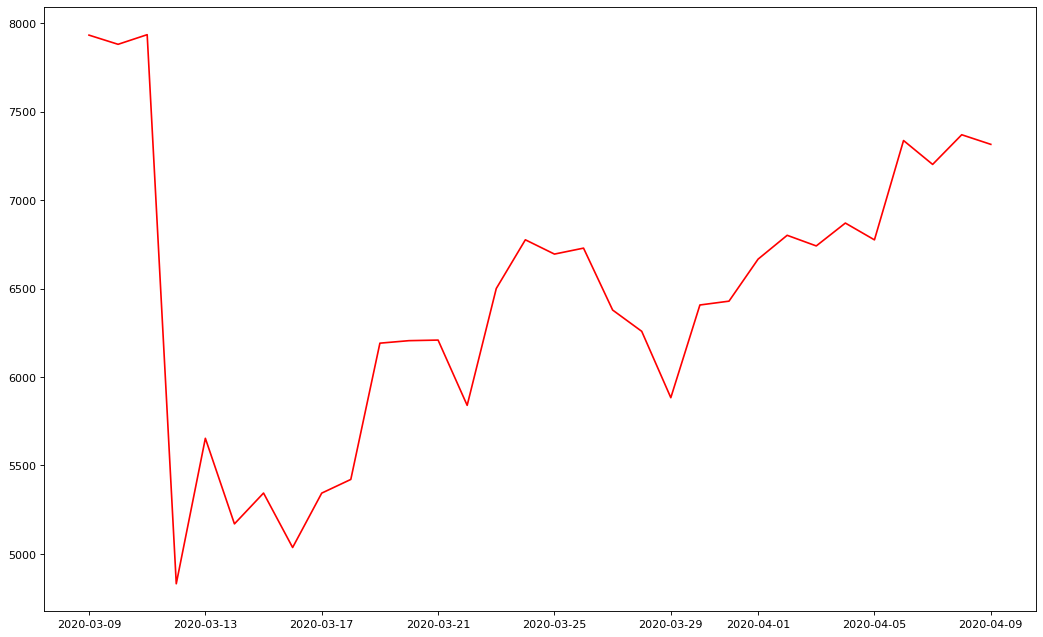

In [30]:
df = df_gemini_price_d.copy()
# df = df_gemini_price_1h.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

# df = df.set_index('Date')
# df = df.loc[:, ['Close']]
df = df.sort_values(by = ['Date']).reset_index(drop = True)
df['diff_1'] = df['Close'].diff()
df['diff_2'] = df['diff_1'].diff()
print('df head\n', df.head())
percentage_train_size = 0.98
last_index = int(len(df.index)*(1 - percentage_train_size))
print('last_index->', last_index)
model = Prophet()
#changepoint_prior_scale=0.5

df_train = df[['Date', 'Close']]
df_train.columns = ['ds', 'y']
df_teste = df_train[-last_index:]
df_train = df_train[:-last_index]
df_train = df_train[ df_train['y'] > 0 ]

days_ahead = df_teste.shape[0]
print('shape df train->', df_train.shape)
print('days ahead->', days_ahead)
model = model.fit(df_train)
future = model.make_future_dataframe(periods = days_ahead, freq='D')

print('df_fit->\n', df_train.tail(1))
print('future->\n', future.tail(1))

forecast = model.predict(future)

print('forecast->\n', forecast.iloc[-1][['ds', 'yhat']])
#         print('yhat\n', forecast.iloc[-1]['yhat'])

last_row = df[ df['Date'] == last_index ]

print('last_row->\n', last_row )
# print('self.fitted_lambda->', selffitted_lambda)
#         pred = last_row['Close'].values[-1] + last_row['diff_1'].values[-1] + forecast.iloc[-1]['yhat']
# pred = last_row['Close_transform'].values[-1] + forecast.iloc[-1]['yhat']
#         pred = last_row['Close_transform'].values[-1] + last_row['diff_1'].values[-1] + forecast.iloc[-1]['yhat']
# print('pred raw->', pred)
# pred = inv_boxcox(pred, self.fitted_lambda)

plt.figure(figsize=(16, 10), dpi=80, facecolor = 'w', edgecolor = 'k')

plt.plot(df_teste['ds'], df_teste['y'], color='red', label='Real BTC Price')
plt.plot(predicted_price[:, 0], color = 'blue', label = 'Predicted BTC Price')
plt.plot(df_train['ds'], df_train['y'], color='green', label='train: BTC Price')

plt.title('BTC Price Prediction', fontsize = 40)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize = 40)
plt.legend(loc = 'best')
plt.show()

In [6]:
#estrategia buy and hold, comprar no open price e vender no close price
#estrategia para usar em todos metodos:
#    if forecast - last_value > 0
#        buy
#    else 
#        sell
# sair da operacao quando o preço fechar
#parametrizar o es variando o alpha e o beta em 0.1 até 0.9 usando o AIC ou o MSE
# ver alguma forma de parametrizar o lstm no mastery machinelearing

### tabela de resultados

In [ ]:
# AR 1d
# AIC 18658.27618310015 best_params {'p_order': 5, 'd_order': 1, 'q_order': 0}
# mae 263.8137 mape 3.0618 mse 167332.6198 rmse 409.0631 rmspe 5.441 r2 0.927 pearson 0.9636

# AR 1h
# AIC 354679.0896206291 best_params {'p_order': 4, 'd_order': 1, 'q_order': 0}
# mae 43.8826 mape 0.5047 mse 6864.9984 rmse 82.8553 rmspe 1.0067 r2 0.997 pearson 0.9985

# ARIMA 1d
# AIC 18635.942217720934 best_params {'p_order': 5, 'd_order': 0, 'q_order': 4}
# mae 269.0067 mape 3.1091 mse 169798.6015 rmse 412.0663 rmspe 5.4448 r2 0.926 pearson 0.963

# ARIMA 1h
# AIC 354434.78395823087 best_params {'p_order': 4, 'd_order': 1, 'q_order': 3}
# mae 43.9113 mape 0.5051 mse 6866.3785 rmse 82.8636 rmspe 1.007 r2 0.997 pearson 0.9985

# ES 1d
# AIC 14956.811641042872 best_params {'alpha': 0.9}
# mae 255.0775 mape 2.9498 mse 158088.9172 rmse 397.604 rmspe 5.2742 r2 0.9311 pearson 0.9654

# ES 1h
# AIC 265223.8722569918 best_params {'alpha': 0.9}
# mae 43.8527 mape 0.5044 mse 6859.6071 rmse 82.8227 rmspe 1.0039 r2 0.997 pearson 0.9985

# MA 1d
# AIC 18665.468460048454 best_params {'p_order': 0, 'd_order': 1, 'q_order': 5}
# mae 263.2084 mape 3.0547 mse 166762.461 rmse 408.3656 rmspe 5.4342 r2 0.9273 pearson 0.9637

# MA 1h 
# AIC 354681.0621473358 best_params {'p_order': 0, 'd_order': 1, 'q_order': 2}
# mae 43.8686 mape 0.5046 mse 6861.3597 rmse 82.8333 rmspe 1.0065 r2 0.997 pearson 0.9985

# Prophet 1d
# MSE 82911.9921 best_params {'diff_order': 1}
# mae 262.5853 mape 3.044 mse 164085.3051 rmse 405.0744 rmspe 5.3364 r2 0.9284 pearson 0.9645

# LSTM manual grid 1d
# best_train_parameters {'batch_size': 5, 'num_units': 50, 'epochs': 200}
# Train Score: 288.76 RMSE
# Test Score: 403.48 RMSE
# mae 263.4817 mape 3.0512 mse 162799.98 rmse 403.4848 rmspe 5.3534 r2 0.929 pearson 0.9651

In [10]:
data = {
    'model': ['AR', 'AR', 'MA', 'MA', 'ARIMA', 'ARIMA', 'ES', 'ES', 'Prophet', 'LSTM'],
    'periodicity': ['1d', '1h', '1d', '1h', '1d', '1h', '1d', '1h', '1d', '1d'],
    'best_params': [{'p_order': 5, 'd_order': 1, 'q_order': 0},
                    {'p_order': 4, 'd_order': 1, 'q_order': 0},
                    {'p_order': 0, 'd_order': 1, 'q_order': 5},
                    {'p_order': 0, 'd_order': 1, 'q_order': 2},
                    {'p_order': 5, 'd_order': 0, 'q_order': 4},
                    {'p_order': 4, 'd_order': 1, 'q_order': 3},
                    {'alpha': 0.9},
                    {'alpha': 0.9},
                    {'diff_order': 1},
                    {'batch_size': 5, 'num_units': 50, 'epochs': 200}
                   ],
    'mae': [263.8137, 43.8826, 263.2084, 43.8686, 269.0067, 43.9113, 255.0775, 43.8527, 262.5853, 263.4817],
    'mape': [3.0618, 0.5047, 3.0547, 0.5046, 3.1091, 0.5051, 2.9498, 0.5044, 3.044, 3.0512],
    'mse': [167332.6198, 6864.9984, 166762.461, 6861.3597, 169798.6015, 6866.3785, 158088.9172, 6859.6071, 164085.3051, 162799.98],
    'rmse': [409.0631, 82.8553, 408.3656, 82.8333, 412.0663, 82.8636, 397.604, 82.8227, 405.0744, 403.4848],
    'rmspe': [5.441, 1.0067, 5.4342, 1.0065, 5.4448, 1.007, 5.2742, 1.0039, 5.3364, 5.3534],
    'r2': [0.927, 0.997, 0.9273, 0.997, 0.926, 0.997, 0.9311, 0.997, 0.9284, 0.929],
    'pearson': [0.9636, 0.9985, 0.9637, 0.9985, 0.963, 0.9985, 0.9654, 0.9985, 0.9645, 0.9651]
}
df_metrics = pd.DataFrame(data)
df_metrics.sort_values(by=['mape'], ascending = False)

,model,periodicity,best_params,mae,mape,mse,rmse,rmspe,r2,pearson
4,ARIMA,1d,"{'p_order': 5, 'd_order': 0, 'q_order': 4}",269.0067,3.1091,169798.6015,412.0663,5.4448,0.9260,0.9630
0,AR,1d,"{'p_order': 5, 'd_order': 1, 'q_order': 0}",263.8137,3.0618,167332.6198,409.0631,5.4410,0.9270,0.9636
2,MA,1d,"{'p_order': 0, 'd_order': 1, 'q_order': 5}",263.2084,3.0547,166762.4610,408.3656,5.4342,0.9273,0.9637
9,LSTM,1d,"{'batch_size': 5, 'num_units': 50, 'epochs': 200}",263.4817,3.0512,162799.9800,403.4848,5.3534,0.9290,0.9651
8,Prophet,1d,{'diff_order': 1},262.5853,3.0440,164085.3051,405.0744,5.3364,0.9284,0.9645
6,ES,1d,{'alpha': 0.9},255.0775,2.9498,158088.9172,397.6040,5.2742,0.9311,0.9654
5,ARIMA,1h,"{'p_order': 4, 'd_order': 1, 'q_order': 3}",43.9113,0.5051,6866.3785,82.8636,1.0070,0.9970,0.9985
1,AR,1h,"{'p_order': 4, 'd_order': 1, 'q_order': 0}",43.8826,0.5047,6864.9984,82.8553,1.0067,0.9970,0.9985
3,MA,1h,"{'p_order': 0, 'd_order': 1, 'q_order': 2}",43.8686,0.5046,6861.3597,82.8333,1.0065,0.9970,0.9985
7,ES,1h,{'alpha': 0.9},43.8527,0.5044,6859.6071,82.8227,1.0039,0.9970,0.9985
